In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import decode_image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np

In [2]:
class ConvICNN(nn.Module):
    def __init__(self, linear_layers=4, convex_layers=5, downscale=[(2048, 128), (128, 64), (64, 32), (32, 1)], beta=1e-6):
        super().__init__()
        self.beta = beta
        self.linear_layers = linear_layers
        self.convex_layers = convex_layers
        self.downscale = downscale

        # Linear block
        # Here we use either identity activation or average pooling
        self.conv_direct = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1, bias=False))
        self.conv_sqr = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1, bias=False))
        for i in range(linear_layers - 2):
            self.conv_direct.append(nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False))
            self.conv_sqr.append(nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False))
        self.conv_direct.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))
        self.conv_sqr.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))

        # Convexity-preserving layers
        self.convex_pre_act = nn.CELU()
        self.convex = nn.Sequential()
        for i in range(convex_layers):
            self.convex.append(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1))#, padding=1, offset=1))
            self.convex.append(nn.CELU())

        self.linear = nn.Sequential()
        for i in range(len(downscale) - 1):
            self.linear.append(nn.Linear(downscale[i][0], downscale[i][1]))
            self.linear.append(nn.CELU())
        self.linear.append(nn.Linear(downscale[-1][0], downscale[-1][1]))


    def forward(self, x):
        x_input = x
        linear = self.conv_direct(x)
        linear += torch.square(self.conv_sqr(x))
        out = self.convex(self.convex_pre_act(linear))
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        strong_convexity = (self.beta / 2) * torch.sum(torch.square(x.reshape(x.size(0), -1)), dim=1, keepdim=True)
        return out + strong_convexity

    def update_weights(self):
        for i in range(0, self.convex_layers):
            # each Conv2d
            self.convex[i*2].weight.data.clamp_(min=0)

        for i in range(0, len(self.downscale)):
            # each Linear
            self.linear[i*2].weight.data.clamp_(min=0)

    def gradient(self, x):
        """Compute gradient of the network w.r.t. input"""
        #if not x.requires_grad:
        #    x = x.clone().requires_grad_(True)
        y = self.forward(x)
        grad = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True,
            retain_graph=True
        )[0]
        return grad#.detach()

In [3]:
class W2GNLoss:
    """
    Wasserstein-2 Generative Network Loss
    """
    def __init__(self, psi_theta, psi_omega, lambda_cycle=1.0, devices=['cuda'], compute_extra_reg=False):
        self.lambda_cycle = lambda_cycle
        self.devices = devices
        self.dev0 = devices[0]
        self.dev1 = devices[1] if len(devices) > 1 else devices[0]
        self.compute_extra_reg = compute_extra_reg

        # Initialize primal and dual potentials
        self.psi_theta = psi_theta.to(self.dev0)
        self.psi_omega = psi_omega.to(self.dev1)

    def theta_device(self):
        return self.dev0

    def omega_device(self):
        return self.dev1

    def to_theta(self, t: torch.Tensor):
        """
        Transfer tensor to psi_theta device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev0, non_blocking=True)
        else:
            return t

    def to_omega(self, t: torch.Tensor):
        """
        Transfer tensor to psi_omega device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev1, non_blocking=True)
        else:
            return t

    def compute_correlations(self, X, Y, grad_psi_omega):
        """
        Compute Monte-Carlo estimate of correlations
        L_Corr = (1/K) * [sum psi_theta(x) + sum(<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y)))]
        """
        batch_size = X.shape[0]

        # Term 1: E_P[psi_theta(x)]
        term1 = self.psi_theta(X).mean()

        # Term 2: E_Q[<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y))]
        # Compute gradient of conjugate potential

        # Inner product <grad_psi_omega(y), y>
        inner_prod = torch.sum(grad_psi_omega * self.to_omega(Y), dim=(1, 2, 3), keepdim=True)

        # Evaluate primal potential at gradient
        psi_at_grad = self.psi_theta(self.to_theta(grad_psi_omega))

        term2 = (self.to_theta(inner_prod) - psi_at_grad).mean()

        return term1 + term2 # THETA

    def compute_cycle_consistency(self, X, Y):
        """
        Compute cycle consistency regularization
        R_Y = E_Q[||grad_psi_theta(grad_psi_omega(y)) - y||^2] + E_Q[||grad_psi_omega(grad_psi_theta(x)) - x||^2]
        """
        # Forward: omega -> theta
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(Y))
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(grad_psi_omega))

        # Compute squared difference
        diff = grad_psi_theta - self.to_theta(Y).detach()
        cycle_loss_y = torch.mean(torch.sum(diff ** 2, dim=(1, 2, 3)))

        # Same for X
        grad_psi_theta_x = self.psi_theta.gradient(self.to_theta(X))
        grad_psi_omega_x = self.psi_omega.gradient(self.to_omega(grad_psi_theta_x))

        diff_x = grad_psi_omega_x - self.to_omega(X).detach()
        
        cycle_loss_x = torch.mean(torch.sum(diff_x ** 2, dim=(1, 2, 3)))
        cycle_loss = cycle_loss_y + self.to_theta(cycle_loss_x)
        
        return cycle_loss # THETA

    def compute_extra_R(self, X):
        """
        Compute extra regularization term
        R_X = (1/K) * [sum ||grad_psi_omega(grad_psi_theta(x)) - x||^2]
        """
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(grad_psi_theta))

        # Compute squared difference
        diff = grad_psi_omega - self.to_omega(X)
        r_reg = torch.mean(torch.sum(diff ** 2, dim=(1, 2, 3)))
        return r_reg # OMEGA

    def compute_reg(self):
        """
        Compute regularization of model params
        """
        reg_total = 0.0
        for p in self.psi_theta.parameters():
            reg_total += torch.sum(torch.abs(p))
        for p in self.psi_omega.parameters():
            reg_total += self.to_theta(torch.sum(torch.abs(p)))
        return reg_total

    def compute_loss(self, opt, X, Y):
        """
        Compute loss and calculate gradients. It is optimal to store X at device 0 and Y at device 1
        Args:
            opt: optimizer
            X: batch from source distribution P
            Y: batch from target distribution Q
        """
        X.requires_grad_(True)
        Y.requires_grad_(True)
        opt[0].zero_grad()
        opt[1].zero_grad()

        # Compute cycle consistency
        loss_cycle = self.compute_cycle_consistency(X, Y)

        grad_psi_omega = self.psi_omega.gradient(self.to_omega(Y))
        grad_psi_omega_d = grad_psi_omega.detach() # heuristic from Appendix C.1

        opt[0].zero_grad()
        opt[1].zero_grad()
        
        # Compute neg W dist & correlations
        loss_W = torch.mean(self.psi_theta(self.to_theta(X)) - self.psi_theta(self.to_theta(grad_psi_omega_d)))
        #with torch.no_grad():
        #    loss_W_const = (- (self.to_omega(X) ** 2).sum(dim=(1, 2, 3)) / 2).mean() + \
        #    ((grad_psi_omega_d * self.to_omega(Y)).sum(dim=(1, 2, 3)) - (self.to_omega(Y) ** 2).sum(dim=(1, 2, 3)) / 2).mean()
        #loss_corr = self.compute_correlations(X, Y, grad_psi_omega_d)

        # Total loss
        if self.compute_extra_reg:
            loss_R = 1e-10 * self.compute_reg() #self.to_theta(self.compute_extra_R(X))
            loss_R_item = loss_R.item()
            #loss_total = loss_corr + (self.lambda_cycle / 2) * loss_cycle + loss_R
            loss_total = loss_W + (self.lambda_cycle / 2) * loss_cycle + loss_R
        else:
            loss_R = None
            loss_total = loss_W + (self.lambda_cycle / 2) * loss_cycle

        # Gradient step
        loss_total.backward()
        opt[0].step()
        opt[1].step()
        opt[0].zero_grad()
        opt[1].zero_grad()

        return {
            'loss_corr': loss_W.item(),
            'loss_cycle': loss_cycle.item(),
            'loss_total': loss_total.item(),
            'loss_R': loss_R_item
        }

    def pretrain_loss(self, X):
        X.requires_grad_(True)
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        loss_mse = F.mse_loss(grad_psi_theta, X)
        loss_mse.backward()

        return loss_mse

    def apply_pretrain_weights(self):
        self.psi_omega.load_state_dict(self.psi_theta.state_dict())

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        return self.psi_theta.gradient(X).detach()

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        return self.psi_omega.gradient(Y).detach()

In [32]:
class W2GNTrainer:
    def __init__(self, loss_c, lr=1e-3, pre_lr=1e-3, betas_theta=(0.8, 0.99), betas_omega=(0.4, 0.4)):
        self.loss_c = loss_c
        self.optimizers = [
            torch.optim.Adam(
                list(self.loss_c.psi_theta.parameters()),
                lr=lr, betas=betas_theta
            ),
            torch.optim.Adam(
                list(self.loss_c.psi_omega.parameters()),
                lr=lr, betas=betas_omega
        )]

        self.preoptimizer = torch.optim.Adam(
           list(self.loss_c.psi_theta.parameters()),
           lr=pre_lr
        )

        self.history = {'loss_corr': [], 'loss_cycle': [], 'loss_total': [], 'loss_R': []}
        self.history_pre = []

    def step(self, X, Y):
        #self.optimizer.zero_grad()
        losses = self.loss_c.compute_loss(self.optimizers, X, Y)
        #self.optimizer.step()
        # Clamp weights in convexity-preserving layers to be non-negative
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()
            self.loss_c.psi_omega.update_weights()

        for x in losses.keys():
            if losses[x] is not None:
                self.history[x].append(losses[x])

        return losses

    def pretrain_step(self, X):
        self.preoptimizer.zero_grad()
        loss = self.loss_c.pretrain_loss(X)
        self.preoptimizer.step()
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()

        self.history_pre.append(loss)

        return loss

    def apply_pretrain(self):
        self.loss_c.apply_pretrain_weights()
        del self.preoptimizer

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        #with torch.no_grad():
        return self.loss_c.psi_theta.gradient(X)

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        #with torch.no_grad():
        return self.loss_c.psi_omega.gradient(Y)

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/summer2winter-yosemite")

In [55]:
class S2WDataset(torch.utils.data.Dataset):
    def __init__(self, root, target_shape, is_val=False):
        super().__init__()
        self.root = root
        self.target_shape = target_shape
        self.is_val = is_val

        self.trainA = "trainA"
        self.testA = "testA"
        self.trainB = "trainB"
        self.testB = "testB"

        if not is_val:
            #self.df = pd.read_csv(os.path.join(root, "metadata.csv"))
            self.imagesA = os.listdir(os.path.join(root, self.trainA))
            self.imagesB = os.listdir(os.path.join(root, self.trainB))
        else:
            self.imagesA = os.listdir(os.path.join(root, self.testA))
            self.imagesB = os.listdir(os.path.join(root, self.testB))

        self.transforms_A = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.CenterCrop(200),
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ColorJitter(0.025, 0.025, 0.025, 0.025),
            #transforms.ToTensor(),
            #transforms.Lambda(lambda x: x+torch.randn_like(x) * 0.01),
            #transforms.Lambda(lambda t: t.clamp(0,1)),
        ])
        self.transforms_B = self.transforms_A

        self.pics = min(len(self.imagesA), len(self.imagesB))

    def __len__(self):
        return self.pics

    def get(self, idx, pic_dirA, pic_dirB):
        img_pathA = os.path.join(self.root, pic_dirA, self.imagesA[idx])
        img_pathB = os.path.join(self.root, pic_dirB, self.imagesB[idx])

        # Load the image
        imgA = self.transforms_A(Image.open(img_pathA))#.resize((self.target_shape, self.target_shape))
        imgB = self.transforms_B(Image.open(img_pathB))#.resize((self.target_shape, self.target_shape))

        #return torch.stack([self.transforms_A(imgA), self.transforms_B(imgB)])#.permute(0, 3, 1, 2)

        out = torch.as_tensor(np.stack([
            np.asarray(imgA, dtype=np.float32), np.asarray(imgB, dtype=np.float32)
        ]) / 128.0 - 1.0).permute(0, 3, 1, 2)

        out = out + torch.randn_like(out) * 0.01
        out = out.clamp(0, 1)
        return out, {}

    @staticmethod
    def take(t, A: bool):
        if A:
            return t[:, 0]
        else:
            return t[:, 1]

    @staticmethod
    def to_image(t):
        return (t.permute(0, 2, 3, 1) + 1.0) * 128.0

    def get_train(self, idx):
        return self.get(idx, self.trainA, self.trainB)

    def get_val(self, idx):
        return self.get(idx, self.testA, self.testB)

    def __getitem__(self, idx):
        if self.is_val:
            return self.get_val(idx)
        return self.get_train(idx)

In [56]:
batch_size = 8
dataset = S2WDataset(path, 128)

datasetVal = S2WDataset(path, 128, is_val=True)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

dataVal = torch.utils.data.DataLoader(
    datasetVal,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

In [38]:
psi_theta = ConvICNN()
psi_omega = ConvICNN()

In [57]:
loss_c = W2GNLoss(psi_theta, psi_omega, lambda_cycle=35000.0, compute_extra_reg=True, devices=["cuda:0", "cuda:1"])
trainer = W2GNTrainer(loss_c, lr=1e-4, pre_lr=1e-4)

In [ ]:
# Pretrain
epochs = 5
for epoch in range(epochs):
    A_iter = iter(dataloader)
    for i in tqdm(range(len(dataloader)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        X_src = next(A_iter)[0]
        X = dataloader.dataset.take(X_src, A=True)
        loss = trainer.pretrain_step(X.to(trainer.loss_c.theta_device()))
        print(f"Epoch {epoch}: MSE={loss:.4f}")

Epoch 1/5:   0%|                                             | 0/121 [00:00<?, ?it/s]

torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:   1%|▎                                    | 1/121 [00:00<00:50,  2.37it/s]

Epoch 0: MSE=0.0511
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:   2%|▌                                    | 2/121 [00:00<00:41,  2.84it/s]

Epoch 0: MSE=0.6661
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:   2%|▉                                    | 3/121 [00:01<00:39,  3.02it/s]

Epoch 0: MSE=0.0704
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:   3%|█▏                                   | 4/121 [00:01<00:38,  3.07it/s]

Epoch 0: MSE=0.0556
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:   4%|█▌                                   | 5/121 [00:01<00:37,  3.11it/s]

Epoch 0: MSE=0.0721
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.13it/s]

Epoch 0: MSE=0.0881
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:   6%|██▏                                  | 7/121 [00:02<00:36,  3.16it/s]

Epoch 0: MSE=0.1209
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.19it/s]

Epoch 0: MSE=0.0746
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.17it/s]

Epoch 0: MSE=0.1095
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:   8%|██▉                                 | 10/121 [00:03<00:34,  3.18it/s]

Epoch 0: MSE=0.0619
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.21it/s]

Epoch 0: MSE=0.0970
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  10%|███▌                                | 12/121 [00:03<00:33,  3.23it/s]

Epoch 0: MSE=0.0848
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  11%|███▊                                | 13/121 [00:04<00:33,  3.23it/s]

Epoch 0: MSE=0.0575
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.20it/s]

Epoch 0: MSE=0.0722
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.20it/s]

Epoch 0: MSE=0.0653
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  13%|████▊                               | 16/121 [00:05<00:32,  3.22it/s]

Epoch 0: MSE=0.0722
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  14%|█████                               | 17/121 [00:05<00:32,  3.24it/s]

Epoch 0: MSE=0.0792
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  15%|█████▎                              | 18/121 [00:05<00:31,  3.23it/s]

Epoch 0: MSE=0.0545
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  16%|█████▋                              | 19/121 [00:06<00:31,  3.20it/s]

Epoch 0: MSE=0.0595
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  17%|█████▉                              | 20/121 [00:06<00:31,  3.20it/s]

Epoch 0: MSE=0.1306
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.21it/s]

Epoch 0: MSE=0.1242
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  18%|██████▌                             | 22/121 [00:06<00:30,  3.22it/s]

Epoch 0: MSE=0.0996
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.20it/s]

Epoch 0: MSE=0.0592
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.18it/s]

Epoch 0: MSE=0.0629
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  21%|███████▍                            | 25/121 [00:07<00:29,  3.20it/s]

Epoch 0: MSE=0.0553
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  21%|███████▋                            | 26/121 [00:08<00:29,  3.21it/s]

Epoch 0: MSE=0.0486
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  22%|████████                            | 27/121 [00:08<00:29,  3.19it/s]

Epoch 0: MSE=0.0870
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.17it/s]

Epoch 0: MSE=0.0501
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  24%|████████▋                           | 29/121 [00:09<00:29,  3.16it/s]

Epoch 0: MSE=0.1421
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.16it/s]

Epoch 0: MSE=0.0625
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.15it/s]

Epoch 0: MSE=0.0864
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  26%|█████████▌                          | 32/121 [00:10<00:28,  3.14it/s]

Epoch 0: MSE=0.0669
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  27%|█████████▊                          | 33/121 [00:10<00:28,  3.13it/s]

Epoch 0: MSE=0.0735
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.14it/s]

Epoch 0: MSE=0.0611
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  29%|██████████▍                         | 35/121 [00:11<00:27,  3.14it/s]

Epoch 0: MSE=0.0887
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.16it/s]

Epoch 0: MSE=0.0674
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.16it/s]

Epoch 0: MSE=0.0732
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  31%|███████████▎                        | 38/121 [00:12<00:26,  3.15it/s]

Epoch 0: MSE=0.0957
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.17it/s]

Epoch 0: MSE=0.1290
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.16it/s]

Epoch 0: MSE=0.0625
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  34%|████████████▏                       | 41/121 [00:12<00:25,  3.17it/s]

Epoch 0: MSE=0.0664
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  35%|████████████▍                       | 42/121 [00:13<00:25,  3.16it/s]

Epoch 0: MSE=0.1023
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.15it/s]

Epoch 0: MSE=0.1104
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.16it/s]

Epoch 0: MSE=0.0563
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  37%|█████████████▍                      | 45/121 [00:14<00:23,  3.18it/s]

Epoch 0: MSE=0.0596
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.19it/s]

Epoch 0: MSE=0.0850
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.17it/s]

Epoch 0: MSE=0.0814
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  40%|██████████████▎                     | 48/121 [00:15<00:23,  3.16it/s]

Epoch 0: MSE=0.0603
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.18it/s]

Epoch 0: MSE=0.0735
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.18it/s]

Epoch 0: MSE=0.0700
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  42%|███████████████▏                    | 51/121 [00:16<00:22,  3.18it/s]

Epoch 0: MSE=0.0563
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.16it/s]

Epoch 0: MSE=0.0811
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.16it/s]

Epoch 0: MSE=0.0800
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  45%|████████████████                    | 54/121 [00:17<00:21,  3.15it/s]

Epoch 0: MSE=0.0889
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  45%|████████████████▎                   | 55/121 [00:17<00:21,  3.14it/s]

Epoch 0: MSE=0.0565
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.16it/s]

Epoch 0: MSE=0.0571
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  47%|████████████████▉                   | 57/121 [00:18<00:20,  3.15it/s]

Epoch 0: MSE=0.0462
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.16it/s]

Epoch 0: MSE=0.0606
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.16it/s]

Epoch 0: MSE=0.0632
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.17it/s]

Epoch 0: MSE=0.0795
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.16it/s]

Epoch 0: MSE=0.0724
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.14it/s]

Epoch 0: MSE=0.0891
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.14it/s]

Epoch 0: MSE=0.1123
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  53%|███████████████████                 | 64/121 [00:20<00:18,  3.15it/s]

Epoch 0: MSE=0.1198
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.15it/s]

Epoch 0: MSE=0.0565
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.13it/s]

Epoch 0: MSE=0.1188
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  55%|███████████████████▉                | 67/121 [00:21<00:17,  3.14it/s]

Epoch 0: MSE=0.0918
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.13it/s]

Epoch 0: MSE=0.0522
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.12it/s]

Epoch 0: MSE=0.0815
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  58%|████████████████████▊               | 70/121 [00:22<00:16,  3.14it/s]

Epoch 0: MSE=0.0998
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.13it/s]

Epoch 0: MSE=0.0976
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.13it/s]

Epoch 0: MSE=0.1019
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  60%|█████████████████████▋              | 73/121 [00:23<00:15,  3.12it/s]

Epoch 0: MSE=0.0976
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.16it/s]

Epoch 0: MSE=0.0805
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.15it/s]

Epoch 0: MSE=0.0573
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  63%|██████████████████████▌             | 76/121 [00:24<00:14,  3.14it/s]

Epoch 0: MSE=0.1240
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  64%|██████████████████████▉             | 77/121 [00:24<00:13,  3.14it/s]

Epoch 0: MSE=0.1131
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.15it/s]

Epoch 0: MSE=0.0711
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  65%|███████████████████████▌            | 79/121 [00:25<00:13,  3.17it/s]

Epoch 0: MSE=0.0758
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  66%|███████████████████████▊            | 80/121 [00:25<00:12,  3.16it/s]

Epoch 0: MSE=0.0535
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.15it/s]

Epoch 0: MSE=0.0867
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.17it/s]

Epoch 0: MSE=0.0778
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  69%|████████████████████████▋           | 83/121 [00:26<00:11,  3.19it/s]

Epoch 0: MSE=0.0735
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.20it/s]

Epoch 0: MSE=0.0922
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.17it/s]

Epoch 0: MSE=0.0831
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  71%|█████████████████████████▌          | 86/121 [00:27<00:11,  3.17it/s]

Epoch 0: MSE=0.0706
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.18it/s]

Epoch 0: MSE=0.0592
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.20it/s]

Epoch 0: MSE=0.0916
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  74%|██████████████████████████▍         | 89/121 [00:28<00:10,  3.20it/s]

Epoch 0: MSE=0.0789
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.17it/s]

Epoch 0: MSE=0.0489
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.17it/s]

Epoch 0: MSE=0.0984
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  76%|███████████████████████████▎        | 92/121 [00:29<00:09,  3.19it/s]

Epoch 0: MSE=0.1041
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.20it/s]

Epoch 0: MSE=0.0749
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.19it/s]

Epoch 0: MSE=0.0858
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  79%|████████████████████████████▎       | 95/121 [00:30<00:08,  3.16it/s]

Epoch 0: MSE=0.0770
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.18it/s]

Epoch 0: MSE=0.0601
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.19it/s]

Epoch 0: MSE=0.0634
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  81%|█████████████████████████████▏      | 98/121 [00:30<00:07,  3.20it/s]

Epoch 0: MSE=0.0612
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.18it/s]

Epoch 0: MSE=0.1215
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.16it/s]

Epoch 0: MSE=0.0849
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.18it/s]

Epoch 0: MSE=0.0852
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:05,  3.20it/s]

Epoch 0: MSE=0.0904
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.20it/s]

Epoch 0: MSE=0.0729
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.17it/s]

Epoch 0: MSE=0.0652
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  87%|██████████████████████████████▎    | 105/121 [00:33<00:05,  3.16it/s]

Epoch 0: MSE=0.0599
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.18it/s]

Epoch 0: MSE=0.0650
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.20it/s]

Epoch 0: MSE=0.0447
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  89%|███████████████████████████████▏   | 108/121 [00:34<00:04,  3.20it/s]

Epoch 0: MSE=0.0510
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.17it/s]

Epoch 0: MSE=0.0836
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.17it/s]

Epoch 0: MSE=0.1271
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  92%|████████████████████████████████   | 111/121 [00:35<00:03,  3.18it/s]

Epoch 0: MSE=0.0718
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.20it/s]

Epoch 0: MSE=0.0960
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.19it/s]

Epoch 0: MSE=0.0534
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  94%|████████████████████████████████▉  | 114/121 [00:36<00:02,  3.16it/s]

Epoch 0: MSE=0.1009
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.18it/s]

Epoch 0: MSE=0.0684
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.19it/s]

Epoch 0: MSE=0.0500
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  97%|█████████████████████████████████▊ | 117/121 [00:36<00:01,  3.21it/s]

Epoch 0: MSE=0.0723
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.19it/s]

Epoch 0: MSE=0.0781
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.17it/s]

Epoch 0: MSE=0.1002
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 0: MSE=0.0854
torch.Size([2, 2, 3, 128, 128])
torch.Size([2, 3, 128, 128])
Epoch 0: MSE=0.0891


Epoch 2/5:   0%|                                             | 0/121 [00:00<?, ?it/s]

torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:   1%|▎                                    | 1/121 [00:00<00:42,  2.85it/s]

Epoch 1: MSE=0.0752
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:   2%|▌                                    | 2/121 [00:00<00:39,  3.03it/s]

Epoch 1: MSE=0.0908
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:   2%|▉                                    | 3/121 [00:00<00:38,  3.07it/s]

Epoch 1: MSE=0.0428
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:   3%|█▏                                   | 4/121 [00:01<00:37,  3.14it/s]

Epoch 1: MSE=0.1247
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:   4%|█▌                                   | 5/121 [00:01<00:36,  3.17it/s]

Epoch 1: MSE=0.0759
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:   5%|█▊                                   | 6/121 [00:01<00:35,  3.20it/s]

Epoch 1: MSE=0.0737
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:   6%|██▏                                  | 7/121 [00:02<00:35,  3.18it/s]

Epoch 1: MSE=0.1180
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.17it/s]

Epoch 1: MSE=0.0853
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.19it/s]

Epoch 1: MSE=0.1127
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:   8%|██▉                                 | 10/121 [00:03<00:34,  3.21it/s]

Epoch 1: MSE=0.0518
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.22it/s]

Epoch 1: MSE=0.0929
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.19it/s]

Epoch 1: MSE=0.0570
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  11%|███▊                                | 13/121 [00:04<00:33,  3.18it/s]

Epoch 1: MSE=0.0409
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.20it/s]

Epoch 1: MSE=0.0690
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  12%|████▍                               | 15/121 [00:04<00:32,  3.21it/s]

Epoch 1: MSE=0.0880
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  13%|████▊                               | 16/121 [00:05<00:32,  3.21it/s]

Epoch 1: MSE=0.0679
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  14%|█████                               | 17/121 [00:05<00:32,  3.18it/s]

Epoch 1: MSE=0.0818
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  15%|█████▎                              | 18/121 [00:05<00:32,  3.18it/s]

Epoch 1: MSE=0.0800
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  16%|█████▋                              | 19/121 [00:05<00:31,  3.20it/s]

Epoch 1: MSE=0.0753
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  17%|█████▉                              | 20/121 [00:06<00:31,  3.21it/s]

Epoch 1: MSE=0.1006
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.21it/s]

Epoch 1: MSE=0.0576
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  18%|██████▌                             | 22/121 [00:06<00:31,  3.18it/s]

Epoch 1: MSE=0.0458
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.19it/s]

Epoch 1: MSE=0.1324
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.21it/s]

Epoch 1: MSE=0.0550
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  21%|███████▍                            | 25/121 [00:07<00:29,  3.22it/s]

Epoch 1: MSE=0.0644
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  21%|███████▋                            | 26/121 [00:08<00:29,  3.20it/s]

Epoch 1: MSE=0.1045
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  22%|████████                            | 27/121 [00:08<00:29,  3.18it/s]

Epoch 1: MSE=0.0305
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.19it/s]

Epoch 1: MSE=0.0859
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  24%|████████▋                           | 29/121 [00:09<00:28,  3.21it/s]

Epoch 1: MSE=0.0788
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.22it/s]

Epoch 1: MSE=0.0761
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.20it/s]

Epoch 1: MSE=0.0736
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  26%|█████████▌                          | 32/121 [00:10<00:27,  3.18it/s]

Epoch 1: MSE=0.1056
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.20it/s]

Epoch 1: MSE=0.0869
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.21it/s]

Epoch 1: MSE=0.0803
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  29%|██████████▍                         | 35/121 [00:10<00:26,  3.22it/s]

Epoch 1: MSE=0.0990
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.19it/s]

Epoch 1: MSE=0.0831
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.18it/s]

Epoch 1: MSE=0.0526
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  31%|███████████▎                        | 38/121 [00:11<00:25,  3.21it/s]

Epoch 1: MSE=0.0373
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.22it/s]

Epoch 1: MSE=0.0561
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.22it/s]

Epoch 1: MSE=0.0786
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  34%|████████████▏                       | 41/121 [00:12<00:25,  3.18it/s]

Epoch 1: MSE=0.0587
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  35%|████████████▍                       | 42/121 [00:13<00:24,  3.19it/s]

Epoch 1: MSE=0.0274
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.20it/s]

Epoch 1: MSE=0.1113
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  36%|█████████████                       | 44/121 [00:13<00:23,  3.22it/s]

Epoch 1: MSE=0.0581
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  37%|█████████████▍                      | 45/121 [00:14<00:23,  3.21it/s]

Epoch 1: MSE=0.0727
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.18it/s]

Epoch 1: MSE=0.0858
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.19it/s]

Epoch 1: MSE=0.0554
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  40%|██████████████▎                     | 48/121 [00:15<00:22,  3.21it/s]

Epoch 1: MSE=0.0963
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.22it/s]

Epoch 1: MSE=0.1113
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.20it/s]

Epoch 1: MSE=0.0692
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  42%|███████████████▏                    | 51/121 [00:15<00:22,  3.18it/s]

Epoch 1: MSE=0.0594
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.20it/s]

Epoch 1: MSE=0.0665
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.21it/s]

Epoch 1: MSE=0.1470
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  45%|████████████████                    | 54/121 [00:16<00:20,  3.22it/s]

Epoch 1: MSE=0.0565
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  45%|████████████████▎                   | 55/121 [00:17<00:20,  3.20it/s]

Epoch 1: MSE=0.0503
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.18it/s]

Epoch 1: MSE=0.1277
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  47%|████████████████▉                   | 57/121 [00:17<00:19,  3.20it/s]

Epoch 1: MSE=0.0630
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.22it/s]

Epoch 1: MSE=0.0584
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.22it/s]

Epoch 1: MSE=0.0763
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.19it/s]

Epoch 1: MSE=0.1038
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.18it/s]

Epoch 1: MSE=0.1232
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.20it/s]

Epoch 1: MSE=0.1144
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.21it/s]

Epoch 1: MSE=0.0879
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  53%|███████████████████                 | 64/121 [00:20<00:17,  3.22it/s]

Epoch 1: MSE=0.0612
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.18it/s]

Epoch 1: MSE=0.0727
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.18it/s]

Epoch 1: MSE=0.0509
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  55%|███████████████████▉                | 67/121 [00:20<00:16,  3.20it/s]

Epoch 1: MSE=0.1221
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.21it/s]

Epoch 1: MSE=0.1089
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.21it/s]

Epoch 1: MSE=0.0565
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  58%|████████████████████▊               | 70/121 [00:21<00:16,  3.18it/s]

Epoch 1: MSE=0.0650
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.19it/s]

Epoch 1: MSE=0.1195
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.21it/s]

Epoch 1: MSE=0.1052
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  60%|█████████████████████▋              | 73/121 [00:22<00:14,  3.22it/s]

Epoch 1: MSE=0.0588
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.20it/s]

Epoch 1: MSE=0.0733
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.17it/s]

Epoch 1: MSE=0.0517
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  63%|██████████████████████▌             | 76/121 [00:23<00:14,  3.19it/s]

Epoch 1: MSE=0.0654
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  64%|██████████████████████▉             | 77/121 [00:24<00:13,  3.21it/s]

Epoch 1: MSE=0.1593
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.22it/s]

Epoch 1: MSE=0.0763
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  65%|███████████████████████▌            | 79/121 [00:24<00:13,  3.19it/s]

Epoch 1: MSE=0.0925
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  66%|███████████████████████▊            | 80/121 [00:25<00:12,  3.18it/s]

Epoch 1: MSE=0.0687
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.18it/s]

Epoch 1: MSE=0.0950
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.17it/s]

Epoch 1: MSE=0.1086
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  69%|████████████████████████▋           | 83/121 [00:25<00:11,  3.18it/s]

Epoch 1: MSE=0.0467
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.16it/s]

Epoch 1: MSE=0.0688
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.15it/s]

Epoch 1: MSE=0.1101
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  71%|█████████████████████████▌          | 86/121 [00:26<00:11,  3.15it/s]

Epoch 1: MSE=0.0701
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.14it/s]

Epoch 1: MSE=0.0939
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.16it/s]

Epoch 1: MSE=0.0829
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  74%|██████████████████████████▍         | 89/121 [00:27<00:10,  3.14it/s]

Epoch 1: MSE=0.1103
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.14it/s]

Epoch 1: MSE=0.0420
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.16it/s]

Epoch 1: MSE=0.0717
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  76%|███████████████████████████▎        | 92/121 [00:28<00:09,  3.18it/s]

Epoch 1: MSE=0.0711
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.16it/s]

Epoch 1: MSE=0.1127
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.15it/s]

Epoch 1: MSE=0.1014
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  79%|████████████████████████████▎       | 95/121 [00:29<00:08,  3.18it/s]

Epoch 1: MSE=0.0701
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.19it/s]

Epoch 1: MSE=0.0894
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.17it/s]

Epoch 1: MSE=0.0562
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  81%|█████████████████████████████▏      | 98/121 [00:30<00:07,  3.15it/s]

Epoch 1: MSE=0.0515
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:07,  3.14it/s]

Epoch 1: MSE=0.0694
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.15it/s]

Epoch 1: MSE=0.0465
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.15it/s]

Epoch 1: MSE=0.0989
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:05,  3.18it/s]

Epoch 1: MSE=0.0644
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.15it/s]

Epoch 1: MSE=0.0750
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.16it/s]

Epoch 1: MSE=0.0577
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  87%|██████████████████████████████▎    | 105/121 [00:32<00:05,  3.15it/s]

Epoch 1: MSE=0.0530
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.15it/s]

Epoch 1: MSE=0.0946
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.15it/s]

Epoch 1: MSE=0.0973
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  89%|███████████████████████████████▏   | 108/121 [00:33<00:04,  3.14it/s]

Epoch 1: MSE=0.0723
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.15it/s]

Epoch 1: MSE=0.0994
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.16it/s]

Epoch 1: MSE=0.0527
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  92%|████████████████████████████████   | 111/121 [00:34<00:03,  3.16it/s]

Epoch 1: MSE=0.0902
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.15it/s]

Epoch 1: MSE=0.0992
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.14it/s]

Epoch 1: MSE=0.0767
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  94%|████████████████████████████████▉  | 114/121 [00:35<00:02,  3.15it/s]

Epoch 1: MSE=0.0683
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.15it/s]

Epoch 1: MSE=0.0468
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.14it/s]

Epoch 1: MSE=0.1006
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  97%|█████████████████████████████████▊ | 117/121 [00:36<00:01,  3.13it/s]

Epoch 1: MSE=0.0893
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.13it/s]

Epoch 1: MSE=0.0813
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.16it/s]

Epoch 1: MSE=0.0503
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 1: MSE=0.0406
torch.Size([2, 2, 3, 128, 128])
torch.Size([2, 3, 128, 128])
Epoch 1: MSE=0.1598


Epoch 3/5:   0%|                                             | 0/121 [00:00<?, ?it/s]

torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:   1%|▎                                    | 1/121 [00:00<00:43,  2.75it/s]

Epoch 2: MSE=0.0843
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:   2%|▌                                    | 2/121 [00:00<00:40,  2.95it/s]

Epoch 2: MSE=0.0931
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:   2%|▉                                    | 3/121 [00:00<00:38,  3.06it/s]

Epoch 2: MSE=0.1546
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:   3%|█▏                                   | 4/121 [00:01<00:37,  3.12it/s]

Epoch 2: MSE=0.0716
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:   4%|█▌                                   | 5/121 [00:01<00:37,  3.12it/s]

Epoch 2: MSE=0.0599
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:   5%|█▊                                   | 6/121 [00:01<00:37,  3.11it/s]

Epoch 2: MSE=0.1010
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:   6%|██▏                                  | 7/121 [00:02<00:36,  3.13it/s]

Epoch 2: MSE=0.0541
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.14it/s]

Epoch 2: MSE=0.1010
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.17it/s]

Epoch 2: MSE=0.0787
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:   8%|██▉                                 | 10/121 [00:03<00:35,  3.15it/s]

Epoch 2: MSE=0.1266
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:   9%|███▎                                | 11/121 [00:03<00:35,  3.13it/s]

Epoch 2: MSE=0.1161
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.16it/s]

Epoch 2: MSE=0.0476
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  11%|███▊                                | 13/121 [00:04<00:34,  3.15it/s]

Epoch 2: MSE=0.0657
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  12%|████▏                               | 14/121 [00:04<00:34,  3.15it/s]

Epoch 2: MSE=0.1183
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.13it/s]

Epoch 2: MSE=0.0855
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  13%|████▊                               | 16/121 [00:05<00:33,  3.12it/s]

Epoch 2: MSE=0.0807
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  14%|█████                               | 17/121 [00:05<00:33,  3.14it/s]

Epoch 2: MSE=0.0714
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  15%|█████▎                              | 18/121 [00:05<00:32,  3.16it/s]

Epoch 2: MSE=0.0562
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  16%|█████▋                              | 19/121 [00:06<00:32,  3.16it/s]

Epoch 2: MSE=0.1242
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  17%|█████▉                              | 20/121 [00:06<00:32,  3.14it/s]

Epoch 2: MSE=0.0695
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.14it/s]

Epoch 2: MSE=0.1085
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  18%|██████▌                             | 22/121 [00:07<00:31,  3.14it/s]

Epoch 2: MSE=0.0745
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  19%|██████▊                             | 23/121 [00:07<00:31,  3.15it/s]

Epoch 2: MSE=0.0740
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.16it/s]

Epoch 2: MSE=0.0502
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.14it/s]

Epoch 2: MSE=0.0689
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  21%|███████▋                            | 26/121 [00:08<00:30,  3.16it/s]

Epoch 2: MSE=0.0556
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  22%|████████                            | 27/121 [00:08<00:29,  3.17it/s]

Epoch 2: MSE=0.1337
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.16it/s]

Epoch 2: MSE=0.0981
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  24%|████████▋                           | 29/121 [00:09<00:29,  3.15it/s]

Epoch 2: MSE=0.1176
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  25%|████████▉                           | 30/121 [00:09<00:29,  3.14it/s]

Epoch 2: MSE=0.0804
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.16it/s]

Epoch 2: MSE=0.0566
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  26%|█████████▌                          | 32/121 [00:10<00:27,  3.18it/s]

Epoch 2: MSE=0.0875
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.20it/s]

Epoch 2: MSE=0.0655
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.17it/s]

Epoch 2: MSE=0.0873
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  29%|██████████▍                         | 35/121 [00:11<00:27,  3.16it/s]

Epoch 2: MSE=0.1088
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.18it/s]

Epoch 2: MSE=0.1102
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.20it/s]

Epoch 2: MSE=0.0605
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  31%|███████████▎                        | 38/121 [00:12<00:25,  3.21it/s]

Epoch 2: MSE=0.0553
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.17it/s]

Epoch 2: MSE=0.1401
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.16it/s]

Epoch 2: MSE=0.1128
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  34%|████████████▏                       | 41/121 [00:13<00:25,  3.18it/s]

Epoch 2: MSE=0.0699
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  35%|████████████▍                       | 42/121 [00:13<00:24,  3.19it/s]

Epoch 2: MSE=0.0428
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.19it/s]

Epoch 2: MSE=0.0758
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.16it/s]

Epoch 2: MSE=0.0729
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  37%|█████████████▍                      | 45/121 [00:14<00:23,  3.17it/s]

Epoch 2: MSE=0.0957
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.19it/s]

Epoch 2: MSE=0.1050
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.20it/s]

Epoch 2: MSE=0.1115
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  40%|██████████████▎                     | 48/121 [00:15<00:22,  3.18it/s]

Epoch 2: MSE=0.0866
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.16it/s]

Epoch 2: MSE=0.1130
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.18it/s]

Epoch 2: MSE=0.1018
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  42%|███████████████▏                    | 51/121 [00:16<00:21,  3.19it/s]

Epoch 2: MSE=0.1062
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.20it/s]

Epoch 2: MSE=0.0774
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.18it/s]

Epoch 2: MSE=0.0552
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  45%|████████████████                    | 54/121 [00:17<00:21,  3.16it/s]

Epoch 2: MSE=0.0746
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  45%|████████████████▎                   | 55/121 [00:17<00:20,  3.18it/s]

Epoch 2: MSE=0.1123
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.20it/s]

Epoch 2: MSE=0.0598
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  47%|████████████████▉                   | 57/121 [00:18<00:19,  3.21it/s]

Epoch 2: MSE=0.0786
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.17it/s]

Epoch 2: MSE=0.0795
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.16it/s]

Epoch 2: MSE=0.1103
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.18it/s]

Epoch 2: MSE=0.0203
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.20it/s]

Epoch 2: MSE=0.0416
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.20it/s]

Epoch 2: MSE=0.0589
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.17it/s]

Epoch 2: MSE=0.0722
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  53%|███████████████████                 | 64/121 [00:20<00:18,  3.17it/s]

Epoch 2: MSE=0.0758
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.19it/s]

Epoch 2: MSE=0.0696
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.20it/s]

Epoch 2: MSE=0.0980
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  55%|███████████████████▉                | 67/121 [00:21<00:16,  3.19it/s]

Epoch 2: MSE=0.1114
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.16it/s]

Epoch 2: MSE=0.0672
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.17it/s]

Epoch 2: MSE=0.0747
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  58%|████████████████████▊               | 70/121 [00:22<00:15,  3.19it/s]

Epoch 2: MSE=0.0626
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.20it/s]

Epoch 2: MSE=0.0477
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.19it/s]

Epoch 2: MSE=0.1180
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  60%|█████████████████████▋              | 73/121 [00:23<00:15,  3.16it/s]

Epoch 2: MSE=0.0763
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.18it/s]

Epoch 2: MSE=0.0952
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.19it/s]

Epoch 2: MSE=0.0983
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  63%|██████████████████████▌             | 76/121 [00:24<00:14,  3.20it/s]

Epoch 2: MSE=0.0654
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  64%|██████████████████████▉             | 77/121 [00:24<00:13,  3.17it/s]

Epoch 2: MSE=0.0544
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.16it/s]

Epoch 2: MSE=0.0674
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  65%|███████████████████████▌            | 79/121 [00:24<00:13,  3.18it/s]

Epoch 2: MSE=0.0734
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  66%|███████████████████████▊            | 80/121 [00:25<00:12,  3.19it/s]

Epoch 2: MSE=0.1195
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.21it/s]

Epoch 2: MSE=0.0274
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.17it/s]

Epoch 2: MSE=0.0716
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  69%|████████████████████████▋           | 83/121 [00:26<00:12,  3.16it/s]

Epoch 2: MSE=0.0343
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.18it/s]

Epoch 2: MSE=0.1157
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.20it/s]

Epoch 2: MSE=0.0456
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  71%|█████████████████████████▌          | 86/121 [00:27<00:10,  3.19it/s]

Epoch 2: MSE=0.0698
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.16it/s]

Epoch 2: MSE=0.0608
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.17it/s]

Epoch 2: MSE=0.0437
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  74%|██████████████████████████▍         | 89/121 [00:28<00:10,  3.19it/s]

Epoch 2: MSE=0.0824
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.20it/s]

Epoch 2: MSE=0.0784
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.19it/s]

Epoch 2: MSE=0.0477
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  76%|███████████████████████████▎        | 92/121 [00:29<00:09,  3.16it/s]

Epoch 2: MSE=0.1045
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.18it/s]

Epoch 2: MSE=0.0542
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.19it/s]

Epoch 2: MSE=0.0502
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  79%|████████████████████████████▎       | 95/121 [00:29<00:08,  3.21it/s]

Epoch 2: MSE=0.0438
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.18it/s]

Epoch 2: MSE=0.0978
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.16it/s]

Epoch 2: MSE=0.0586
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  81%|█████████████████████████████▏      | 98/121 [00:30<00:07,  3.18it/s]

Epoch 2: MSE=0.0822
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.19it/s]

Epoch 2: MSE=0.0740
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.20it/s]

Epoch 2: MSE=0.0661
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.17it/s]

Epoch 2: MSE=0.1267
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:06,  3.16it/s]

Epoch 2: MSE=0.0866
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.18it/s]

Epoch 2: MSE=0.0971
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.20it/s]

Epoch 2: MSE=0.0671
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  87%|██████████████████████████████▎    | 105/121 [00:33<00:05,  3.20it/s]

Epoch 2: MSE=0.0452
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.17it/s]

Epoch 2: MSE=0.0512
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.17it/s]

Epoch 2: MSE=0.0557
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  89%|███████████████████████████████▏   | 108/121 [00:34<00:04,  3.19it/s]

Epoch 2: MSE=0.0435
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.20it/s]

Epoch 2: MSE=0.0679
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.19it/s]

Epoch 2: MSE=0.0818
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  92%|████████████████████████████████   | 111/121 [00:35<00:03,  3.16it/s]

Epoch 2: MSE=0.0718
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.17it/s]

Epoch 2: MSE=0.0817
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.19it/s]

Epoch 2: MSE=0.0577
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  94%|████████████████████████████████▉  | 114/121 [00:35<00:02,  3.20it/s]

Epoch 2: MSE=0.1009
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.18it/s]

Epoch 2: MSE=0.0960
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.15it/s]

Epoch 2: MSE=0.0822
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  97%|█████████████████████████████████▊ | 117/121 [00:36<00:01,  3.18it/s]

Epoch 2: MSE=0.0511
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.19it/s]

Epoch 2: MSE=0.1012
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.20it/s]

Epoch 2: MSE=0.0352
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 2: MSE=0.0948
torch.Size([2, 2, 3, 128, 128])
torch.Size([2, 3, 128, 128])
Epoch 2: MSE=0.0870


Epoch 4/5:   0%|                                             | 0/121 [00:00<?, ?it/s]

torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:   1%|▎                                    | 1/121 [00:00<00:42,  2.85it/s]

Epoch 3: MSE=0.0612
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:   2%|▌                                    | 2/121 [00:00<00:38,  3.06it/s]

Epoch 3: MSE=0.0302
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:   2%|▉                                    | 3/121 [00:00<00:37,  3.14it/s]

Epoch 3: MSE=0.1081
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:   3%|█▏                                   | 4/121 [00:01<00:37,  3.12it/s]

Epoch 3: MSE=0.0448
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:   4%|█▌                                   | 5/121 [00:01<00:37,  3.12it/s]

Epoch 3: MSE=0.0808
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.16it/s]

Epoch 3: MSE=0.0798
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:   6%|██▏                                  | 7/121 [00:02<00:35,  3.18it/s]

Epoch 3: MSE=0.0616
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.19it/s]

Epoch 3: MSE=0.0389
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.16it/s]

Epoch 3: MSE=0.1381
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:   8%|██▉                                 | 10/121 [00:03<00:35,  3.16it/s]

Epoch 3: MSE=0.0507
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.18it/s]

Epoch 3: MSE=0.0605
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.20it/s]

Epoch 3: MSE=0.0774
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  11%|███▊                                | 13/121 [00:04<00:33,  3.19it/s]

Epoch 3: MSE=0.0855
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.16it/s]

Epoch 3: MSE=0.0622
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.17it/s]

Epoch 3: MSE=0.1041
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  13%|████▊                               | 16/121 [00:05<00:33,  3.18it/s]

Epoch 3: MSE=0.1138
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  14%|█████                               | 17/121 [00:05<00:32,  3.20it/s]

Epoch 3: MSE=0.0948
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  15%|█████▎                              | 18/121 [00:05<00:32,  3.18it/s]

Epoch 3: MSE=0.0857
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  16%|█████▋                              | 19/121 [00:06<00:32,  3.15it/s]

Epoch 3: MSE=0.0903
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  17%|█████▉                              | 20/121 [00:06<00:31,  3.17it/s]

Epoch 3: MSE=0.0734
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.19it/s]

Epoch 3: MSE=0.0726
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  18%|██████▌                             | 22/121 [00:06<00:30,  3.20it/s]

Epoch 3: MSE=0.0795
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.17it/s]

Epoch 3: MSE=0.1050
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.16it/s]

Epoch 3: MSE=0.1304
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.18it/s]

Epoch 3: MSE=0.0938
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  21%|███████▋                            | 26/121 [00:08<00:29,  3.19it/s]

Epoch 3: MSE=0.1110
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  22%|████████                            | 27/121 [00:08<00:29,  3.20it/s]

Epoch 3: MSE=0.0434
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.17it/s]

Epoch 3: MSE=0.1686
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  24%|████████▋                           | 29/121 [00:09<00:29,  3.16it/s]

Epoch 3: MSE=0.0534
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.18it/s]

Epoch 3: MSE=0.0413
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.20it/s]

Epoch 3: MSE=0.0654
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  26%|█████████▌                          | 32/121 [00:10<00:27,  3.20it/s]

Epoch 3: MSE=0.0816
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.16it/s]

Epoch 3: MSE=0.1272
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.17it/s]

Epoch 3: MSE=0.0730
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  29%|██████████▍                         | 35/121 [00:11<00:27,  3.18it/s]

Epoch 3: MSE=0.0632
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.20it/s]

Epoch 3: MSE=0.1033
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.19it/s]

Epoch 3: MSE=0.0965
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  31%|███████████▎                        | 38/121 [00:11<00:26,  3.16it/s]

Epoch 3: MSE=0.0640
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.17it/s]

Epoch 3: MSE=0.1153
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.19it/s]

Epoch 3: MSE=0.0880
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  34%|████████████▏                       | 41/121 [00:12<00:24,  3.20it/s]

Epoch 3: MSE=0.0962
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  35%|████████████▍                       | 42/121 [00:13<00:24,  3.18it/s]

Epoch 3: MSE=0.0833
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.15it/s]

Epoch 3: MSE=0.1038
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.18it/s]

Epoch 3: MSE=0.0693
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  37%|█████████████▍                      | 45/121 [00:14<00:23,  3.19it/s]

Epoch 3: MSE=0.0931
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.20it/s]

Epoch 3: MSE=0.0839
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.17it/s]

Epoch 3: MSE=0.1006
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  40%|██████████████▎                     | 48/121 [00:15<00:23,  3.16it/s]

Epoch 3: MSE=0.0719
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.18it/s]

Epoch 3: MSE=0.0939
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.19it/s]

Epoch 3: MSE=0.1115
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  42%|███████████████▏                    | 51/121 [00:16<00:21,  3.19it/s]

Epoch 3: MSE=0.0653
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.16it/s]

Epoch 3: MSE=0.0648
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.16it/s]

Epoch 3: MSE=0.0720
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  45%|████████████████                    | 54/121 [00:17<00:21,  3.18it/s]

Epoch 3: MSE=0.1101
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  45%|████████████████▎                   | 55/121 [00:17<00:20,  3.19it/s]

Epoch 3: MSE=0.0487
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.19it/s]

Epoch 3: MSE=0.0606
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  47%|████████████████▉                   | 57/121 [00:17<00:20,  3.16it/s]

Epoch 3: MSE=0.0752
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.17it/s]

Epoch 3: MSE=0.0700
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.19it/s]

Epoch 3: MSE=0.0756
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.20it/s]

Epoch 3: MSE=0.0613
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.18it/s]

Epoch 3: MSE=0.0701
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.15it/s]

Epoch 3: MSE=0.1002
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.18it/s]

Epoch 3: MSE=0.0993
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  53%|███████████████████                 | 64/121 [00:20<00:17,  3.19it/s]

Epoch 3: MSE=0.0416
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.21it/s]

Epoch 3: MSE=0.0828
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.18it/s]

Epoch 3: MSE=0.1281
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  55%|███████████████████▉                | 67/121 [00:21<00:17,  3.16it/s]

Epoch 3: MSE=0.0778
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.18it/s]

Epoch 3: MSE=0.0660
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.19it/s]

Epoch 3: MSE=0.0705
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  58%|████████████████████▊               | 70/121 [00:22<00:15,  3.20it/s]

Epoch 3: MSE=0.0519
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.17it/s]

Epoch 3: MSE=0.0798
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.16it/s]

Epoch 3: MSE=0.0566
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  60%|█████████████████████▋              | 73/121 [00:22<00:15,  3.18it/s]

Epoch 3: MSE=0.0936
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.19it/s]

Epoch 3: MSE=0.0744
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.19it/s]

Epoch 3: MSE=0.0485
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  63%|██████████████████████▌             | 76/121 [00:23<00:14,  3.16it/s]

Epoch 3: MSE=0.0418
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  64%|██████████████████████▉             | 77/121 [00:24<00:13,  3.17it/s]

Epoch 3: MSE=0.0533
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.19it/s]

Epoch 3: MSE=0.0955
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  65%|███████████████████████▌            | 79/121 [00:24<00:13,  3.20it/s]

Epoch 3: MSE=0.0715
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  66%|███████████████████████▊            | 80/121 [00:25<00:12,  3.18it/s]

Epoch 3: MSE=0.0724
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.15it/s]

Epoch 3: MSE=0.0897
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.17it/s]

Epoch 3: MSE=0.1204
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  69%|████████████████████████▋           | 83/121 [00:26<00:11,  3.19it/s]

Epoch 3: MSE=0.0674
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.20it/s]

Epoch 3: MSE=0.0744
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.18it/s]

Epoch 3: MSE=0.0892
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  71%|█████████████████████████▌          | 86/121 [00:27<00:11,  3.16it/s]

Epoch 3: MSE=0.0532
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.18it/s]

Epoch 3: MSE=0.0657
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.20it/s]

Epoch 3: MSE=0.0982
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  74%|██████████████████████████▍         | 89/121 [00:28<00:09,  3.21it/s]

Epoch 3: MSE=0.0689
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.17it/s]

Epoch 3: MSE=0.0546
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.16it/s]

Epoch 3: MSE=0.0771
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  76%|███████████████████████████▎        | 92/121 [00:28<00:09,  3.18it/s]

Epoch 3: MSE=0.0346
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.19it/s]

Epoch 3: MSE=0.0560
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.19it/s]

Epoch 3: MSE=0.0988
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  79%|████████████████████████████▎       | 95/121 [00:29<00:08,  3.16it/s]

Epoch 3: MSE=0.0842
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.16it/s]

Epoch 3: MSE=0.0786
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.18it/s]

Epoch 3: MSE=0.0970
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  81%|█████████████████████████████▏      | 98/121 [00:30<00:07,  3.20it/s]

Epoch 3: MSE=0.0833
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.19it/s]

Epoch 3: MSE=0.0788
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.16it/s]

Epoch 3: MSE=0.0553
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.18it/s]

Epoch 3: MSE=0.0766
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:05,  3.19it/s]

Epoch 3: MSE=0.0537
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.20it/s]

Epoch 3: MSE=0.0734
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.18it/s]

Epoch 3: MSE=0.0820
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  87%|██████████████████████████████▎    | 105/121 [00:33<00:05,  3.16it/s]

Epoch 3: MSE=0.0890
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.18it/s]

Epoch 3: MSE=0.0692
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.19it/s]

Epoch 3: MSE=0.0987
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  89%|███████████████████████████████▏   | 108/121 [00:33<00:04,  3.21it/s]

Epoch 3: MSE=0.0602
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.17it/s]

Epoch 3: MSE=0.0958
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.16it/s]

Epoch 3: MSE=0.0540
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  92%|████████████████████████████████   | 111/121 [00:34<00:03,  3.18it/s]

Epoch 3: MSE=0.0905
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.19it/s]

Epoch 3: MSE=0.1094
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.19it/s]

Epoch 3: MSE=0.0852
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  94%|████████████████████████████████▉  | 114/121 [00:35<00:02,  3.16it/s]

Epoch 3: MSE=0.0499
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.16it/s]

Epoch 3: MSE=0.0948
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.18it/s]

Epoch 3: MSE=0.0865
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  97%|█████████████████████████████████▊ | 117/121 [00:36<00:01,  3.20it/s]

Epoch 3: MSE=0.0404
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.19it/s]

Epoch 3: MSE=0.0574
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 4/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.16it/s]

Epoch 3: MSE=0.0983
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 3: MSE=0.0459
torch.Size([2, 2, 3, 128, 128])
torch.Size([2, 3, 128, 128])
Epoch 3: MSE=0.1935


Epoch 5/5:   0%|                                             | 0/121 [00:00<?, ?it/s]

torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:   1%|▎                                    | 1/121 [00:00<00:42,  2.85it/s]

Epoch 4: MSE=0.0713
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:   2%|▌                                    | 2/121 [00:00<00:39,  3.03it/s]

Epoch 4: MSE=0.0757
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:   2%|▉                                    | 3/121 [00:00<00:38,  3.06it/s]

Epoch 4: MSE=0.0660
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:   3%|█▏                                   | 4/121 [00:01<00:37,  3.11it/s]

Epoch 4: MSE=0.0906
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:   4%|█▌                                   | 5/121 [00:01<00:36,  3.15it/s]

Epoch 4: MSE=0.1157
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.18it/s]

Epoch 4: MSE=0.0921
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:   6%|██▏                                  | 7/121 [00:02<00:35,  3.17it/s]

Epoch 4: MSE=0.0486
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.14it/s]

Epoch 4: MSE=0.1114
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.17it/s]

Epoch 4: MSE=0.0604
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:   8%|██▉                                 | 10/121 [00:03<00:34,  3.18it/s]

Epoch 4: MSE=0.0664
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.19it/s]

Epoch 4: MSE=0.0675
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.17it/s]

Epoch 4: MSE=0.1136
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  11%|███▊                                | 13/121 [00:04<00:34,  3.15it/s]

Epoch 4: MSE=0.0821
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.17it/s]

Epoch 4: MSE=0.0667
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.19it/s]

Epoch 4: MSE=0.0676
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  13%|████▊                               | 16/121 [00:05<00:32,  3.20it/s]

Epoch 4: MSE=0.1057
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  14%|█████                               | 17/121 [00:05<00:32,  3.16it/s]

Epoch 4: MSE=0.0919
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  15%|█████▎                              | 18/121 [00:05<00:32,  3.16it/s]

Epoch 4: MSE=0.0928
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  16%|█████▋                              | 19/121 [00:06<00:32,  3.18it/s]

Epoch 4: MSE=0.0403
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  17%|█████▉                              | 20/121 [00:06<00:31,  3.18it/s]

Epoch 4: MSE=0.0466
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.14it/s]

Epoch 4: MSE=0.0749
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  18%|██████▌                             | 22/121 [00:06<00:31,  3.13it/s]

Epoch 4: MSE=0.1185
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  19%|██████▊                             | 23/121 [00:07<00:31,  3.14it/s]

Epoch 4: MSE=0.0670
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  20%|███████▏                            | 24/121 [00:07<00:31,  3.12it/s]

Epoch 4: MSE=0.0962
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.15it/s]

Epoch 4: MSE=0.0689
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  21%|███████▋                            | 26/121 [00:08<00:30,  3.14it/s]

Epoch 4: MSE=0.0777
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  22%|████████                            | 27/121 [00:08<00:30,  3.13it/s]

Epoch 4: MSE=0.1021
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.12it/s]

Epoch 4: MSE=0.0743
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  24%|████████▋                           | 29/121 [00:09<00:29,  3.13it/s]

Epoch 4: MSE=0.0377
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.16it/s]

Epoch 4: MSE=0.0802
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.14it/s]

Epoch 4: MSE=0.0884
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  26%|█████████▌                          | 32/121 [00:10<00:28,  3.14it/s]

Epoch 4: MSE=0.0777
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.15it/s]

Epoch 4: MSE=0.0979
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.17it/s]

Epoch 4: MSE=0.0739
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  29%|██████████▍                         | 35/121 [00:11<00:27,  3.18it/s]

Epoch 4: MSE=0.0690
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.15it/s]

Epoch 4: MSE=0.0569
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.14it/s]

Epoch 4: MSE=0.0821
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  31%|███████████▎                        | 38/121 [00:12<00:26,  3.16it/s]

Epoch 4: MSE=0.0488
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.18it/s]

Epoch 4: MSE=0.0858
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.18it/s]

Epoch 4: MSE=0.0968
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  34%|████████████▏                       | 41/121 [00:13<00:25,  3.16it/s]

Epoch 4: MSE=0.0429
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  35%|████████████▍                       | 42/121 [00:13<00:24,  3.16it/s]

Epoch 4: MSE=0.0905
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.18it/s]

Epoch 4: MSE=0.1069
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.19it/s]

Epoch 4: MSE=0.1051
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  37%|█████████████▍                      | 45/121 [00:14<00:23,  3.18it/s]

Epoch 4: MSE=0.0998
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.15it/s]

Epoch 4: MSE=0.0426
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.17it/s]

Epoch 4: MSE=0.1373
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  40%|██████████████▎                     | 48/121 [00:15<00:23,  3.17it/s]

Epoch 4: MSE=0.1248
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.19it/s]

Epoch 4: MSE=0.0680
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.16it/s]

Epoch 4: MSE=0.0881
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  42%|███████████████▏                    | 51/121 [00:16<00:22,  3.15it/s]

Epoch 4: MSE=0.0850
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.17it/s]

Epoch 4: MSE=0.0589
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.18it/s]

Epoch 4: MSE=0.0507
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  45%|████████████████                    | 54/121 [00:17<00:21,  3.19it/s]

Epoch 4: MSE=0.0371
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  45%|████████████████▎                   | 55/121 [00:17<00:20,  3.15it/s]

Epoch 4: MSE=0.0442
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.15it/s]

Epoch 4: MSE=0.0796
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  47%|████████████████▉                   | 57/121 [00:18<00:20,  3.18it/s]

Epoch 4: MSE=0.0459
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.19it/s]

Epoch 4: MSE=0.0689
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.18it/s]

Epoch 4: MSE=0.0430
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  50%|█████████████████▊                  | 60/121 [00:19<00:19,  3.15it/s]

Epoch 4: MSE=0.1297
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.16it/s]

Epoch 4: MSE=0.0602
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.17it/s]

Epoch 4: MSE=0.0991
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.19it/s]

Epoch 4: MSE=0.1067
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  53%|███████████████████                 | 64/121 [00:20<00:17,  3.17it/s]

Epoch 4: MSE=0.0864
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.15it/s]

Epoch 4: MSE=0.1022
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.17it/s]

Epoch 4: MSE=0.0459
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  55%|███████████████████▉                | 67/121 [00:21<00:16,  3.18it/s]

Epoch 4: MSE=0.0851
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.20it/s]

Epoch 4: MSE=0.1081
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.16it/s]

Epoch 4: MSE=0.0931
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  58%|████████████████████▊               | 70/121 [00:22<00:16,  3.15it/s]

Epoch 4: MSE=0.0632
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.17it/s]

Epoch 4: MSE=0.0890
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.19it/s]

Epoch 4: MSE=0.0580
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  60%|█████████████████████▋              | 73/121 [00:23<00:15,  3.19it/s]

Epoch 4: MSE=0.0826
torch.Size([8, 2, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Epoch 5/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.16it/s]

In [21]:
#torch.save(trainer.loss_c.psi_theta.state_dict(), "./psi_pre4.pt")

In [10]:
trainer.loss_c.psi_theta.load_state_dict(torch.load("./psi_pre4.pt"))

<All keys matched successfully>

In [11]:
trainer.apply_pretrain()

Epoch 1/30:   1%|▎                                   | 1/121 [00:01<02:22,  1.18s/it]


Epoch 0: W Dist=-170.4043, Cycle=13728.5254, Reg=0.0000, Total=240249024.0000


Epoch 1/30:   2%|▌                                   | 2/121 [00:02<02:05,  1.05s/it]


Epoch 0: W Dist=-35513.2891, Cycle=263977.2812, Reg=0.0000, Total=4619567104.0000


Epoch 1/30:   2%|▉                                   | 3/121 [00:03<01:59,  1.02s/it]


Epoch 0: W Dist=-32962.1523, Cycle=174248.5938, Reg=0.0000, Total=3049317376.0000


Epoch 1/30:   3%|█▏                                  | 4/121 [00:04<01:57,  1.00s/it]


Epoch 0: W Dist=-35706.5469, Cycle=187354.6562, Reg=0.0000, Total=3278670848.0000


Epoch 1/30:   4%|█▍                                  | 5/121 [00:05<02:04,  1.07s/it]


Epoch 0: W Dist=-4758.1123, Cycle=80096.1719, Reg=0.0000, Total=1401678208.0000


Epoch 1/30:   5%|█▊                                  | 6/121 [00:06<02:08,  1.12s/it]


Epoch 0: W Dist=3639.5645, Cycle=28226.5391, Reg=0.0000, Total=493968096.0000


Epoch 1/30:   6%|██                                  | 7/121 [00:07<02:10,  1.15s/it]


Epoch 0: W Dist=2730.6426, Cycle=31532.7734, Reg=0.0000, Total=551826304.0000


Epoch 1/30:   7%|██▍                                 | 8/121 [00:08<02:02,  1.09s/it]


Epoch 0: W Dist=-1675.2925, Cycle=34577.4297, Reg=0.0000, Total=605103360.0000


Epoch 1/30:   7%|██▋                                 | 9/121 [00:09<02:05,  1.12s/it]


Epoch 0: W Dist=3526.7188, Cycle=29195.1680, Reg=0.0000, Total=510918944.0000


Epoch 1/30:   8%|██▉                                | 10/121 [00:11<02:07,  1.14s/it]


Epoch 0: W Dist=3636.4932, Cycle=27222.3438, Reg=0.0000, Total=476394656.0000


Epoch 1/30:   9%|███▏                               | 11/121 [00:12<02:08,  1.17s/it]


Epoch 0: W Dist=5601.3330, Cycle=30680.5117, Reg=0.0000, Total=536914560.0000


Epoch 1/30:  10%|███▍                               | 12/121 [00:13<02:08,  1.18s/it]


Epoch 0: W Dist=6756.9141, Cycle=28448.8672, Reg=0.0000, Total=497861920.0000


Epoch 1/30:  11%|███▊                               | 13/121 [00:14<02:08,  1.19s/it]


Epoch 0: W Dist=6562.0815, Cycle=29977.6836, Reg=0.0000, Total=524616032.0000


Epoch 1/30:  12%|████                               | 14/121 [00:15<02:07,  1.20s/it]


Epoch 0: W Dist=9822.7041, Cycle=27921.3984, Reg=0.0000, Total=488634304.0000


Epoch 1/30:  12%|████▎                              | 15/121 [00:17<02:07,  1.20s/it]


Epoch 0: W Dist=10139.0332, Cycle=29735.8750, Reg=0.0000, Total=520387968.0000


Epoch 1/30:  13%|████▋                              | 16/121 [00:18<01:58,  1.13s/it]


Epoch 0: W Dist=7900.7915, Cycle=20906.6914, Reg=0.0000, Total=365875008.0000


Epoch 1/30:  14%|████▉                              | 17/121 [00:19<01:59,  1.15s/it]


Epoch 0: W Dist=8516.6426, Cycle=24487.8828, Reg=0.0000, Total=428546464.0000


Epoch 1/30:  15%|█████▏                             | 18/121 [00:20<01:52,  1.10s/it]


Epoch 0: W Dist=15207.3809, Cycle=30181.8477, Reg=0.0000, Total=528197536.0000


Epoch 1/30:  16%|█████▍                             | 19/121 [00:21<01:55,  1.13s/it]


Epoch 0: W Dist=11271.4980, Cycle=27677.6523, Reg=0.0000, Total=484370176.0000


Epoch 1/30:  17%|█████▊                             | 20/121 [00:22<01:56,  1.16s/it]


Epoch 0: W Dist=10670.8672, Cycle=28863.9570, Reg=0.0000, Total=505129920.0000


Epoch 1/30:  17%|██████                             | 21/121 [00:23<01:57,  1.18s/it]


Epoch 0: W Dist=10007.2471, Cycle=26055.6328, Reg=0.0000, Total=455983584.0000


Epoch 1/30:  18%|██████▎                            | 22/121 [00:24<01:49,  1.11s/it]


Epoch 0: W Dist=6736.8970, Cycle=25293.7344, Reg=0.0000, Total=442647104.0000


Epoch 1/30:  19%|██████▋                            | 23/121 [00:26<01:51,  1.14s/it]


Epoch 0: W Dist=14208.2305, Cycle=33344.3008, Reg=0.0000, Total=583539456.0000


Epoch 1/30:  20%|██████▉                            | 24/121 [00:27<01:52,  1.16s/it]


Epoch 0: W Dist=9781.5469, Cycle=27656.6270, Reg=0.0000, Total=484000768.0000


Epoch 1/30:  21%|███████▏                           | 25/121 [00:28<01:53,  1.18s/it]


Epoch 0: W Dist=9633.6416, Cycle=28000.9473, Reg=0.0000, Total=490026208.0000


Epoch 1/30:  21%|███████▌                           | 26/121 [00:29<01:53,  1.19s/it]


Epoch 0: W Dist=5771.8442, Cycle=23834.1758, Reg=0.0000, Total=417103840.0000


Epoch 1/30:  22%|███████▊                           | 27/121 [00:30<01:52,  1.19s/it]


Epoch 0: W Dist=5555.8931, Cycle=23165.1191, Reg=0.0000, Total=405395168.0000


Epoch 1/30:  23%|████████                           | 28/121 [00:32<01:51,  1.20s/it]


Epoch 0: W Dist=4557.8594, Cycle=28221.1074, Reg=0.0000, Total=493873920.0000


Epoch 1/30:  24%|████████▍                          | 29/121 [00:33<01:44,  1.13s/it]


Epoch 0: W Dist=1799.1780, Cycle=31652.3789, Reg=0.0000, Total=553918400.0000


Epoch 1/30:  25%|████████▋                          | 30/121 [00:34<01:45,  1.16s/it]


Epoch 0: W Dist=-4504.5146, Cycle=22401.8750, Reg=0.0000, Total=392028288.0000


Epoch 1/30:  26%|████████▉                          | 31/121 [00:35<01:38,  1.10s/it]


Epoch 0: W Dist=2243.5703, Cycle=31690.8945, Reg=0.0000, Total=554592896.0000


Epoch 1/30:  26%|█████████▎                         | 32/121 [00:36<01:34,  1.06s/it]


Epoch 0: W Dist=2107.2539, Cycle=30787.8789, Reg=0.0000, Total=538790016.0000


Epoch 1/30:  27%|█████████▌                         | 33/121 [00:37<01:37,  1.11s/it]


Epoch 0: W Dist=4245.1924, Cycle=26008.6953, Reg=0.0000, Total=455156416.0000


Epoch 1/30:  28%|█████████▊                         | 34/121 [00:38<01:40,  1.16s/it]


Epoch 0: W Dist=3563.5913, Cycle=21866.9355, Reg=0.0000, Total=382674912.0000


Epoch 1/30:  29%|██████████                         | 35/121 [00:39<01:40,  1.17s/it]


Epoch 0: W Dist=-483.2220, Cycle=17741.1602, Reg=0.0000, Total=310469824.0000


Epoch 1/30:  30%|██████████▍                        | 36/121 [00:41<01:41,  1.19s/it]


Epoch 0: W Dist=4568.7881, Cycle=21075.2500, Reg=0.0000, Total=368821440.0000


Epoch 1/30:  31%|██████████▋                        | 37/121 [00:42<01:34,  1.13s/it]


Epoch 0: W Dist=79.9176, Cycle=23703.4492, Reg=0.0000, Total=414810432.0000


Epoch 1/30:  31%|██████████▉                        | 38/121 [00:43<01:35,  1.16s/it]


Epoch 0: W Dist=3252.0249, Cycle=16912.7109, Reg=0.0000, Total=295975712.0000


Epoch 1/30:  32%|███████████▎                       | 39/121 [00:44<01:30,  1.10s/it]


Epoch 0: W Dist=1739.4016, Cycle=14361.5186, Reg=0.0000, Total=251328320.0000


Epoch 1/30:  33%|███████████▌                       | 40/121 [00:45<01:31,  1.13s/it]


Epoch 0: W Dist=3922.8608, Cycle=14632.7871, Reg=0.0000, Total=256077696.0000


Epoch 1/30:  34%|███████████▊                       | 41/121 [00:46<01:32,  1.16s/it]


Epoch 0: W Dist=2374.1934, Cycle=13556.3379, Reg=0.0000, Total=237238288.0000


Epoch 1/30:  35%|████████████▏                      | 42/121 [00:47<01:27,  1.10s/it]


Epoch 0: W Dist=5981.5410, Cycle=14745.9824, Reg=0.0000, Total=258060672.0000


Epoch 1/30:  36%|████████████▍                      | 43/121 [00:48<01:28,  1.14s/it]


Epoch 0: W Dist=-536.4541, Cycle=16898.9961, Reg=0.0000, Total=295731872.0000


Epoch 1/30:  36%|████████████▋                      | 44/121 [00:49<01:23,  1.09s/it]


Epoch 0: W Dist=3724.2817, Cycle=18203.7988, Reg=0.0000, Total=318570176.0000


Epoch 1/30:  37%|█████████████                      | 45/121 [00:51<01:25,  1.13s/it]


Epoch 0: W Dist=2650.9851, Cycle=16790.2324, Reg=0.0000, Total=293831712.0000


Epoch 1/30:  38%|█████████████▎                     | 46/121 [00:52<01:26,  1.16s/it]


Epoch 0: W Dist=1200.6896, Cycle=16444.6230, Reg=0.0000, Total=287782112.0000


Epoch 1/30:  39%|█████████████▌                     | 47/121 [00:53<01:21,  1.10s/it]


Epoch 0: W Dist=-3500.9272, Cycle=12988.8740, Reg=0.0000, Total=227301792.0000


Epoch 1/30:  40%|█████████████▉                     | 48/121 [00:54<01:22,  1.13s/it]


Epoch 0: W Dist=-150.3361, Cycle=15399.7676, Reg=0.0000, Total=269495776.0000


Epoch 1/30:  40%|██████████████▏                    | 49/121 [00:55<01:23,  1.16s/it]


Epoch 0: W Dist=-2282.4575, Cycle=11744.9805, Reg=0.0000, Total=205534864.0000


Epoch 1/30:  41%|██████████████▍                    | 50/121 [00:56<01:18,  1.10s/it]


Epoch 0: W Dist=-1832.7148, Cycle=14297.5918, Reg=0.0000, Total=250206016.0000


Epoch 1/30:  42%|██████████████▊                    | 51/121 [00:57<01:19,  1.14s/it]


Epoch 0: W Dist=1801.1246, Cycle=15516.2021, Reg=0.0000, Total=271535328.0000


Epoch 1/30:  43%|███████████████                    | 52/121 [00:59<01:19,  1.16s/it]


Epoch 0: W Dist=-451.0806, Cycle=12033.5020, Reg=0.0000, Total=210585840.0000


Epoch 1/30:  44%|███████████████▎                   | 53/121 [01:00<01:15,  1.10s/it]


Epoch 0: W Dist=-11473.3086, Cycle=15626.3408, Reg=0.0000, Total=273449472.0000


Epoch 1/30:  45%|███████████████▌                   | 54/121 [01:01<01:16,  1.14s/it]


Epoch 0: W Dist=-497.5680, Cycle=19139.9160, Reg=0.0000, Total=334948032.0000


Epoch 1/30:  45%|███████████████▉                   | 55/121 [01:02<01:16,  1.16s/it]


Epoch 0: W Dist=-1097.3655, Cycle=16141.8916, Reg=0.0000, Total=282482016.0000


Epoch 1/30:  46%|████████████████▏                  | 56/121 [01:03<01:16,  1.18s/it]


Epoch 0: W Dist=-3224.4192, Cycle=16513.4219, Reg=0.0000, Total=288981664.0000


Epoch 1/30:  47%|████████████████▍                  | 57/121 [01:05<01:15,  1.19s/it]


Epoch 0: W Dist=-12942.6074, Cycle=15700.5762, Reg=0.0000, Total=274747168.0000


Epoch 1/30:  48%|████████████████▊                  | 58/121 [01:06<01:15,  1.19s/it]


Epoch 0: W Dist=-4176.9668, Cycle=18478.4141, Reg=0.0000, Total=323368064.0000


Epoch 1/30:  49%|█████████████████                  | 59/121 [01:07<01:15,  1.21s/it]


Epoch 0: W Dist=-11680.4668, Cycle=20990.5664, Reg=0.0000, Total=367323232.0000


Epoch 1/30:  50%|█████████████████▎                 | 60/121 [01:08<01:14,  1.22s/it]


Epoch 0: W Dist=-2894.4070, Cycle=16639.3574, Reg=0.0000, Total=291185888.0000


Epoch 1/30:  50%|█████████████████▋                 | 61/121 [01:09<01:13,  1.22s/it]


Epoch 0: W Dist=-5715.9761, Cycle=15371.1914, Reg=0.0000, Total=268990112.0000


Epoch 1/30:  51%|█████████████████▉                 | 62/121 [01:10<01:07,  1.15s/it]


Epoch 0: W Dist=-8918.6084, Cycle=14657.7275, Reg=0.0000, Total=256501312.0000


Epoch 1/30:  52%|██████████████████▏                | 63/121 [01:12<01:08,  1.18s/it]


Epoch 0: W Dist=-2331.2612, Cycle=15236.9424, Reg=0.0000, Total=266644160.0000


Epoch 1/30:  53%|██████████████████▌                | 64/121 [01:13<01:03,  1.11s/it]


Epoch 0: W Dist=-8935.8252, Cycle=10812.9180, Reg=0.0000, Total=189217136.0000


Epoch 1/30:  54%|██████████████████▊                | 65/121 [01:14<01:03,  1.14s/it]


Epoch 0: W Dist=-15448.3633, Cycle=15496.7637, Reg=0.0000, Total=271177920.0000


Epoch 1/30:  55%|███████████████████                | 66/121 [01:15<01:03,  1.16s/it]


Epoch 0: W Dist=-2340.1819, Cycle=15222.0938, Reg=0.0000, Total=266384304.0000


Epoch 1/30:  55%|███████████████████▍               | 67/121 [01:16<00:59,  1.11s/it]


Epoch 0: W Dist=-2035.0760, Cycle=14851.6875, Reg=0.0000, Total=259902496.0000


Epoch 1/30:  56%|███████████████████▋               | 68/121 [01:17<00:56,  1.06s/it]


Epoch 0: W Dist=-7888.0894, Cycle=12604.2168, Reg=0.0000, Total=220565904.0000


Epoch 1/30:  57%|███████████████████▉               | 69/121 [01:18<00:57,  1.11s/it]


Epoch 0: W Dist=-14755.8398, Cycle=10940.0225, Reg=0.0000, Total=191435648.0000


Epoch 1/30:  58%|████████████████████▏              | 70/121 [01:19<00:58,  1.14s/it]


Epoch 0: W Dist=-5455.2617, Cycle=13769.9883, Reg=0.0000, Total=240969344.0000


Epoch 1/30:  59%|████████████████████▌              | 71/121 [01:20<00:54,  1.09s/it]


Epoch 0: W Dist=-4792.8364, Cycle=11252.8232, Reg=0.0000, Total=196919600.0000


Epoch 1/30:  60%|████████████████████▊              | 72/121 [01:21<00:51,  1.06s/it]


Epoch 0: W Dist=-7315.5562, Cycle=15018.8809, Reg=0.0000, Total=262823104.0000


Epoch 1/30:  60%|█████████████████████              | 73/121 [01:22<00:50,  1.04s/it]


Epoch 0: W Dist=-1486.1682, Cycle=13893.6348, Reg=0.0000, Total=243137120.0000


Epoch 1/30:  61%|█████████████████████▍             | 74/121 [01:24<00:51,  1.10s/it]


Epoch 0: W Dist=-2200.3481, Cycle=17434.7559, Reg=0.0000, Total=305106016.0000


Epoch 1/30:  62%|█████████████████████▋             | 75/121 [01:25<00:53,  1.15s/it]


Epoch 0: W Dist=-5832.4087, Cycle=8945.5273, Reg=0.0000, Total=156540896.0000


Epoch 1/30:  63%|█████████████████████▉             | 76/121 [01:26<00:53,  1.18s/it]


Epoch 0: W Dist=-9217.4434, Cycle=12691.4668, Reg=0.0000, Total=222091456.0000


Epoch 1/30:  64%|██████████████████████▎            | 77/121 [01:27<00:49,  1.12s/it]


Epoch 0: W Dist=-1064.3674, Cycle=11461.0586, Reg=0.0000, Total=200567456.0000


Epoch 1/30:  64%|██████████████████████▌            | 78/121 [01:28<00:49,  1.15s/it]


Epoch 0: W Dist=-2788.8997, Cycle=12395.2188, Reg=0.0000, Total=216913552.0000


Epoch 1/30:  65%|██████████████████████▊            | 79/121 [01:30<00:49,  1.17s/it]


Epoch 0: W Dist=-7513.4224, Cycle=10298.9219, Reg=0.0000, Total=180223616.0000


Epoch 1/30:  66%|███████████████████████▏           | 80/121 [01:31<00:45,  1.11s/it]


Epoch 0: W Dist=-5328.2402, Cycle=10514.2012, Reg=0.0000, Total=183993200.0000


Epoch 1/30:  67%|███████████████████████▍           | 81/121 [01:32<00:45,  1.14s/it]


Epoch 0: W Dist=-7484.3550, Cycle=10060.5977, Reg=0.0000, Total=176052976.0000


Epoch 1/30:  68%|███████████████████████▋           | 82/121 [01:33<00:42,  1.10s/it]


Epoch 0: W Dist=-5734.6812, Cycle=10447.9590, Reg=0.0000, Total=182833552.0000


Epoch 1/30:  69%|████████████████████████           | 83/121 [01:34<00:43,  1.14s/it]


Epoch 0: W Dist=-12945.6895, Cycle=11509.8359, Reg=0.0000, Total=201409184.0000


Epoch 1/30:  69%|████████████████████████▎          | 84/121 [01:35<00:43,  1.17s/it]


Epoch 0: W Dist=-2915.5320, Cycle=11656.3926, Reg=0.0000, Total=203983952.0000


Epoch 1/30:  70%|████████████████████████▌          | 85/121 [01:36<00:42,  1.19s/it]


Epoch 0: W Dist=-3576.0820, Cycle=10647.5840, Reg=0.0000, Total=186329136.0000


Epoch 1/30:  71%|████████████████████████▉          | 86/121 [01:38<00:42,  1.20s/it]


Epoch 0: W Dist=-8975.3691, Cycle=9800.4199, Reg=0.0000, Total=171498368.0000


Epoch 1/30:  72%|█████████████████████████▏         | 87/121 [01:39<00:41,  1.21s/it]


Epoch 0: W Dist=-5644.2622, Cycle=12198.7080, Reg=0.0000, Total=213471744.0000


Epoch 1/30:  73%|█████████████████████████▍         | 88/121 [01:40<00:40,  1.22s/it]


Epoch 0: W Dist=-8447.9082, Cycle=8254.6426, Reg=0.0000, Total=144447792.0000


Epoch 1/30:  74%|█████████████████████████▋         | 89/121 [01:41<00:37,  1.16s/it]


Epoch 0: W Dist=-8485.7480, Cycle=9848.2695, Reg=0.0000, Total=172336240.0000


Epoch 1/30:  74%|██████████████████████████         | 90/121 [01:42<00:36,  1.19s/it]


Epoch 0: W Dist=-1920.2539, Cycle=12545.9180, Reg=0.0000, Total=219551648.0000


Epoch 1/30:  75%|██████████████████████████▎        | 91/121 [01:44<00:36,  1.20s/it]


Epoch 0: W Dist=-5876.9727, Cycle=9061.4785, Reg=0.0000, Total=158570000.0000


Epoch 1/30:  76%|██████████████████████████▌        | 92/121 [01:45<00:35,  1.21s/it]


Epoch 0: W Dist=-11260.8633, Cycle=10582.9482, Reg=0.0000, Total=185190336.0000


Epoch 1/30:  77%|██████████████████████████▉        | 93/121 [01:46<00:34,  1.22s/it]


Epoch 0: W Dist=-3840.7009, Cycle=8699.8057, Reg=0.0000, Total=152242752.0000


Epoch 1/30:  78%|███████████████████████████▏       | 94/121 [01:47<00:33,  1.23s/it]


Epoch 0: W Dist=-5808.9863, Cycle=9443.8906, Reg=0.0000, Total=165262272.0000


Epoch 1/30:  79%|███████████████████████████▍       | 95/121 [01:48<00:30,  1.16s/it]


Epoch 0: W Dist=-11338.0547, Cycle=10340.5137, Reg=0.0000, Total=180947648.0000


Epoch 1/30:  79%|███████████████████████████▊       | 96/121 [01:50<00:29,  1.18s/it]


Epoch 0: W Dist=-8934.2480, Cycle=9528.1211, Reg=0.0000, Total=166733184.0000


Epoch 1/30:  80%|████████████████████████████       | 97/121 [01:51<00:28,  1.20s/it]


Epoch 0: W Dist=-17921.8340, Cycle=10094.2090, Reg=0.0000, Total=176630736.0000


Epoch 1/30:  81%|████████████████████████████▎      | 98/121 [01:52<00:27,  1.21s/it]


Epoch 0: W Dist=-2713.3025, Cycle=9894.9873, Reg=0.0000, Total=173159552.0000


Epoch 1/30:  82%|████████████████████████████▋      | 99/121 [01:53<00:27,  1.23s/it]


Epoch 0: W Dist=-7615.5439, Cycle=9950.2295, Reg=0.0000, Total=174121408.0000


Epoch 1/30:  83%|████████████████████████████      | 100/121 [01:55<00:25,  1.23s/it]


Epoch 0: W Dist=-14864.5889, Cycle=11703.8516, Reg=0.0000, Total=204802544.0000


Epoch 1/30:  83%|████████████████████████████▍     | 101/121 [01:56<00:24,  1.23s/it]


Epoch 0: W Dist=-5503.3965, Cycle=12378.1025, Reg=0.0000, Total=216611296.0000


Epoch 1/30:  84%|████████████████████████████▋     | 102/121 [01:57<00:23,  1.23s/it]


Epoch 0: W Dist=-7291.3936, Cycle=10233.4609, Reg=0.0000, Total=179078272.0000


Epoch 1/30:  85%|████████████████████████████▉     | 103/121 [01:58<00:22,  1.24s/it]


Epoch 0: W Dist=-20951.9258, Cycle=12056.6787, Reg=0.0000, Total=210970928.0000


Epoch 1/30:  86%|█████████████████████████████▏    | 104/121 [02:00<00:21,  1.24s/it]


Epoch 0: W Dist=-6413.2441, Cycle=13168.6016, Reg=0.0000, Total=230444112.0000


Epoch 1/30:  87%|█████████████████████████████▌    | 105/121 [02:01<00:19,  1.25s/it]


Epoch 0: W Dist=-5695.3257, Cycle=9414.6602, Reg=0.0000, Total=164750864.0000


Epoch 1/30:  88%|█████████████████████████████▊    | 106/121 [02:02<00:18,  1.24s/it]


Epoch 0: W Dist=-11801.4863, Cycle=10961.6270, Reg=0.0000, Total=191816656.0000


Epoch 1/30:  88%|██████████████████████████████    | 107/121 [02:03<00:17,  1.24s/it]


Epoch 0: W Dist=-7449.6924, Cycle=10156.6064, Reg=0.0000, Total=177733152.0000


Epoch 1/30:  89%|██████████████████████████████▎   | 108/121 [02:04<00:15,  1.23s/it]


Epoch 0: W Dist=-3607.5210, Cycle=9206.0938, Reg=0.0000, Total=161103040.0000


Epoch 1/30:  90%|██████████████████████████████▋   | 109/121 [02:05<00:13,  1.16s/it]


Epoch 0: W Dist=-16992.5195, Cycle=11326.9668, Reg=0.0000, Total=198204928.0000


Epoch 1/30:  91%|██████████████████████████████▉   | 110/121 [02:07<00:12,  1.18s/it]


Epoch 0: W Dist=-4921.9922, Cycle=9133.1543, Reg=0.0000, Total=159825280.0000


Epoch 1/30:  92%|███████████████████████████████▏  | 111/121 [02:08<00:11,  1.19s/it]


Epoch 0: W Dist=-14312.6797, Cycle=9521.5039, Reg=0.0000, Total=166612000.0000


Epoch 1/30:  93%|███████████████████████████████▍  | 112/121 [02:09<00:10,  1.19s/it]


Epoch 0: W Dist=-9434.6787, Cycle=8975.2793, Reg=0.0000, Total=157057952.0000


Epoch 1/30:  93%|███████████████████████████████▊  | 113/121 [02:10<00:09,  1.20s/it]


Epoch 0: W Dist=-3539.8523, Cycle=8965.8672, Reg=0.0000, Total=156899136.0000


Epoch 1/30:  94%|████████████████████████████████  | 114/121 [02:12<00:08,  1.21s/it]


Epoch 0: W Dist=-11435.6445, Cycle=8795.0801, Reg=0.0000, Total=153902464.0000


Epoch 1/30:  95%|████████████████████████████████▎ | 115/121 [02:13<00:06,  1.14s/it]


Epoch 0: W Dist=-4972.2949, Cycle=10940.9502, Reg=0.0000, Total=191461648.0000


Epoch 1/30:  96%|████████████████████████████████▌ | 116/121 [02:14<00:05,  1.16s/it]


Epoch 0: W Dist=-11486.5488, Cycle=9402.3711, Reg=0.0000, Total=164530000.0000


Epoch 1/30:  97%|████████████████████████████████▉ | 117/121 [02:15<00:04,  1.18s/it]


Epoch 0: W Dist=-5397.2778, Cycle=8885.2510, Reg=0.0000, Total=155486496.0000


Epoch 1/30:  98%|█████████████████████████████████▏| 118/121 [02:16<00:03,  1.19s/it]


Epoch 0: W Dist=-6882.2500, Cycle=8667.9131, Reg=0.0000, Total=151681600.0000


Epoch 1/30:  98%|█████████████████████████████████▍| 119/121 [02:17<00:02,  1.13s/it]


Epoch 0: W Dist=-15770.5518, Cycle=10221.0312, Reg=0.0000, Total=178852272.0000


Epoch 1/30:  99%|█████████████████████████████████▋| 120/121 [02:18<00:01,  1.15s/it]


Epoch 0: W Dist=-5526.8730, Cycle=9407.7090, Reg=0.0000, Total=164629392.0000



Epoch 0: W Dist=-5826.1396, Cycle=10805.9639, Reg=0.0000, Total=189098544.0000


/tmp/ipykernel_324839/850110865.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
Epoch 2/30:   1%|▎                                   | 1/121 [00:01<02:04,  1.03s/it]


Epoch 1: W Dist=-13744.0020, Cycle=7645.6323, Reg=0.0000, Total=133784824.0000


Epoch 2/30:   2%|▌                                   | 2/121 [00:02<01:58,  1.00it/s]


Epoch 1: W Dist=-12761.1289, Cycle=10362.6787, Reg=0.0000, Total=181334112.0000


Epoch 2/30:   2%|▉                                   | 3/121 [00:02<01:57,  1.01it/s]


Epoch 1: W Dist=-5411.2637, Cycle=9344.5508, Reg=0.0000, Total=163524224.0000


Epoch 2/30:   3%|█▏                                  | 4/121 [00:03<01:55,  1.01it/s]


Epoch 1: W Dist=-9407.9619, Cycle=9712.1094, Reg=0.0000, Total=169952512.0000


Epoch 2/30:   4%|█▍                                  | 5/121 [00:04<01:53,  1.02it/s]


Epoch 1: W Dist=-10554.0488, Cycle=8692.2764, Reg=0.0000, Total=152104272.0000


Epoch 2/30:   5%|█▊                                  | 6/121 [00:05<01:54,  1.00it/s]


Epoch 1: W Dist=-13128.7744, Cycle=10014.4980, Reg=0.0000, Total=175240576.0000


Epoch 2/30:   6%|██                                  | 7/121 [00:07<02:02,  1.08s/it]


Epoch 1: W Dist=-17625.7695, Cycle=8952.7949, Reg=0.0000, Total=156656272.0000


Epoch 2/30:   7%|██▍                                 | 8/121 [00:08<02:07,  1.12s/it]


Epoch 1: W Dist=-4948.9258, Cycle=10009.6426, Reg=0.0000, Total=175163808.0000


Epoch 2/30:   7%|██▋                                 | 9/121 [00:09<02:09,  1.15s/it]


Epoch 1: W Dist=-11093.6641, Cycle=8185.7915, Reg=0.0000, Total=143240256.0000


Epoch 2/30:   8%|██▉                                | 10/121 [00:10<02:02,  1.10s/it]


Epoch 1: W Dist=-10352.2471, Cycle=8566.8760, Reg=0.0000, Total=149909984.0000


Epoch 2/30:   9%|███▏                               | 11/121 [00:11<02:07,  1.16s/it]


Epoch 1: W Dist=-7748.7100, Cycle=8873.9043, Reg=0.0000, Total=155285584.0000


Epoch 2/30:  10%|███▍                               | 12/121 [00:13<02:08,  1.18s/it]


Epoch 1: W Dist=-19049.7656, Cycle=8639.1523, Reg=0.0000, Total=151166112.0000


Epoch 2/30:  11%|███▊                               | 13/121 [00:14<02:08,  1.19s/it]


Epoch 1: W Dist=-6878.4150, Cycle=9317.1484, Reg=0.0000, Total=163043216.0000


Epoch 2/30:  12%|████                               | 14/121 [00:15<02:09,  1.21s/it]


Epoch 1: W Dist=-7592.3789, Cycle=10367.0566, Reg=0.0000, Total=181415888.0000


Epoch 2/30:  12%|████▎                              | 15/121 [00:16<02:08,  1.21s/it]


Epoch 1: W Dist=-18744.5684, Cycle=10785.5283, Reg=0.0000, Total=188728000.0000


Epoch 2/30:  13%|████▋                              | 16/121 [00:17<02:00,  1.14s/it]


Epoch 1: W Dist=-8575.1094, Cycle=7740.3667, Reg=0.0000, Total=135447840.0000


Epoch 2/30:  14%|████▉                              | 17/121 [00:19<02:01,  1.17s/it]


Epoch 1: W Dist=-7795.1011, Cycle=8231.1338, Reg=0.0000, Total=144037056.0000


Epoch 2/30:  15%|█████▏                             | 18/121 [00:20<01:53,  1.10s/it]


Epoch 1: W Dist=-11322.4941, Cycle=7904.3887, Reg=0.0000, Total=138315472.0000


Epoch 2/30:  16%|█████▍                             | 19/121 [00:21<01:56,  1.14s/it]


Epoch 1: W Dist=-7384.3848, Cycle=8221.6572, Reg=0.0000, Total=143871616.0000


Epoch 2/30:  17%|█████▊                             | 20/121 [00:22<01:57,  1.16s/it]


Epoch 1: W Dist=-7122.6514, Cycle=7394.3052, Reg=0.0000, Total=129393224.0000


Epoch 2/30:  17%|██████                             | 21/121 [00:23<01:51,  1.11s/it]


Epoch 1: W Dist=-16015.3926, Cycle=10454.4658, Reg=0.0000, Total=182937136.0000


Epoch 2/30:  18%|██████▎                            | 22/121 [00:24<01:45,  1.07s/it]


Epoch 1: W Dist=-6723.2437, Cycle=10886.3750, Reg=0.0000, Total=190504848.0000


Epoch 2/30:  19%|██████▋                            | 23/121 [00:25<01:41,  1.04s/it]


Epoch 1: W Dist=-6122.6182, Cycle=9130.1367, Reg=0.0000, Total=159771264.0000


Epoch 2/30:  20%|██████▉                            | 24/121 [00:26<01:39,  1.02s/it]


Epoch 1: W Dist=-16350.9316, Cycle=7795.3184, Reg=0.0000, Total=136401712.0000


Epoch 2/30:  21%|███████▏                           | 25/121 [00:27<01:43,  1.08s/it]


Epoch 1: W Dist=-18645.2734, Cycle=8353.8438, Reg=0.0000, Total=146173632.0000


Epoch 2/30:  21%|███████▌                           | 26/121 [00:28<01:46,  1.12s/it]


Epoch 1: W Dist=-11644.8398, Cycle=8634.6260, Reg=0.0000, Total=151094304.0000


Epoch 2/30:  22%|███████▊                           | 27/121 [00:30<01:48,  1.16s/it]


Epoch 1: W Dist=-7872.6167, Cycle=9764.7676, Reg=0.0000, Total=170875568.0000


Epoch 2/30:  23%|████████                           | 28/121 [00:31<01:42,  1.11s/it]


Epoch 1: W Dist=-16422.5000, Cycle=8785.7305, Reg=0.0000, Total=153733872.0000


Epoch 2/30:  24%|████████▍                          | 29/121 [00:31<01:38,  1.07s/it]


Epoch 1: W Dist=-15493.6133, Cycle=7642.5718, Reg=0.0000, Total=133729512.0000


Epoch 2/30:  25%|████████▋                          | 30/121 [00:33<01:41,  1.12s/it]


Epoch 1: W Dist=-8412.4922, Cycle=9640.5977, Reg=0.0000, Total=168702048.0000


Epoch 2/30:  26%|████████▉                          | 31/121 [00:34<01:37,  1.08s/it]


Epoch 1: W Dist=-15137.0156, Cycle=7541.3701, Reg=0.0000, Total=131958840.0000


Epoch 2/30:  26%|█████████▎                         | 32/121 [00:35<01:33,  1.05s/it]


Epoch 1: W Dist=-8934.1357, Cycle=9465.3496, Reg=0.0000, Total=165634688.0000


Epoch 2/30:  27%|█████████▌                         | 33/121 [00:36<01:31,  1.04s/it]


Epoch 1: W Dist=-17420.3086, Cycle=7725.4829, Reg=0.0000, Total=135178528.0000


Epoch 2/30:  28%|█████████▊                         | 34/121 [00:37<01:29,  1.02s/it]


Epoch 1: W Dist=-10089.1768, Cycle=6944.1313, Reg=0.0000, Total=121512208.0000


Epoch 2/30:  29%|██████████                         | 35/121 [00:38<01:33,  1.08s/it]


Epoch 1: W Dist=-8535.7129, Cycle=9116.3262, Reg=0.0000, Total=159527184.0000


Epoch 2/30:  30%|██████████▍                        | 36/121 [00:39<01:35,  1.12s/it]


Epoch 1: W Dist=-20181.2617, Cycle=9287.3398, Reg=0.0000, Total=162508272.0000


Epoch 2/30:  31%|██████████▋                        | 37/121 [00:40<01:36,  1.15s/it]


Epoch 1: W Dist=-5833.3037, Cycle=8532.8164, Reg=0.0000, Total=149318448.0000


Epoch 2/30:  31%|██████████▉                        | 38/121 [00:41<01:31,  1.10s/it]


Epoch 1: W Dist=-6248.5205, Cycle=7267.1875, Reg=0.0000, Total=127169536.0000


Epoch 2/30:  32%|███████████▎                       | 39/121 [00:42<01:27,  1.06s/it]


Epoch 1: W Dist=-20775.3340, Cycle=9391.1240, Reg=0.0000, Total=164323904.0000


Epoch 2/30:  33%|███████████▌                       | 40/121 [00:44<01:29,  1.11s/it]


Epoch 1: W Dist=-6348.5557, Cycle=13758.9717, Reg=0.0000, Total=240775648.0000


Epoch 2/30:  34%|███████████▊                       | 41/121 [00:44<01:25,  1.07s/it]


Epoch 1: W Dist=-9101.2100, Cycle=6787.6152, Reg=0.0000, Total=118774160.0000


Epoch 2/30:  35%|████████████▏                      | 42/121 [00:46<01:28,  1.12s/it]


Epoch 1: W Dist=-20883.4883, Cycle=11642.3369, Reg=0.0000, Total=203720016.0000


Epoch 2/30:  36%|████████████▍                      | 43/121 [00:47<01:23,  1.07s/it]


Epoch 1: W Dist=-5630.9878, Cycle=12408.2227, Reg=0.0000, Total=217138272.0000


Epoch 2/30:  36%|████████████▋                      | 44/121 [00:48<01:20,  1.04s/it]


Epoch 1: W Dist=-4113.7656, Cycle=9321.9365, Reg=0.0000, Total=163129776.0000


Epoch 2/30:  37%|█████████████                      | 45/121 [00:49<01:18,  1.03s/it]


Epoch 1: W Dist=-16802.6758, Cycle=9795.4609, Reg=0.0000, Total=171403760.0000


Epoch 2/30:  38%|█████████████▎                     | 46/121 [00:50<01:15,  1.01s/it]


Epoch 1: W Dist=-10432.1387, Cycle=8958.7900, Reg=0.0000, Total=156768400.0000


Epoch 2/30:  39%|█████████████▌                     | 47/121 [00:51<01:19,  1.07s/it]


Epoch 1: W Dist=-9894.7041, Cycle=7021.4521, Reg=0.0000, Total=122865520.0000


Epoch 2/30:  40%|█████████████▉                     | 48/121 [00:52<01:16,  1.05s/it]


Epoch 1: W Dist=-12552.8047, Cycle=10375.8711, Reg=0.0000, Total=181565184.0000


Epoch 2/30:  40%|██████████████▏                    | 49/121 [00:53<01:13,  1.03s/it]


Epoch 1: W Dist=-5416.7236, Cycle=10285.3633, Reg=0.0000, Total=179988432.0000


Epoch 2/30:  41%|██████████████▍                    | 50/121 [00:54<01:11,  1.01s/it]


Epoch 1: W Dist=-8895.0615, Cycle=9128.6914, Reg=0.0000, Total=159743200.0000


Epoch 2/30:  42%|██████████████▊                    | 51/121 [00:55<01:10,  1.00s/it]


Epoch 1: W Dist=-17183.1367, Cycle=7780.2837, Reg=0.0000, Total=136137776.0000


Epoch 2/30:  43%|███████████████                    | 52/121 [00:56<01:13,  1.07s/it]


Epoch 1: W Dist=-7740.2905, Cycle=7631.4761, Reg=0.0000, Total=133543088.0000


Epoch 2/30:  44%|███████████████▎                   | 53/121 [00:57<01:11,  1.05s/it]


Epoch 1: W Dist=-15654.6045, Cycle=6959.6289, Reg=0.0000, Total=121777848.0000


Epoch 2/30:  45%|███████████████▌                   | 54/121 [00:58<01:13,  1.10s/it]


Epoch 1: W Dist=-10478.9473, Cycle=7068.7539, Reg=0.0000, Total=123692712.0000


Epoch 2/30:  45%|███████████████▉                   | 55/121 [00:59<01:15,  1.14s/it]


Epoch 1: W Dist=-10438.7988, Cycle=7599.9395, Reg=0.0000, Total=132988504.0000


Epoch 2/30:  46%|████████████████▏                  | 56/121 [01:01<01:15,  1.17s/it]


Epoch 1: W Dist=-7845.8232, Cycle=6692.3491, Reg=0.0000, Total=117108264.0000


Epoch 2/30:  47%|████████████████▍                  | 57/121 [01:02<01:10,  1.11s/it]


Epoch 1: W Dist=-9792.7402, Cycle=7659.1343, Reg=0.0000, Total=134025056.0000


Epoch 2/30:  48%|████████████████▊                  | 58/121 [01:03<01:11,  1.14s/it]


Epoch 1: W Dist=-17805.6953, Cycle=8576.3672, Reg=0.0000, Total=150068624.0000


Epoch 2/30:  49%|█████████████████                  | 59/121 [01:04<01:12,  1.17s/it]


Epoch 1: W Dist=-5657.8218, Cycle=8452.2178, Reg=0.0000, Total=147908144.0000


Epoch 2/30:  50%|█████████████████▎                 | 60/121 [01:05<01:13,  1.20s/it]


Epoch 1: W Dist=-9923.5234, Cycle=8245.6777, Reg=0.0000, Total=144289440.0000


Epoch 2/30:  50%|█████████████████▋                 | 61/121 [01:07<01:12,  1.21s/it]


Epoch 1: W Dist=-16341.4980, Cycle=8498.2676, Reg=0.0000, Total=148703344.0000


Epoch 2/30:  51%|█████████████████▉                 | 62/121 [01:08<01:07,  1.14s/it]


Epoch 1: W Dist=-8042.9502, Cycle=8790.1348, Reg=0.0000, Total=153819312.0000


Epoch 2/30:  52%|██████████████████▏                | 63/121 [01:09<01:07,  1.17s/it]


Epoch 1: W Dist=-10353.2568, Cycle=6443.0537, Reg=0.0000, Total=112743088.0000


Epoch 2/30:  53%|██████████████████▌                | 64/121 [01:10<01:03,  1.11s/it]


Epoch 1: W Dist=-19415.9746, Cycle=8808.7402, Reg=0.0000, Total=154133552.0000


Epoch 2/30:  54%|██████████████████▊                | 65/121 [01:11<01:00,  1.07s/it]


Epoch 1: W Dist=-7311.0840, Cycle=10073.1631, Reg=0.0000, Total=176273040.0000


Epoch 2/30:  55%|███████████████████                | 66/121 [01:12<01:01,  1.12s/it]


Epoch 1: W Dist=-7320.3550, Cycle=7539.2168, Reg=0.0000, Total=131928976.0000


Epoch 2/30:  55%|███████████████████▍               | 67/121 [01:13<01:02,  1.15s/it]


Epoch 1: W Dist=-22943.7891, Cycle=8821.2520, Reg=0.0000, Total=154348960.0000


Epoch 2/30:  56%|███████████████████▋               | 68/121 [01:14<01:02,  1.17s/it]


Epoch 1: W Dist=-11131.9238, Cycle=7801.7002, Reg=0.0000, Total=136518624.0000


Epoch 2/30:  57%|███████████████████▉               | 69/121 [01:16<01:01,  1.19s/it]


Epoch 1: W Dist=-8745.9863, Cycle=9274.9111, Reg=0.0000, Total=162302192.0000


Epoch 2/30:  58%|████████████████████▏              | 70/121 [01:17<01:01,  1.20s/it]


Epoch 1: W Dist=-17904.2539, Cycle=10470.6182, Reg=0.0000, Total=183217920.0000


Epoch 2/30:  59%|████████████████████▌              | 71/121 [01:18<01:00,  1.20s/it]


Epoch 1: W Dist=-8985.0303, Cycle=8320.5547, Reg=0.0000, Total=145600720.0000


Epoch 2/30:  60%|████████████████████▊              | 72/121 [01:19<00:55,  1.14s/it]


Epoch 1: W Dist=-8827.9346, Cycle=7403.4727, Reg=0.0000, Total=129551944.0000


Epoch 2/30:  60%|█████████████████████              | 73/121 [01:20<00:55,  1.17s/it]


Epoch 1: W Dist=-16725.5820, Cycle=6498.8867, Reg=0.0000, Total=113713792.0000


Epoch 2/30:  61%|█████████████████████▍             | 74/121 [01:22<00:55,  1.19s/it]


Epoch 1: W Dist=-20043.3262, Cycle=6886.9380, Reg=0.0000, Total=120501376.0000


Epoch 2/30:  62%|█████████████████████▋             | 75/121 [01:23<00:55,  1.20s/it]


Epoch 1: W Dist=-18045.1465, Cycle=8069.2925, Reg=0.0000, Total=141194576.0000


Epoch 2/30:  63%|█████████████████████▉             | 76/121 [01:24<00:54,  1.21s/it]


Epoch 1: W Dist=-12245.9512, Cycle=7977.9028, Reg=0.0000, Total=139601056.0000


Epoch 2/30:  64%|██████████████████████▎            | 77/121 [01:25<00:53,  1.21s/it]


Epoch 1: W Dist=-22077.9805, Cycle=7487.4429, Reg=0.0000, Total=131008168.0000


Epoch 2/30:  64%|██████████████████████▌            | 78/121 [01:26<00:52,  1.22s/it]


Epoch 1: W Dist=-9225.9863, Cycle=6542.1304, Reg=0.0000, Total=114478056.0000


Epoch 2/30:  65%|██████████████████████▊            | 79/121 [01:27<00:48,  1.15s/it]


Epoch 1: W Dist=-11980.3984, Cycle=7838.3179, Reg=0.0000, Total=137158576.0000


Epoch 2/30:  66%|███████████████████████▏           | 80/121 [01:29<00:48,  1.19s/it]


Epoch 1: W Dist=-19798.5703, Cycle=6292.1802, Reg=0.0000, Total=110093352.0000


Epoch 2/30:  67%|███████████████████████▍           | 81/121 [01:30<00:48,  1.20s/it]


Epoch 1: W Dist=-11041.8691, Cycle=7094.2285, Reg=0.0000, Total=124137960.0000


Epoch 2/30:  68%|███████████████████████▋           | 82/121 [01:31<00:47,  1.21s/it]


Epoch 1: W Dist=-9636.3906, Cycle=7408.5215, Reg=0.0000, Total=129639488.0000


Epoch 2/30:  69%|████████████████████████           | 83/121 [01:32<00:43,  1.15s/it]


Epoch 1: W Dist=-18319.1035, Cycle=7601.1045, Reg=0.0000, Total=133001008.0000


Epoch 2/30:  69%|████████████████████████▎          | 84/121 [01:33<00:40,  1.09s/it]


Epoch 1: W Dist=-11830.5693, Cycle=8789.9346, Reg=0.0000, Total=153812032.0000


Epoch 2/30:  70%|████████████████████████▌          | 85/121 [01:34<00:38,  1.06s/it]


Epoch 1: W Dist=-18612.9004, Cycle=8313.5771, Reg=0.0000, Total=145468992.0000


Epoch 2/30:  71%|████████████████████████▉          | 86/121 [01:35<00:36,  1.04s/it]


Epoch 1: W Dist=-21741.2969, Cycle=6677.7139, Reg=0.0000, Total=116838248.0000


Epoch 2/30:  72%|█████████████████████████▏         | 87/121 [01:36<00:34,  1.02s/it]


Epoch 1: W Dist=-15432.5156, Cycle=6545.8062, Reg=0.0000, Total=114536176.0000


Epoch 2/30:  73%|█████████████████████████▍         | 88/121 [01:37<00:33,  1.01s/it]


Epoch 1: W Dist=-23249.8457, Cycle=8031.5767, Reg=0.0000, Total=140529344.0000


Epoch 2/30:  74%|█████████████████████████▋         | 89/121 [01:38<00:32,  1.00s/it]


Epoch 1: W Dist=-14374.3242, Cycle=6045.2275, Reg=0.0000, Total=105777104.0000


Epoch 2/30:  74%|██████████████████████████         | 90/121 [01:39<00:30,  1.00it/s]


Epoch 1: W Dist=-17863.2656, Cycle=6849.2471, Reg=0.0000, Total=119843960.0000


Epoch 2/30:  75%|██████████████████████████▎        | 91/121 [01:40<00:30,  1.01s/it]


Epoch 1: W Dist=-11264.3184, Cycle=7140.4570, Reg=0.0000, Total=124946736.0000


Epoch 2/30:  76%|██████████████████████████▌        | 92/121 [01:41<00:31,  1.07s/it]


Epoch 1: W Dist=-25005.9648, Cycle=7548.7236, Reg=0.0000, Total=132077656.0000


Epoch 2/30:  77%|██████████████████████████▉        | 93/121 [01:42<00:29,  1.04s/it]


Epoch 1: W Dist=-11432.2637, Cycle=8022.9604, Reg=0.0000, Total=140390368.0000


Epoch 2/30:  78%|███████████████████████████▏       | 94/121 [01:43<00:27,  1.03s/it]


Epoch 1: W Dist=-13921.1084, Cycle=6034.3389, Reg=0.0000, Total=105587008.0000


Epoch 2/30:  79%|███████████████████████████▍       | 95/121 [01:44<00:26,  1.02s/it]


Epoch 1: W Dist=-29112.6523, Cycle=7463.8223, Reg=0.0000, Total=130587776.0000


Epoch 2/30:  79%|███████████████████████████▊       | 96/121 [01:45<00:25,  1.01s/it]


Epoch 1: W Dist=-10376.2852, Cycle=8030.6494, Reg=0.0000, Total=140525984.0000


Epoch 2/30:  80%|████████████████████████████       | 97/121 [01:46<00:24,  1.00s/it]


Epoch 1: W Dist=-15274.4570, Cycle=7160.0566, Reg=0.0000, Total=125285720.0000


Epoch 2/30:  81%|████████████████████████████▎      | 98/121 [01:47<00:22,  1.00it/s]


Epoch 1: W Dist=-19366.6406, Cycle=6899.3999, Reg=0.0000, Total=120720128.0000


Epoch 2/30:  82%|████████████████████████████▋      | 99/121 [01:49<00:23,  1.07s/it]


Epoch 1: W Dist=-17981.8359, Cycle=6052.2695, Reg=0.0000, Total=105896736.0000


Epoch 2/30:  83%|████████████████████████████      | 100/121 [01:49<00:21,  1.04s/it]


Epoch 1: W Dist=-16834.2852, Cycle=7787.4658, Reg=0.0000, Total=136263824.0000


Epoch 2/30:  83%|████████████████████████████▍     | 101/121 [01:50<00:20,  1.02s/it]


Epoch 1: W Dist=-21054.3086, Cycle=5909.4780, Reg=0.0000, Total=103394808.0000


Epoch 2/30:  84%|████████████████████████████▋     | 102/121 [01:51<00:19,  1.02s/it]


Epoch 1: W Dist=-11135.5879, Cycle=6583.0332, Reg=0.0000, Total=115191944.0000


Epoch 2/30:  85%|████████████████████████████▉     | 103/121 [01:53<00:19,  1.08s/it]


Epoch 1: W Dist=-12952.3418, Cycle=6346.6846, Reg=0.0000, Total=111054024.0000


Epoch 2/30:  86%|█████████████████████████████▏    | 104/121 [01:54<00:18,  1.06s/it]


Epoch 1: W Dist=-23061.6562, Cycle=5995.3418, Reg=0.0000, Total=104895416.0000


Epoch 2/30:  87%|█████████████████████████████▌    | 105/121 [01:55<00:17,  1.11s/it]


Epoch 1: W Dist=-9291.3301, Cycle=7578.6025, Reg=0.0000, Total=132616256.0000


Epoch 2/30:  88%|█████████████████████████████▊    | 106/121 [01:56<00:17,  1.15s/it]


Epoch 1: W Dist=-14449.3359, Cycle=6042.1177, Reg=0.0000, Total=105722608.0000


Epoch 2/30:  88%|██████████████████████████████    | 107/121 [01:57<00:16,  1.17s/it]


Epoch 1: W Dist=-26246.4805, Cycle=7969.5591, Reg=0.0000, Total=139441040.0000


Epoch 2/30:  89%|██████████████████████████████▎   | 108/121 [01:58<00:14,  1.11s/it]


Epoch 1: W Dist=-13593.1172, Cycle=6631.0605, Reg=0.0000, Total=116029968.0000


Epoch 2/30:  90%|██████████████████████████████▋   | 109/121 [01:59<00:12,  1.08s/it]


Epoch 1: W Dist=-16546.0645, Cycle=7014.6489, Reg=0.0000, Total=122739816.0000


Epoch 2/30:  91%|██████████████████████████████▉   | 110/121 [02:01<00:12,  1.12s/it]


Epoch 1: W Dist=-19499.3164, Cycle=7423.8677, Reg=0.0000, Total=129898192.0000


Epoch 2/30:  92%|███████████████████████████████▏  | 111/121 [02:02<00:11,  1.15s/it]


Epoch 1: W Dist=-17056.8379, Cycle=5452.7764, Reg=0.0000, Total=95406528.0000


Epoch 2/30:  93%|███████████████████████████████▍  | 112/121 [02:03<00:09,  1.10s/it]


Epoch 1: W Dist=-26370.1797, Cycle=7980.9521, Reg=0.0000, Total=139640288.0000


Epoch 2/30:  93%|███████████████████████████████▊  | 113/121 [02:04<00:09,  1.14s/it]


Epoch 1: W Dist=-5489.3906, Cycle=8885.5908, Reg=0.0000, Total=155492352.0000


Epoch 2/30:  94%|████████████████████████████████  | 114/121 [02:05<00:08,  1.17s/it]


Epoch 1: W Dist=-12783.8086, Cycle=6947.8447, Reg=0.0000, Total=121574496.0000


Epoch 2/30:  95%|████████████████████████████████▎ | 115/121 [02:07<00:07,  1.19s/it]


Epoch 1: W Dist=-25475.4102, Cycle=7294.4043, Reg=0.0000, Total=127626600.0000


Epoch 2/30:  96%|████████████████████████████████▌ | 116/121 [02:08<00:05,  1.20s/it]


Epoch 1: W Dist=-9734.1338, Cycle=6221.9126, Reg=0.0000, Total=108873736.0000


Epoch 2/30:  97%|████████████████████████████████▉ | 117/121 [02:09<00:04,  1.13s/it]


Epoch 1: W Dist=-25228.0039, Cycle=6208.6641, Reg=0.0000, Total=108626392.0000


Epoch 2/30:  98%|█████████████████████████████████▏| 118/121 [02:10<00:03,  1.16s/it]


Epoch 1: W Dist=-17897.2383, Cycle=8478.0400, Reg=0.0000, Total=148347792.0000


Epoch 2/30:  98%|█████████████████████████████████▍| 119/121 [02:11<00:02,  1.11s/it]


Epoch 1: W Dist=-18626.1992, Cycle=6383.6704, Reg=0.0000, Total=111695608.0000


Epoch 2/30:  99%|█████████████████████████████████▋| 120/121 [02:12<00:01,  1.14s/it]


Epoch 1: W Dist=-13544.4326, Cycle=6059.2983, Reg=0.0000, Total=106024176.0000



Epoch 1: W Dist=-27384.0586, Cycle=6560.5688, Reg=0.0000, Total=114782568.0000


Epoch 3/30:   1%|▎                                   | 1/121 [00:00<01:58,  1.01it/s]


Epoch 2: W Dist=-12382.5078, Cycle=6310.7983, Reg=0.0000, Total=110426584.0000


Epoch 3/30:   2%|▌                                   | 2/121 [00:01<01:56,  1.02it/s]


Epoch 2: W Dist=-31728.6641, Cycle=5800.6445, Reg=0.0000, Total=101479552.0000


Epoch 3/30:   2%|▉                                   | 3/121 [00:02<01:58,  1.00s/it]


Epoch 2: W Dist=-12805.1768, Cycle=6586.3926, Reg=0.0000, Total=115249064.0000


Epoch 3/30:   3%|█▏                                  | 4/121 [00:04<02:08,  1.10s/it]


Epoch 2: W Dist=-15561.6094, Cycle=6162.1631, Reg=0.0000, Total=107822296.0000


Epoch 3/30:   4%|█▍                                  | 5/121 [00:05<02:12,  1.14s/it]


Epoch 2: W Dist=-17838.1055, Cycle=6235.5400, Reg=0.0000, Total=109104112.0000


Epoch 3/30:   5%|█▊                                  | 6/121 [00:06<02:14,  1.17s/it]


Epoch 2: W Dist=-13286.0000, Cycle=6880.0825, Reg=0.0000, Total=120388160.0000


Epoch 3/30:   6%|██                                  | 7/121 [00:07<02:06,  1.11s/it]


Epoch 2: W Dist=-28183.9688, Cycle=6026.0288, Reg=0.0000, Total=105427320.0000


Epoch 3/30:   7%|██▍                                 | 8/121 [00:08<02:00,  1.07s/it]


Epoch 2: W Dist=-14018.6084, Cycle=6330.0708, Reg=0.0000, Total=110762224.0000


Epoch 3/30:   7%|██▋                                 | 9/121 [00:09<02:05,  1.12s/it]


Epoch 2: W Dist=-18007.0977, Cycle=5154.8125, Reg=0.0000, Total=90191208.0000


Epoch 3/30:   8%|██▉                                | 10/121 [00:10<01:59,  1.07s/it]


Epoch 2: W Dist=-32174.6621, Cycle=6570.1484, Reg=0.0000, Total=114945424.0000


Epoch 3/30:   9%|███▏                               | 11/121 [00:11<01:55,  1.05s/it]


Epoch 2: W Dist=-7622.8340, Cycle=7067.6387, Reg=0.0000, Total=123676056.0000


Epoch 3/30:  10%|███▍                               | 12/121 [00:13<02:00,  1.10s/it]


Epoch 2: W Dist=-17248.1641, Cycle=5869.1997, Reg=0.0000, Total=102693744.0000


Epoch 3/30:  11%|███▊                               | 13/121 [00:14<01:54,  1.06s/it]


Epoch 2: W Dist=-34558.2969, Cycle=9693.6836, Reg=0.0000, Total=169604896.0000


Epoch 3/30:  12%|████                               | 14/121 [00:15<01:51,  1.04s/it]


Epoch 2: W Dist=-8906.6504, Cycle=10572.1455, Reg=0.0000, Total=185003632.0000


Epoch 3/30:  12%|████▎                              | 15/121 [00:16<01:48,  1.02s/it]


Epoch 2: W Dist=-8513.9355, Cycle=12587.7803, Reg=0.0000, Total=220277648.0000


Epoch 3/30:  13%|████▋                              | 16/121 [00:16<01:45,  1.01s/it]


Epoch 2: W Dist=-23847.7324, Cycle=10291.1094, Reg=0.0000, Total=180070576.0000


Epoch 3/30:  14%|████▉                              | 17/121 [00:17<01:44,  1.00s/it]


Epoch 2: W Dist=-19626.5176, Cycle=7884.3560, Reg=0.0000, Total=137956592.0000


Epoch 3/30:  15%|█████▏                             | 18/121 [00:18<01:42,  1.01it/s]


Epoch 2: W Dist=-20227.9023, Cycle=8135.0732, Reg=0.0000, Total=142343552.0000


Epoch 3/30:  16%|█████▍                             | 19/121 [00:20<01:48,  1.06s/it]


Epoch 2: W Dist=-8931.4082, Cycle=6359.9448, Reg=0.0000, Total=111290104.0000


Epoch 3/30:  17%|█████▊                             | 20/121 [00:21<01:52,  1.11s/it]


Epoch 2: W Dist=-18084.8438, Cycle=6868.1377, Reg=0.0000, Total=120174320.0000


Epoch 3/30:  17%|██████                             | 21/121 [00:22<01:54,  1.15s/it]


Epoch 2: W Dist=-14354.5342, Cycle=6869.0801, Reg=0.0000, Total=120194552.0000


Epoch 3/30:  18%|██████▎                            | 22/121 [00:23<01:56,  1.17s/it]


Epoch 2: W Dist=-22529.6289, Cycle=7407.6650, Reg=0.0000, Total=129611608.0000


Epoch 3/30:  19%|██████▋                            | 23/121 [00:25<01:56,  1.19s/it]


Epoch 2: W Dist=-7664.0112, Cycle=6057.8306, Reg=0.0000, Total=106004368.0000


Epoch 3/30:  20%|██████▉                            | 24/121 [00:26<01:56,  1.20s/it]


Epoch 2: W Dist=-12385.1289, Cycle=6623.4561, Reg=0.0000, Total=115898096.0000


Epoch 3/30:  21%|███████▏                           | 25/121 [00:27<01:55,  1.21s/it]


Epoch 2: W Dist=-31561.4297, Cycle=8618.3965, Reg=0.0000, Total=150790368.0000


Epoch 3/30:  21%|███████▌                           | 26/121 [00:28<01:54,  1.21s/it]


Epoch 2: W Dist=-10132.3984, Cycle=9075.2246, Reg=0.0000, Total=158806304.0000


Epoch 3/30:  22%|███████▊                           | 27/121 [00:29<01:54,  1.22s/it]


Epoch 2: W Dist=-11124.5410, Cycle=6038.7153, Reg=0.0000, Total=105666392.0000


Epoch 3/30:  23%|████████                           | 28/121 [00:31<01:53,  1.22s/it]


Epoch 2: W Dist=-14326.3477, Cycle=5295.7295, Reg=0.0000, Total=92660936.0000


Epoch 3/30:  24%|████████▍                          | 29/121 [00:32<01:53,  1.23s/it]


Epoch 2: W Dist=-15457.2852, Cycle=5486.3394, Reg=0.0000, Total=95995480.0000


Epoch 3/30:  25%|████████▋                          | 30/121 [00:33<01:51,  1.23s/it]


Epoch 2: W Dist=-24102.0684, Cycle=5714.4609, Reg=0.0000, Total=99978960.0000


Epoch 3/30:  26%|████████▉                          | 31/121 [00:34<01:43,  1.15s/it]


Epoch 2: W Dist=-10284.3574, Cycle=6528.3511, Reg=0.0000, Total=114235856.0000


Epoch 3/30:  26%|█████████▎                         | 32/121 [00:35<01:44,  1.18s/it]


Epoch 2: W Dist=-18923.9102, Cycle=5296.2559, Reg=0.0000, Total=92665560.0000


Epoch 3/30:  27%|█████████▌                         | 33/121 [00:36<01:38,  1.12s/it]


Epoch 2: W Dist=-19830.1797, Cycle=7020.0103, Reg=0.0000, Total=122830344.0000


Epoch 3/30:  28%|█████████▊                         | 34/121 [00:37<01:33,  1.07s/it]


Epoch 2: W Dist=-12345.6875, Cycle=6933.8892, Reg=0.0000, Total=121330720.0000


Epoch 3/30:  29%|██████████                         | 35/121 [00:38<01:30,  1.05s/it]


Epoch 2: W Dist=-22561.2695, Cycle=6270.8877, Reg=0.0000, Total=109717976.0000


Epoch 3/30:  30%|██████████▍                        | 36/121 [00:40<01:33,  1.10s/it]


Epoch 2: W Dist=-14874.8379, Cycle=6111.4873, Reg=0.0000, Total=106936152.0000


Epoch 3/30:  31%|██████████▋                        | 37/121 [00:41<01:29,  1.06s/it]


Epoch 2: W Dist=-27414.7852, Cycle=6771.7729, Reg=0.0000, Total=118478608.0000


Epoch 3/30:  31%|██████████▉                        | 38/121 [00:42<01:32,  1.11s/it]


Epoch 2: W Dist=-13851.8613, Cycle=6022.8711, Reg=0.0000, Total=105386400.0000


Epoch 3/30:  32%|███████████▎                       | 39/121 [00:43<01:28,  1.08s/it]


Epoch 2: W Dist=-29264.6855, Cycle=7507.6699, Reg=0.0000, Total=131354960.0000


Epoch 3/30:  33%|███████████▌                       | 40/121 [00:44<01:24,  1.05s/it]


Epoch 2: W Dist=-16316.3008, Cycle=7224.3604, Reg=0.0000, Total=126409984.0000


Epoch 3/30:  34%|███████████▊                       | 41/121 [00:45<01:28,  1.10s/it]


Epoch 2: W Dist=-30097.6016, Cycle=7352.2930, Reg=0.0000, Total=128635032.0000


Epoch 3/30:  35%|████████████▏                      | 42/121 [00:46<01:29,  1.14s/it]


Epoch 2: W Dist=-17717.0312, Cycle=6239.3740, Reg=0.0000, Total=109171328.0000


Epoch 3/30:  36%|████████████▍                      | 43/121 [00:47<01:25,  1.09s/it]


Epoch 2: W Dist=-19169.7754, Cycle=5237.5376, Reg=0.0000, Total=91637736.0000


Epoch 3/30:  36%|████████████▋                      | 44/121 [00:48<01:21,  1.06s/it]


Epoch 2: W Dist=-24772.3047, Cycle=5608.7681, Reg=0.0000, Total=98128664.0000


Epoch 3/30:  37%|█████████████                      | 45/121 [00:49<01:18,  1.04s/it]


Epoch 2: W Dist=-16231.2422, Cycle=5483.7183, Reg=0.0000, Total=95948840.0000


Epoch 3/30:  38%|█████████████▎                     | 46/121 [00:50<01:22,  1.10s/it]


Epoch 2: W Dist=-29102.8320, Cycle=5271.0234, Reg=0.0000, Total=92213808.0000


Epoch 3/30:  39%|█████████████▌                     | 47/121 [00:51<01:18,  1.06s/it]


Epoch 2: W Dist=-14532.5137, Cycle=6341.7002, Reg=0.0000, Total=110965216.0000


Epoch 3/30:  40%|█████████████▉                     | 48/121 [00:53<01:20,  1.11s/it]


Epoch 2: W Dist=-25036.4570, Cycle=6117.5571, Reg=0.0000, Total=107032208.0000


Epoch 3/30:  40%|██████████████▏                    | 49/121 [00:54<01:23,  1.15s/it]


Epoch 2: W Dist=-30207.7773, Cycle=7530.6074, Reg=0.0000, Total=131755424.0000


Epoch 3/30:  41%|██████████████▍                    | 50/121 [00:55<01:24,  1.18s/it]


Epoch 2: W Dist=-18910.3867, Cycle=5659.2471, Reg=0.0000, Total=99017912.0000


Epoch 3/30:  42%|██████████████▊                    | 51/121 [00:56<01:24,  1.20s/it]


Epoch 2: W Dist=-23074.3164, Cycle=5789.3887, Reg=0.0000, Total=101291232.0000


Epoch 3/30:  43%|███████████████                    | 52/121 [00:58<01:23,  1.21s/it]


Epoch 2: W Dist=-29797.2734, Cycle=5533.7490, Reg=0.0000, Total=96810808.0000


Epoch 3/30:  44%|███████████████▎                   | 53/121 [00:59<01:22,  1.21s/it]


Epoch 2: W Dist=-14508.5840, Cycle=5065.9565, Reg=0.0000, Total=88639728.0000


Epoch 3/30:  45%|███████████████▌                   | 54/121 [01:00<01:21,  1.21s/it]


Epoch 2: W Dist=-23219.4961, Cycle=5564.7432, Reg=0.0000, Total=97359792.0000


Epoch 3/30:  45%|███████████████▉                   | 55/121 [01:01<01:20,  1.22s/it]


Epoch 2: W Dist=-29308.0547, Cycle=6103.8887, Reg=0.0000, Total=106788736.0000


Epoch 3/30:  46%|████████████████▏                  | 56/121 [01:02<01:19,  1.22s/it]


Epoch 2: W Dist=-17869.4141, Cycle=4819.4678, Reg=0.0000, Total=84322816.0000


Epoch 3/30:  47%|████████████████▍                  | 57/121 [01:03<01:13,  1.15s/it]


Epoch 2: W Dist=-32151.1406, Cycle=6770.7378, Reg=0.0000, Total=118455760.0000


Epoch 3/30:  48%|████████████████▊                  | 58/121 [01:05<01:13,  1.17s/it]


Epoch 2: W Dist=-13645.0156, Cycle=8292.4365, Reg=0.0000, Total=145103984.0000


Epoch 3/30:  49%|█████████████████                  | 59/121 [01:06<01:13,  1.19s/it]


Epoch 2: W Dist=-20426.5859, Cycle=5028.2783, Reg=0.0000, Total=87974448.0000


Epoch 3/30:  50%|█████████████████▎                 | 60/121 [01:07<01:13,  1.20s/it]


Epoch 2: W Dist=-33974.0859, Cycle=7070.6445, Reg=0.0000, Total=123702304.0000


Epoch 3/30:  50%|█████████████████▋                 | 61/121 [01:08<01:12,  1.21s/it]


Epoch 2: W Dist=-9841.1582, Cycle=5497.8125, Reg=0.0000, Total=96201880.0000


Epoch 3/30:  51%|█████████████████▉                 | 62/121 [01:09<01:07,  1.14s/it]


Epoch 2: W Dist=-13959.6641, Cycle=5380.5854, Reg=0.0000, Total=94146288.0000


Epoch 3/30:  52%|██████████████████▏                | 63/121 [01:11<01:07,  1.16s/it]


Epoch 2: W Dist=-33790.9258, Cycle=5790.6538, Reg=0.0000, Total=101302648.0000


Epoch 3/30:  53%|██████████████████▌                | 64/121 [01:12<01:03,  1.11s/it]


Epoch 2: W Dist=-15884.3330, Cycle=4991.2070, Reg=0.0000, Total=87330232.0000


Epoch 3/30:  54%|██████████████████▊                | 65/121 [01:13<01:04,  1.15s/it]


Epoch 2: W Dist=-21994.6680, Cycle=4632.5410, Reg=0.0000, Total=81047472.0000


Epoch 3/30:  55%|███████████████████                | 66/121 [01:14<01:00,  1.10s/it]


Epoch 2: W Dist=-25829.1309, Cycle=4207.6479, Reg=0.0000, Total=73608008.0000


Epoch 3/30:  55%|███████████████████▍               | 67/121 [01:15<00:57,  1.06s/it]


Epoch 2: W Dist=-14837.0547, Cycle=6202.9492, Reg=0.0000, Total=108536768.0000


Epoch 3/30:  56%|███████████████████▋               | 68/121 [01:16<00:58,  1.11s/it]


Epoch 2: W Dist=-33907.9570, Cycle=5048.5088, Reg=0.0000, Total=88315000.0000


Epoch 3/30:  57%|███████████████████▉               | 69/121 [01:17<00:59,  1.15s/it]


Epoch 2: W Dist=-25694.4844, Cycle=5146.4756, Reg=0.0000, Total=90037624.0000


Epoch 3/30:  58%|████████████████████▏              | 70/121 [01:18<00:59,  1.17s/it]


Epoch 2: W Dist=-27808.1523, Cycle=5378.9448, Reg=0.0000, Total=94103728.0000


Epoch 3/30:  59%|████████████████████▌              | 71/121 [01:19<00:55,  1.11s/it]


Epoch 2: W Dist=-27895.5352, Cycle=4750.7192, Reg=0.0000, Total=83109688.0000


Epoch 3/30:  60%|████████████████████▊              | 72/121 [01:20<00:53,  1.09s/it]


Epoch 2: W Dist=-17800.2637, Cycle=5115.0908, Reg=0.0000, Total=89496288.0000


Epoch 3/30:  60%|█████████████████████              | 73/121 [01:22<00:54,  1.14s/it]


Epoch 2: W Dist=-25375.3516, Cycle=4599.7388, Reg=0.0000, Total=80470056.0000


Epoch 3/30:  61%|█████████████████████▍             | 74/121 [01:23<00:51,  1.09s/it]


Epoch 2: W Dist=-14017.0986, Cycle=4616.1948, Reg=0.0000, Total=80769392.0000


Epoch 3/30:  62%|█████████████████████▋             | 75/121 [01:24<00:48,  1.06s/it]


Epoch 2: W Dist=-23189.2617, Cycle=4462.3232, Reg=0.0000, Total=78067464.0000


Epoch 3/30:  63%|█████████████████████▉             | 76/121 [01:25<00:50,  1.11s/it]


Epoch 2: W Dist=-44660.9844, Cycle=7099.0410, Reg=0.0000, Total=124188552.0000


Epoch 3/30:  64%|██████████████████████▎            | 77/121 [01:26<00:47,  1.07s/it]


Epoch 2: W Dist=-13690.0312, Cycle=6695.5396, Reg=0.0000, Total=117158256.0000


Epoch 3/30:  64%|██████████████████████▌            | 78/121 [01:27<00:44,  1.05s/it]


Epoch 2: W Dist=-21782.5508, Cycle=5417.0093, Reg=0.0000, Total=94775880.0000


Epoch 3/30:  65%|██████████████████████▊            | 79/121 [01:28<00:43,  1.03s/it]


Epoch 2: W Dist=-56383.9531, Cycle=8194.4141, Reg=0.0000, Total=143345856.0000


Epoch 3/30:  66%|███████████████████████▏           | 80/121 [01:29<00:41,  1.02s/it]


Epoch 2: W Dist=-17133.8906, Cycle=7764.9971, Reg=0.0000, Total=135870320.0000


Epoch 3/30:  67%|███████████████████████▍           | 81/121 [01:30<00:40,  1.01s/it]


Epoch 2: W Dist=-15901.3730, Cycle=6718.4766, Reg=0.0000, Total=117557432.0000


Epoch 3/30:  68%|███████████████████████▋           | 82/121 [01:31<00:42,  1.08s/it]


Epoch 2: W Dist=-32133.1875, Cycle=5770.8877, Reg=0.0000, Total=100958400.0000


Epoch 3/30:  69%|████████████████████████           | 83/121 [01:32<00:40,  1.06s/it]


Epoch 2: W Dist=-23973.1660, Cycle=7172.3447, Reg=0.0000, Total=125492056.0000


Epoch 3/30:  69%|████████████████████████▎          | 84/121 [01:33<00:38,  1.03s/it]


Epoch 2: W Dist=-23757.7070, Cycle=4330.4829, Reg=0.0000, Total=75759688.0000


Epoch 3/30:  70%|████████████████████████▌          | 85/121 [01:34<00:39,  1.09s/it]


Epoch 2: W Dist=-27530.3594, Cycle=5324.8213, Reg=0.0000, Total=93156848.0000


Epoch 3/30:  71%|████████████████████████▉          | 86/121 [01:35<00:39,  1.14s/it]


Epoch 2: W Dist=-22569.0781, Cycle=5558.1606, Reg=0.0000, Total=97245240.0000


Epoch 3/30:  72%|█████████████████████████▏         | 87/121 [01:37<00:39,  1.17s/it]


Epoch 2: W Dist=-32579.5352, Cycle=5128.6084, Reg=0.0000, Total=89718072.0000


Epoch 3/30:  73%|█████████████████████████▍         | 88/121 [01:38<00:39,  1.21s/it]


Epoch 2: W Dist=-14144.0078, Cycle=6049.0664, Reg=0.0000, Total=105844520.0000


Epoch 3/30:  74%|█████████████████████████▋         | 89/121 [01:39<00:36,  1.14s/it]


Epoch 2: W Dist=-23945.0938, Cycle=5244.2002, Reg=0.0000, Total=91749560.0000


Epoch 3/30:  74%|██████████████████████████         | 90/121 [01:40<00:33,  1.09s/it]


Epoch 2: W Dist=-26022.6719, Cycle=5399.9512, Reg=0.0000, Total=94473120.0000


Epoch 3/30:  75%|██████████████████████████▎        | 91/121 [01:41<00:32,  1.08s/it]


Epoch 2: W Dist=-16755.9512, Cycle=6752.8311, Reg=0.0000, Total=118157792.0000


Epoch 3/30:  76%|██████████████████████████▌        | 92/121 [01:42<00:32,  1.12s/it]


Epoch 2: W Dist=-27211.2773, Cycle=4294.1084, Reg=0.0000, Total=75119688.0000


Epoch 3/30:  77%|██████████████████████████▉        | 93/121 [01:43<00:32,  1.15s/it]


Epoch 2: W Dist=-33536.0234, Cycle=5845.8047, Reg=0.0000, Total=102268048.0000


Epoch 3/30:  78%|███████████████████████████▏       | 94/121 [01:44<00:29,  1.10s/it]


Epoch 2: W Dist=-20904.2578, Cycle=7193.8765, Reg=0.0000, Total=125871936.0000


Epoch 3/30:  79%|███████████████████████████▍       | 95/121 [01:46<00:29,  1.15s/it]


Epoch 2: W Dist=-27330.6094, Cycle=4418.0400, Reg=0.0000, Total=77288376.0000


Epoch 3/30:  79%|███████████████████████████▊       | 96/121 [01:47<00:29,  1.17s/it]


Epoch 2: W Dist=-37489.7188, Cycle=5715.4609, Reg=0.0000, Total=99983080.0000


Epoch 3/30:  80%|████████████████████████████       | 97/121 [01:48<00:28,  1.19s/it]


Epoch 2: W Dist=-20238.8418, Cycle=4362.2905, Reg=0.0000, Total=76319848.0000


Epoch 3/30:  81%|████████████████████████████▎      | 98/121 [01:49<00:27,  1.20s/it]


Epoch 2: W Dist=-28552.8867, Cycle=4116.3643, Reg=0.0000, Total=72007824.0000


Epoch 3/30:  82%|████████████████████████████▋      | 99/121 [01:51<00:26,  1.21s/it]


Epoch 2: W Dist=-22528.8379, Cycle=4024.9751, Reg=0.0000, Total=70414536.0000


Epoch 3/30:  83%|████████████████████████████      | 100/121 [01:52<00:25,  1.22s/it]


Epoch 2: W Dist=-18062.3379, Cycle=3411.7993, Reg=0.0000, Total=59688424.0000


Epoch 3/30:  83%|████████████████████████████▍     | 101/121 [01:53<00:24,  1.22s/it]


Epoch 2: W Dist=-33878.7500, Cycle=4322.4961, Reg=0.0000, Total=75609800.0000


Epoch 3/30:  84%|████████████████████████████▋     | 102/121 [01:54<00:23,  1.22s/it]


Epoch 2: W Dist=-12797.1348, Cycle=4932.2676, Reg=0.0000, Total=86301880.0000


Epoch 3/30:  85%|████████████████████████████▉     | 103/121 [01:55<00:20,  1.15s/it]


Epoch 2: W Dist=-24728.6875, Cycle=4631.7637, Reg=0.0000, Total=81031136.0000


Epoch 3/30:  86%|█████████████████████████████▏    | 104/121 [01:56<00:18,  1.10s/it]


Epoch 2: W Dist=-43751.6250, Cycle=6098.6299, Reg=0.0000, Total=106682272.0000


Epoch 3/30:  87%|█████████████████████████████▌    | 105/121 [01:57<00:16,  1.06s/it]


Epoch 2: W Dist=-14563.9082, Cycle=4912.1426, Reg=0.0000, Total=85947936.0000


Epoch 3/30:  88%|█████████████████████████████▊    | 106/121 [01:58<00:15,  1.04s/it]


Epoch 2: W Dist=-17026.1992, Cycle=5250.7451, Reg=0.0000, Total=91871016.0000


Epoch 3/30:  88%|██████████████████████████████    | 107/121 [01:59<00:15,  1.10s/it]


Epoch 2: W Dist=-39771.4922, Cycle=5013.4414, Reg=0.0000, Total=87695456.0000


Epoch 3/30:  89%|██████████████████████████████▎   | 108/121 [02:00<00:13,  1.06s/it]


Epoch 2: W Dist=-29484.5625, Cycle=4922.1665, Reg=0.0000, Total=86108424.0000


Epoch 3/30:  90%|██████████████████████████████▋   | 109/121 [02:02<00:13,  1.11s/it]


Epoch 2: W Dist=-27513.8340, Cycle=4737.8662, Reg=0.0000, Total=82885144.0000


Epoch 3/30:  91%|██████████████████████████████▉   | 110/121 [02:03<00:12,  1.14s/it]


Epoch 2: W Dist=-30054.3594, Cycle=4366.7832, Reg=0.0000, Total=76388648.0000


Epoch 3/30:  92%|███████████████████████████████▏  | 111/121 [02:04<00:11,  1.10s/it]


Epoch 2: W Dist=-27575.1250, Cycle=4690.0132, Reg=0.0000, Total=82047656.0000


Epoch 3/30:  93%|███████████████████████████████▍  | 112/121 [02:05<00:10,  1.14s/it]


Epoch 2: W Dist=-35100.3438, Cycle=4616.5562, Reg=0.0000, Total=80754632.0000


Epoch 3/30:  93%|███████████████████████████████▊  | 113/121 [02:06<00:09,  1.17s/it]


Epoch 2: W Dist=-24075.9062, Cycle=5407.9019, Reg=0.0000, Total=94614208.0000


Epoch 3/30:  94%|████████████████████████████████  | 114/121 [02:08<00:08,  1.19s/it]


Epoch 2: W Dist=-25640.0664, Cycle=4214.9336, Reg=0.0000, Total=73735696.0000


Epoch 3/30:  95%|████████████████████████████████▎ | 115/121 [02:09<00:07,  1.20s/it]


Epoch 2: W Dist=-25208.7695, Cycle=3851.1331, Reg=0.0000, Total=67369624.0000


Epoch 3/30:  96%|████████████████████████████████▌ | 116/121 [02:10<00:05,  1.14s/it]


Epoch 2: W Dist=-31556.2734, Cycle=3883.7749, Reg=0.0000, Total=67934504.0000


Epoch 3/30:  97%|████████████████████████████████▉ | 117/121 [02:11<00:04,  1.17s/it]


Epoch 2: W Dist=-19346.8633, Cycle=3822.5757, Reg=0.0000, Total=66875728.0000


Epoch 3/30:  98%|█████████████████████████████████▏| 118/121 [02:12<00:03,  1.11s/it]


Epoch 2: W Dist=-41371.6719, Cycle=4806.0068, Reg=0.0000, Total=84063752.0000


Epoch 3/30:  98%|█████████████████████████████████▍| 119/121 [02:13<00:02,  1.07s/it]


Epoch 2: W Dist=-18956.5273, Cycle=5132.1016, Reg=0.0000, Total=89792816.0000


Epoch 3/30:  99%|█████████████████████████████████▋| 120/121 [02:14<00:01,  1.12s/it]


Epoch 2: W Dist=-27392.0410, Cycle=4216.7871, Reg=0.0000, Total=73766384.0000



Epoch 2: W Dist=-53700.3242, Cycle=4158.3511, Reg=0.0000, Total=72717440.0000


Epoch 4/30:   1%|▎                                   | 1/121 [00:00<01:58,  1.01it/s]


Epoch 3: W Dist=-21471.5332, Cycle=4791.5967, Reg=0.0000, Total=83831472.0000


Epoch 4/30:   2%|▌                                   | 2/121 [00:01<01:58,  1.01it/s]


Epoch 3: W Dist=-34434.5977, Cycle=4157.9668, Reg=0.0000, Total=72729984.0000


Epoch 4/30:   2%|▉                                   | 3/121 [00:03<02:09,  1.10s/it]


Epoch 3: W Dist=-30009.1270, Cycle=3666.2886, Reg=0.0000, Total=64130044.0000


Epoch 4/30:   3%|█▏                                  | 4/121 [00:04<02:02,  1.05s/it]


Epoch 3: W Dist=-20419.2188, Cycle=3976.1418, Reg=0.0000, Total=69562064.0000


Epoch 4/30:   4%|█▍                                  | 5/121 [00:05<02:09,  1.12s/it]


Epoch 3: W Dist=-33192.5000, Cycle=3392.1538, Reg=0.0000, Total=59329500.0000


Epoch 4/30:   5%|█▊                                  | 6/121 [00:06<02:13,  1.16s/it]


Epoch 3: W Dist=-26620.8164, Cycle=4009.6270, Reg=0.0000, Total=70141848.0000


Epoch 4/30:   6%|██                                  | 7/121 [00:07<02:14,  1.18s/it]


Epoch 3: W Dist=-30938.1602, Cycle=3424.7710, Reg=0.0000, Total=59902552.0000


Epoch 4/30:   7%|██▍                                 | 8/121 [00:09<02:14,  1.19s/it]


Epoch 3: W Dist=-23717.2734, Cycle=3649.4131, Reg=0.0000, Total=63841012.0000


Epoch 4/30:   7%|██▋                                 | 9/121 [00:10<02:06,  1.13s/it]


Epoch 3: W Dist=-24789.6172, Cycle=3679.7349, Reg=0.0000, Total=64370572.0000


Epoch 4/30:   8%|██▉                                | 10/121 [00:11<02:00,  1.09s/it]


Epoch 3: W Dist=-30513.7461, Cycle=4012.8970, Reg=0.0000, Total=70195184.0000


Epoch 4/30:   9%|███▏                               | 11/121 [00:12<01:56,  1.05s/it]


Epoch 3: W Dist=-49819.2891, Cycle=6397.8818, Reg=0.0000, Total=111913120.0000


Epoch 4/30:  10%|███▍                               | 12/121 [00:13<02:00,  1.11s/it]


Epoch 3: W Dist=-19013.7578, Cycle=6073.3042, Reg=0.0000, Total=106263808.0000


Epoch 4/30:  11%|███▊                               | 13/121 [00:14<01:55,  1.07s/it]


Epoch 3: W Dist=-22372.0879, Cycle=4428.7734, Reg=0.0000, Total=77481160.0000


Epoch 4/30:  12%|████                               | 14/121 [00:15<01:59,  1.12s/it]


Epoch 3: W Dist=-40578.6680, Cycle=4590.6504, Reg=0.0000, Total=80295808.0000


Epoch 4/30:  12%|████▎                              | 15/121 [00:16<02:02,  1.15s/it]


Epoch 3: W Dist=-23776.9648, Cycle=4603.9399, Reg=0.0000, Total=80545176.0000


Epoch 4/30:  13%|████▋                              | 16/121 [00:17<02:04,  1.18s/it]


Epoch 3: W Dist=-33891.8164, Cycle=4840.8262, Reg=0.0000, Total=84680568.0000


Epoch 4/30:  14%|████▉                              | 17/121 [00:19<02:04,  1.19s/it]


Epoch 3: W Dist=-28680.1406, Cycle=3897.7917, Reg=0.0000, Total=68182672.0000


Epoch 4/30:  15%|█████▏                             | 18/121 [00:20<02:04,  1.21s/it]


Epoch 3: W Dist=-30476.7500, Cycle=3853.9385, Reg=0.0000, Total=67413440.0000


Epoch 4/30:  16%|█████▍                             | 19/121 [00:21<02:03,  1.21s/it]


Epoch 3: W Dist=-35246.9570, Cycle=3454.3132, Reg=0.0000, Total=60415232.0000


Epoch 4/30:  17%|█████▊                             | 20/121 [00:22<02:03,  1.22s/it]


Epoch 3: W Dist=-24512.4590, Cycle=3064.2285, Reg=0.0000, Total=53599488.0000


Epoch 4/30:  17%|██████                             | 21/121 [00:24<02:02,  1.22s/it]


Epoch 3: W Dist=-36522.3750, Cycle=3890.3623, Reg=0.0000, Total=68044824.0000


Epoch 4/30:  18%|██████▎                            | 22/121 [00:25<02:00,  1.22s/it]


Epoch 3: W Dist=-22381.5918, Cycle=4813.0459, Reg=0.0000, Total=84205920.0000


Epoch 4/30:  19%|██████▋                            | 23/121 [00:26<01:59,  1.22s/it]


Epoch 3: W Dist=-26931.7695, Cycle=2733.2217, Reg=0.0000, Total=47804448.0000


Epoch 4/30:  20%|██████▉                            | 24/121 [00:27<01:58,  1.23s/it]


Epoch 3: W Dist=-42090.3477, Cycle=3636.3054, Reg=0.0000, Total=63593252.0000


Epoch 4/30:  21%|███████▏                           | 25/121 [00:29<01:57,  1.23s/it]


Epoch 3: W Dist=-31037.9531, Cycle=4944.8262, Reg=0.0000, Total=86503416.0000


Epoch 4/30:  21%|███████▌                           | 26/121 [00:30<01:49,  1.15s/it]


Epoch 3: W Dist=-39852.4844, Cycle=3489.3594, Reg=0.0000, Total=61023936.0000


Epoch 4/30:  22%|███████▊                           | 27/121 [00:31<01:43,  1.10s/it]


Epoch 3: W Dist=-36987.4688, Cycle=4424.7754, Reg=0.0000, Total=77396584.0000


Epoch 4/30:  23%|████████                           | 28/121 [00:31<01:39,  1.07s/it]


Epoch 3: W Dist=-26692.7188, Cycle=3125.1621, Reg=0.0000, Total=54663644.0000


Epoch 4/30:  24%|████████▍                          | 29/121 [00:32<01:35,  1.04s/it]


Epoch 3: W Dist=-39344.8867, Cycle=3394.6157, Reg=0.0000, Total=59366432.0000


Epoch 4/30:  25%|████████▋                          | 30/121 [00:34<01:39,  1.09s/it]


Epoch 3: W Dist=-24218.4492, Cycle=4763.5757, Reg=0.0000, Total=83338360.0000


Epoch 4/30:  26%|████████▉                          | 31/121 [00:35<01:42,  1.14s/it]


Epoch 3: W Dist=-36634.1016, Cycle=3318.2754, Reg=0.0000, Total=58033184.0000


Epoch 4/30:  26%|█████████▎                         | 32/121 [00:36<01:43,  1.17s/it]


Epoch 3: W Dist=-39976.3906, Cycle=3324.1636, Reg=0.0000, Total=58132888.0000


Epoch 4/30:  27%|█████████▌                         | 33/121 [00:37<01:44,  1.19s/it]


Epoch 3: W Dist=-22323.4258, Cycle=4025.0518, Reg=0.0000, Total=70416088.0000


Epoch 4/30:  28%|█████████▊                         | 34/121 [00:39<01:44,  1.20s/it]


Epoch 3: W Dist=-45970.7500, Cycle=3998.6147, Reg=0.0000, Total=69929792.0000


Epoch 4/30:  29%|██████████                         | 35/121 [00:40<01:43,  1.20s/it]


Epoch 3: W Dist=-27935.1016, Cycle=4326.9248, Reg=0.0000, Total=75693248.0000


Epoch 4/30:  30%|██████████▍                        | 36/121 [00:41<01:37,  1.14s/it]


Epoch 3: W Dist=-37330.7734, Cycle=2828.0022, Reg=0.0000, Total=49452708.0000


Epoch 4/30:  31%|██████████▋                        | 37/121 [00:42<01:38,  1.17s/it]


Epoch 3: W Dist=-37366.4453, Cycle=3738.4426, Reg=0.0000, Total=65385376.0000


Epoch 4/30:  31%|██████████▉                        | 38/121 [00:43<01:32,  1.12s/it]


Epoch 3: W Dist=-28593.6602, Cycle=3872.4785, Reg=0.0000, Total=67739784.0000


Epoch 4/30:  32%|███████████▎                       | 39/121 [00:44<01:28,  1.08s/it]


Epoch 3: W Dist=-50960.5391, Cycle=4404.1113, Reg=0.0000, Total=77020992.0000


Epoch 4/30:  33%|███████████▌                       | 40/121 [00:45<01:25,  1.06s/it]


Epoch 3: W Dist=-18315.7305, Cycle=5667.1045, Reg=0.0000, Total=99156016.0000


Epoch 4/30:  34%|███████████▊                       | 41/121 [00:46<01:29,  1.12s/it]


Epoch 3: W Dist=-34330.6016, Cycle=4066.0107, Reg=0.0000, Total=71120856.0000


Epoch 4/30:  35%|████████████▏                      | 42/121 [00:48<01:31,  1.15s/it]


Epoch 3: W Dist=-47707.4375, Cycle=4976.2783, Reg=0.0000, Total=87037168.0000


Epoch 4/30:  36%|████████████▍                      | 43/121 [00:49<01:31,  1.18s/it]


Epoch 3: W Dist=-28214.8516, Cycle=5723.2979, Reg=0.0000, Total=100129496.0000


Epoch 4/30:  36%|████████████▋                      | 44/121 [00:50<01:26,  1.12s/it]


Epoch 3: W Dist=-44067.2656, Cycle=4321.4346, Reg=0.0000, Total=75581040.0000


Epoch 4/30:  37%|█████████████                      | 45/121 [00:51<01:27,  1.16s/it]


Epoch 3: W Dist=-45089.5391, Cycle=3167.6941, Reg=0.0000, Total=55389560.0000


Epoch 4/30:  38%|█████████████▎                     | 46/121 [00:52<01:28,  1.18s/it]


Epoch 3: W Dist=-27461.3438, Cycle=3032.6655, Reg=0.0000, Total=53044188.0000


Epoch 4/30:  39%|█████████████▌                     | 47/121 [00:53<01:23,  1.12s/it]


Epoch 3: W Dist=-51545.5938, Cycle=3783.1699, Reg=0.0000, Total=66153928.0000


Epoch 4/30:  40%|█████████████▉                     | 48/121 [00:54<01:24,  1.16s/it]


Epoch 3: W Dist=-21312.8516, Cycle=4581.2104, Reg=0.0000, Total=80149872.0000


Epoch 4/30:  40%|██████████████▏                    | 49/121 [00:56<01:24,  1.18s/it]


Epoch 3: W Dist=-46725.4062, Cycle=3100.6187, Reg=0.0000, Total=54214104.0000


Epoch 4/30:  41%|██████████████▍                    | 50/121 [00:57<01:25,  1.20s/it]


Epoch 3: W Dist=-41306.6602, Cycle=3146.4543, Reg=0.0000, Total=55021644.0000


Epoch 4/30:  42%|██████████████▊                    | 51/121 [00:58<01:24,  1.21s/it]


Epoch 3: W Dist=-20299.0566, Cycle=3414.7000, Reg=0.0000, Total=59736948.0000


Epoch 4/30:  43%|███████████████                    | 52/121 [00:59<01:23,  1.21s/it]


Epoch 3: W Dist=-40183.0391, Cycle=3114.1519, Reg=0.0000, Total=54457472.0000


Epoch 4/30:  44%|███████████████▎                   | 53/121 [01:00<01:17,  1.15s/it]


Epoch 3: W Dist=-45498.8633, Cycle=3323.9387, Reg=0.0000, Total=58123428.0000


Epoch 4/30:  45%|███████████████▌                   | 54/121 [01:02<01:18,  1.17s/it]


Epoch 3: W Dist=-27196.6914, Cycle=3235.1479, Reg=0.0000, Total=56587892.0000


Epoch 4/30:  45%|███████████████▉                   | 55/121 [01:03<01:13,  1.12s/it]


Epoch 3: W Dist=-34931.2227, Cycle=2520.0088, Reg=0.0000, Total=44065220.0000


Epoch 4/30:  46%|████████████████▏                  | 56/121 [01:04<01:10,  1.08s/it]


Epoch 3: W Dist=-20365.2129, Cycle=3980.3706, Reg=0.0000, Total=69636120.0000


Epoch 4/30:  47%|████████████████▍                  | 57/121 [01:05<01:07,  1.06s/it]


Epoch 3: W Dist=-43898.9141, Cycle=3401.5742, Reg=0.0000, Total=59483648.0000


Epoch 4/30:  48%|████████████████▊                  | 58/121 [01:06<01:05,  1.05s/it]


Epoch 3: W Dist=-33443.7930, Cycle=3716.4543, Reg=0.0000, Total=65004508.0000


Epoch 4/30:  49%|█████████████████                  | 59/121 [01:07<01:09,  1.12s/it]


Epoch 3: W Dist=-37307.3594, Cycle=2614.1819, Reg=0.0000, Total=45710876.0000


Epoch 4/30:  50%|█████████████████▎                 | 60/121 [01:08<01:05,  1.08s/it]


Epoch 3: W Dist=-28740.6875, Cycle=2615.3462, Reg=0.0000, Total=45739820.0000


Epoch 4/30:  50%|█████████████████▋                 | 61/121 [01:09<01:07,  1.13s/it]


Epoch 3: W Dist=-37934.3203, Cycle=2995.5984, Reg=0.0000, Total=52385036.0000


Epoch 4/30:  51%|█████████████████▉                 | 62/121 [01:10<01:03,  1.08s/it]


Epoch 3: W Dist=-51917.5625, Cycle=3353.7231, Reg=0.0000, Total=58638240.0000


Epoch 4/30:  52%|██████████████████▏                | 63/121 [01:11<01:05,  1.13s/it]


Epoch 3: W Dist=-27170.8457, Cycle=4850.6523, Reg=0.0000, Total=84859248.0000


Epoch 4/30:  53%|██████████████████▌                | 64/121 [01:12<01:01,  1.09s/it]


Epoch 3: W Dist=-38524.5156, Cycle=2965.2568, Reg=0.0000, Total=51853472.0000


Epoch 4/30:  54%|██████████████████▊                | 65/121 [01:13<00:59,  1.06s/it]


Epoch 3: W Dist=-36533.3438, Cycle=3179.3042, Reg=0.0000, Total=55601292.0000


Epoch 4/30:  55%|███████████████████                | 66/121 [01:14<00:56,  1.03s/it]


Epoch 3: W Dist=-24435.6172, Cycle=3269.7571, Reg=0.0000, Total=57196312.0000


Epoch 4/30:  55%|███████████████████▍               | 67/121 [01:15<00:55,  1.02s/it]


Epoch 3: W Dist=-48849.0391, Cycle=4181.9087, Reg=0.0000, Total=73134552.0000


Epoch 4/30:  56%|███████████████████▋               | 68/121 [01:16<00:53,  1.01s/it]


Epoch 3: W Dist=-20687.3828, Cycle=3950.1804, Reg=0.0000, Total=69107472.0000


Epoch 4/30:  57%|███████████████████▉               | 69/121 [01:17<00:52,  1.00s/it]


Epoch 3: W Dist=-38659.7578, Cycle=3168.1245, Reg=0.0000, Total=55403520.0000


Epoch 4/30:  58%|████████████████████▏              | 70/121 [01:18<00:51,  1.00s/it]


Epoch 3: W Dist=-61455.6445, Cycle=6391.9580, Reg=0.0000, Total=111797808.0000


Epoch 4/30:  59%|████████████████████▌              | 71/121 [01:19<00:49,  1.00it/s]


Epoch 3: W Dist=-29683.9395, Cycle=5623.9434, Reg=0.0000, Total=98389328.0000


Epoch 4/30:  60%|████████████████████▊              | 72/121 [01:20<00:48,  1.01it/s]


Epoch 3: W Dist=-50047.3555, Cycle=6019.0684, Reg=0.0000, Total=105283648.0000


Epoch 4/30:  60%|█████████████████████              | 73/121 [01:21<00:51,  1.06s/it]


Epoch 3: W Dist=-13493.2051, Cycle=11989.3857, Reg=0.0000, Total=209800768.0000


Epoch 4/30:  61%|█████████████████████▍             | 74/121 [01:23<00:52,  1.12s/it]


Epoch 3: W Dist=-16322.9629, Cycle=9523.1689, Reg=0.0000, Total=166639136.0000


Epoch 4/30:  62%|█████████████████████▋             | 75/121 [01:24<00:53,  1.15s/it]


Epoch 3: W Dist=-46306.7461, Cycle=8603.1934, Reg=0.0000, Total=150509584.0000


Epoch 4/30:  63%|█████████████████████▉             | 76/121 [01:25<00:49,  1.10s/it]


Epoch 3: W Dist=-13892.4902, Cycle=7055.6899, Reg=0.0000, Total=123460680.0000


Epoch 4/30:  64%|██████████████████████▎            | 77/121 [01:26<00:50,  1.14s/it]


Epoch 3: W Dist=-13721.7109, Cycle=6890.5732, Reg=0.0000, Total=120571312.0000


Epoch 4/30:  64%|██████████████████████▌            | 78/121 [01:27<00:50,  1.17s/it]


Epoch 3: W Dist=-50882.7969, Cycle=4744.6689, Reg=0.0000, Total=82980824.0000


Epoch 4/30:  65%|██████████████████████▊            | 79/121 [01:28<00:46,  1.12s/it]


Epoch 3: W Dist=-41930.3125, Cycle=6321.1074, Reg=0.0000, Total=110577448.0000


Epoch 4/30:  66%|███████████████████████▏           | 80/121 [01:30<00:47,  1.15s/it]


Epoch 3: W Dist=-14476.6738, Cycle=5754.3374, Reg=0.0000, Total=100686424.0000


Epoch 4/30:  67%|███████████████████████▍           | 81/121 [01:31<00:47,  1.18s/it]


Epoch 3: W Dist=-24089.9180, Cycle=4248.1440, Reg=0.0000, Total=74318432.0000


Epoch 4/30:  68%|███████████████████████▋           | 82/121 [01:32<00:43,  1.12s/it]


Epoch 3: W Dist=-34409.2461, Cycle=3353.2412, Reg=0.0000, Total=58647312.0000


Epoch 4/30:  69%|████████████████████████           | 83/121 [01:33<00:41,  1.08s/it]


Epoch 3: W Dist=-26473.5859, Cycle=4662.5947, Reg=0.0000, Total=81568936.0000


Epoch 4/30:  69%|████████████████████████▎          | 84/121 [01:34<00:38,  1.05s/it]


Epoch 3: W Dist=-37393.9453, Cycle=2728.1414, Reg=0.0000, Total=47705080.0000


Epoch 4/30:  70%|████████████████████████▌          | 85/121 [01:35<00:37,  1.03s/it]


Epoch 3: W Dist=-31655.2539, Cycle=3338.6128, Reg=0.0000, Total=58394068.0000


Epoch 4/30:  71%|████████████████████████▉          | 86/121 [01:36<00:35,  1.02s/it]


Epoch 3: W Dist=-26168.9902, Cycle=4687.1992, Reg=0.0000, Total=81999816.0000


Epoch 4/30:  72%|█████████████████████████▏         | 87/121 [01:37<00:36,  1.08s/it]


Epoch 3: W Dist=-47023.2578, Cycle=3843.8369, Reg=0.0000, Total=67220120.0000


Epoch 4/30:  73%|█████████████████████████▍         | 88/121 [01:38<00:34,  1.06s/it]


Epoch 3: W Dist=-18523.4805, Cycle=3275.5793, Reg=0.0000, Total=57304116.0000


Epoch 4/30:  74%|█████████████████████████▋         | 89/121 [01:39<00:33,  1.04s/it]


Epoch 3: W Dist=-23878.3965, Cycle=2779.4783, Reg=0.0000, Total=48616988.0000


Epoch 4/30:  74%|██████████████████████████         | 90/121 [01:40<00:31,  1.02s/it]


Epoch 3: W Dist=-49303.0625, Cycle=4876.2344, Reg=0.0000, Total=85284800.0000


Epoch 4/30:  75%|██████████████████████████▎        | 91/121 [01:41<00:30,  1.01s/it]


Epoch 3: W Dist=-17282.2422, Cycle=3506.8816, Reg=0.0000, Total=61353144.0000


Epoch 4/30:  76%|██████████████████████████▌        | 92/121 [01:42<00:29,  1.00s/it]


Epoch 3: W Dist=-20386.2344, Cycle=3724.0527, Reg=0.0000, Total=65150536.0000


Epoch 4/30:  77%|██████████████████████████▉        | 93/121 [01:43<00:27,  1.01it/s]


Epoch 3: W Dist=-37193.2773, Cycle=2300.1694, Reg=0.0000, Total=40215772.0000


Epoch 4/30:  78%|███████████████████████████▏       | 94/121 [01:44<00:26,  1.01it/s]


Epoch 3: W Dist=-39548.1953, Cycle=2755.3718, Reg=0.0000, Total=48179460.0000


Epoch 4/30:  79%|███████████████████████████▍       | 95/121 [01:45<00:27,  1.06s/it]


Epoch 3: W Dist=-22259.1035, Cycle=3161.5898, Reg=0.0000, Total=55305564.0000


Epoch 4/30:  79%|███████████████████████████▊       | 96/121 [01:46<00:27,  1.12s/it]


Epoch 3: W Dist=-40916.4922, Cycle=2656.2288, Reg=0.0000, Total=46443088.0000


Epoch 4/30:  80%|████████████████████████████       | 97/121 [01:48<00:27,  1.15s/it]


Epoch 3: W Dist=-21450.0117, Cycle=3169.7776, Reg=0.0000, Total=55449656.0000


Epoch 4/30:  81%|████████████████████████████▎      | 98/121 [01:49<00:26,  1.17s/it]


Epoch 3: W Dist=-37313.2812, Cycle=2510.9534, Reg=0.0000, Total=43904372.0000


Epoch 4/30:  82%|████████████████████████████▋      | 99/121 [01:50<00:26,  1.19s/it]


Epoch 3: W Dist=-29002.0234, Cycle=3124.7554, Reg=0.0000, Total=54654216.0000


Epoch 4/30:  83%|████████████████████████████      | 100/121 [01:51<00:23,  1.13s/it]


Epoch 3: W Dist=-25599.9492, Cycle=3136.8252, Reg=0.0000, Total=54868840.0000


Epoch 4/30:  83%|████████████████████████████▍     | 101/121 [01:52<00:23,  1.16s/it]


Epoch 3: W Dist=-39578.2852, Cycle=2689.0303, Reg=0.0000, Total=47018448.0000


Epoch 4/30:  84%|████████████████████████████▋     | 102/121 [01:53<00:20,  1.10s/it]


Epoch 3: W Dist=-32767.9824, Cycle=3164.1602, Reg=0.0000, Total=55340036.0000


Epoch 4/30:  85%|████████████████████████████▉     | 103/121 [01:54<00:20,  1.14s/it]


Epoch 3: W Dist=-38818.2617, Cycle=2561.8601, Reg=0.0000, Total=44793732.0000


Epoch 4/30:  86%|█████████████████████████████▏    | 104/121 [01:55<00:18,  1.10s/it]


Epoch 3: W Dist=-31093.1016, Cycle=2564.1553, Reg=0.0000, Total=44841624.0000


Epoch 4/30:  87%|█████████████████████████████▌    | 105/121 [01:56<00:17,  1.07s/it]


Epoch 3: W Dist=-35234.2891, Cycle=1983.0516, Reg=0.0000, Total=34668168.0000


Epoch 4/30:  88%|█████████████████████████████▊    | 106/121 [01:58<00:16,  1.11s/it]


Epoch 3: W Dist=-29398.7812, Cycle=2556.5920, Reg=0.0000, Total=44710960.0000


Epoch 4/30:  88%|██████████████████████████████    | 107/121 [01:59<00:16,  1.15s/it]


Epoch 3: W Dist=-35245.1602, Cycle=2985.5359, Reg=0.0000, Total=52211636.0000


Epoch 4/30:  89%|██████████████████████████████▎   | 108/121 [02:00<00:15,  1.18s/it]


Epoch 3: W Dist=-26046.0625, Cycle=2708.0393, Reg=0.0000, Total=47364640.0000


Epoch 4/30:  90%|██████████████████████████████▋   | 109/121 [02:01<00:14,  1.20s/it]


Epoch 3: W Dist=-31919.0352, Cycle=2480.3804, Reg=0.0000, Total=43374736.0000


Epoch 4/30:  91%|██████████████████████████████▉   | 110/121 [02:03<00:13,  1.22s/it]


Epoch 3: W Dist=-57406.6641, Cycle=4164.9858, Reg=0.0000, Total=72829848.0000


Epoch 4/30:  92%|███████████████████████████████▏  | 111/121 [02:04<00:12,  1.22s/it]


Epoch 3: W Dist=-23449.4844, Cycle=4349.6631, Reg=0.0000, Total=76095656.0000


Epoch 4/30:  93%|███████████████████████████████▍  | 112/121 [02:05<00:11,  1.22s/it]


Epoch 3: W Dist=-30228.2031, Cycle=3420.5613, Reg=0.0000, Total=59829596.0000


Epoch 4/30:  93%|███████████████████████████████▊  | 113/121 [02:06<00:09,  1.23s/it]


Epoch 3: W Dist=-46764.4102, Cycle=2381.1987, Reg=0.0000, Total=41624212.0000


Epoch 4/30:  94%|████████████████████████████████  | 114/121 [02:08<00:08,  1.23s/it]


Epoch 3: W Dist=-46390.6562, Cycle=2610.9023, Reg=0.0000, Total=45644400.0000


Epoch 4/30:  95%|████████████████████████████████▎ | 115/121 [02:09<00:07,  1.23s/it]


Epoch 3: W Dist=-35990.9766, Cycle=2441.3130, Reg=0.0000, Total=42686984.0000


Epoch 4/30:  96%|████████████████████████████████▌ | 116/121 [02:10<00:06,  1.23s/it]


Epoch 3: W Dist=-61801.6289, Cycle=2811.5618, Reg=0.0000, Total=49140532.0000


Epoch 4/30:  97%|████████████████████████████████▉ | 117/121 [02:11<00:04,  1.23s/it]


Epoch 3: W Dist=-25438.3164, Cycle=3831.4854, Reg=0.0000, Total=67025552.0000


Epoch 4/30:  98%|█████████████████████████████████▏| 118/121 [02:12<00:03,  1.16s/it]


Epoch 3: W Dist=-52413.4023, Cycle=2366.1802, Reg=0.0000, Total=41355740.0000


Epoch 4/30:  98%|█████████████████████████████████▍| 119/121 [02:13<00:02,  1.10s/it]


Epoch 3: W Dist=-46746.5391, Cycle=3424.5125, Reg=0.0000, Total=59882220.0000


Epoch 4/30:  99%|█████████████████████████████████▋| 120/121 [02:14<00:01,  1.14s/it]


Epoch 3: W Dist=-28990.3672, Cycle=2826.8982, Reg=0.0000, Total=49441728.0000



Epoch 3: W Dist=-38848.1055, Cycle=2280.3555, Reg=0.0000, Total=39867372.0000


Epoch 5/30:   1%|▎                                   | 1/121 [00:00<01:58,  1.01it/s]


Epoch 4: W Dist=-45068.9141, Cycle=2493.3582, Reg=0.0000, Total=43588700.0000


Epoch 5/30:   2%|▌                                   | 2/121 [00:01<01:56,  1.02it/s]


Epoch 4: W Dist=-62906.5430, Cycle=2508.1445, Reg=0.0000, Total=43829620.0000


Epoch 5/30:   2%|▉                                   | 3/121 [00:03<02:08,  1.09s/it]


Epoch 4: W Dist=-48384.1641, Cycle=2292.8740, Reg=0.0000, Total=40076912.0000


Epoch 5/30:   3%|█▏                                  | 4/121 [00:04<02:14,  1.15s/it]


Epoch 4: W Dist=-61826.2188, Cycle=3354.2400, Reg=0.0000, Total=58637372.0000


Epoch 5/30:   4%|█▍                                  | 5/121 [00:05<02:17,  1.18s/it]


Epoch 4: W Dist=-35021.2891, Cycle=3425.7700, Reg=0.0000, Total=59915956.0000


Epoch 5/30:   5%|█▊                                  | 6/121 [00:06<02:07,  1.11s/it]


Epoch 4: W Dist=-34832.3789, Cycle=2217.4966, Reg=0.0000, Total=38771360.0000


Epoch 5/30:   6%|██                                  | 7/121 [00:07<02:10,  1.15s/it]


Epoch 4: W Dist=-48195.8711, Cycle=2751.8765, Reg=0.0000, Total=48109644.0000


Epoch 5/30:   7%|██▍                                 | 8/121 [00:09<02:12,  1.17s/it]


Epoch 4: W Dist=-32307.4219, Cycle=3172.6289, Reg=0.0000, Total=55488696.0000


Epoch 5/30:   7%|██▋                                 | 9/121 [00:10<02:13,  1.19s/it]


Epoch 4: W Dist=-36348.2930, Cycle=2121.5945, Reg=0.0000, Total=37091556.0000


Epoch 5/30:   8%|██▉                                | 10/121 [00:11<02:13,  1.21s/it]


Epoch 4: W Dist=-44556.9141, Cycle=2335.7451, Reg=0.0000, Total=40830984.0000


Epoch 5/30:   9%|███▏                               | 11/121 [00:12<02:04,  1.14s/it]


Epoch 4: W Dist=-38056.1094, Cycle=2148.5125, Reg=0.0000, Total=37560912.0000


Epoch 5/30:  10%|███▍                               | 12/121 [00:13<02:06,  1.16s/it]


Epoch 4: W Dist=-73553.3438, Cycle=3063.7810, Reg=0.0000, Total=53542616.0000


Epoch 5/30:  11%|███▊                               | 13/121 [00:14<01:59,  1.11s/it]


Epoch 4: W Dist=-31995.3555, Cycle=2834.9629, Reg=0.0000, Total=49579856.0000


Epoch 5/30:  12%|████                               | 14/121 [00:15<02:02,  1.15s/it]


Epoch 4: W Dist=-48747.6641, Cycle=2126.5112, Reg=0.0000, Total=37165200.0000


Epoch 5/30:  12%|████▎                              | 15/121 [00:17<02:04,  1.17s/it]


Epoch 4: W Dist=-63003.5117, Cycle=2955.2693, Reg=0.0000, Total=51654208.0000


Epoch 5/30:  13%|████▋                              | 16/121 [00:18<01:57,  1.12s/it]


Epoch 4: W Dist=-27321.8516, Cycle=3158.9131, Reg=0.0000, Total=55253660.0000


Epoch 5/30:  14%|████▉                              | 17/121 [00:19<02:00,  1.16s/it]


Epoch 4: W Dist=-50730.8477, Cycle=3218.0540, Reg=0.0000, Total=56265212.0000


Epoch 5/30:  15%|█████▏                             | 18/121 [00:20<01:54,  1.11s/it]


Epoch 4: W Dist=-61339.8633, Cycle=2650.3525, Reg=0.0000, Total=46319828.0000


Epoch 5/30:  16%|█████▍                             | 19/121 [00:21<01:56,  1.14s/it]


Epoch 4: W Dist=-45242.8906, Cycle=2366.5835, Reg=0.0000, Total=41369968.0000


Epoch 5/30:  17%|█████▊                             | 20/121 [00:22<01:51,  1.10s/it]


Epoch 4: W Dist=-59461.0078, Cycle=2043.4149, Reg=0.0000, Total=35700300.0000


Epoch 5/30:  17%|██████                             | 21/121 [00:23<01:54,  1.15s/it]


Epoch 4: W Dist=-39834.6211, Cycle=2198.2886, Reg=0.0000, Total=38430216.0000


Epoch 5/30:  18%|██████▎                            | 22/121 [00:24<01:49,  1.10s/it]


Epoch 4: W Dist=-61539.9141, Cycle=2070.5037, Reg=0.0000, Total=36172276.0000


Epoch 5/30:  19%|██████▋                            | 23/121 [00:26<01:51,  1.14s/it]


Epoch 4: W Dist=-35381.9844, Cycle=1571.9819, Reg=0.0000, Total=27474302.0000


Epoch 5/30:  20%|██████▉                            | 24/121 [00:27<01:52,  1.16s/it]


Epoch 4: W Dist=-41906.1875, Cycle=1929.3613, Reg=0.0000, Total=33721916.0000


Epoch 5/30:  21%|███████▏                           | 25/121 [00:28<01:46,  1.11s/it]


Epoch 4: W Dist=-28307.7188, Cycle=2685.9160, Reg=0.0000, Total=46975224.0000


Epoch 5/30:  21%|███████▌                           | 26/121 [00:29<01:42,  1.08s/it]


Epoch 4: W Dist=-53003.7734, Cycle=1940.8627, Reg=0.0000, Total=33912092.0000


Epoch 5/30:  22%|███████▊                           | 27/121 [00:30<01:45,  1.13s/it]


Epoch 4: W Dist=-42287.3398, Cycle=2399.5322, Reg=0.0000, Total=41949524.0000


Epoch 5/30:  23%|████████                           | 28/121 [00:31<01:47,  1.15s/it]


Epoch 4: W Dist=-61511.8516, Cycle=1885.8026, Reg=0.0000, Total=32940034.0000


Epoch 5/30:  24%|████████▍                          | 29/121 [00:33<01:48,  1.18s/it]


Epoch 4: W Dist=-39344.3828, Cycle=1729.4530, Reg=0.0000, Total=30226084.0000


Epoch 5/30:  25%|████████▋                          | 30/121 [00:34<01:49,  1.20s/it]


Epoch 4: W Dist=-73102.8281, Cycle=2555.4351, Reg=0.0000, Total=44647008.0000


Epoch 5/30:  26%|████████▉                          | 31/121 [00:35<01:49,  1.21s/it]


Epoch 4: W Dist=-30122.0234, Cycle=2686.8389, Reg=0.0000, Total=46989556.0000


Epoch 5/30:  26%|█████████▎                         | 32/121 [00:36<01:48,  1.22s/it]


Epoch 4: W Dist=-43335.5000, Cycle=2457.2346, Reg=0.0000, Total=42958268.0000


Epoch 5/30:  27%|█████████▌                         | 33/121 [00:37<01:46,  1.22s/it]


Epoch 4: W Dist=-69744.0703, Cycle=3635.1624, Reg=0.0000, Total=63545596.0000


Epoch 5/30:  28%|█████████▊                         | 34/121 [00:39<01:46,  1.22s/it]


Epoch 4: W Dist=-41486.2891, Cycle=3228.5518, Reg=0.0000, Total=56458168.0000


Epoch 5/30:  29%|██████████                         | 35/121 [00:40<01:45,  1.22s/it]


Epoch 4: W Dist=-38339.9648, Cycle=2614.3076, Reg=0.0000, Total=45712044.0000


Epoch 5/30:  30%|██████████▍                        | 36/121 [00:41<01:44,  1.23s/it]


Epoch 4: W Dist=-78069.1250, Cycle=3062.9756, Reg=0.0000, Total=53524004.0000


Epoch 5/30:  31%|██████████▋                        | 37/121 [00:42<01:43,  1.23s/it]


Epoch 4: W Dist=-45324.3594, Cycle=2610.7769, Reg=0.0000, Total=45643272.0000


Epoch 5/30:  31%|██████████▉                        | 38/121 [00:44<01:41,  1.23s/it]


Epoch 4: W Dist=-55345.8203, Cycle=1955.2805, Reg=0.0000, Total=34162064.0000


Epoch 5/30:  32%|███████████▎                       | 39/121 [00:45<01:40,  1.23s/it]


Epoch 4: W Dist=-104898.8281, Cycle=4137.7188, Reg=0.0000, Total=72305184.0000


Epoch 5/30:  33%|███████████▌                       | 40/121 [00:46<01:33,  1.16s/it]


Epoch 4: W Dist=-44653.5391, Cycle=4790.7554, Reg=0.0000, Total=83793560.0000


Epoch 5/30:  34%|███████████▊                       | 41/121 [00:47<01:34,  1.18s/it]


Epoch 4: W Dist=-58845.2812, Cycle=15461.4541, Reg=0.0000, Total=270516608.0000


Epoch 5/30:  35%|████████████▏                      | 42/121 [00:48<01:28,  1.13s/it]


Epoch 4: W Dist=-25345.8672, Cycle=11026.8848, Reg=0.0000, Total=192945136.0000


Epoch 5/30:  36%|████████████▍                      | 43/121 [00:49<01:30,  1.16s/it]


Epoch 4: W Dist=-49493.6641, Cycle=148435.4531, Reg=0.0000, Total=2597571072.0000


Epoch 5/30:  36%|████████████▋                      | 44/121 [00:51<01:30,  1.18s/it]


Epoch 4: W Dist=-10874.2637, Cycle=20992.8398, Reg=0.0000, Total=367363808.0000


Epoch 5/30:  37%|█████████████                      | 45/121 [00:52<01:25,  1.13s/it]


Epoch 4: W Dist=-11847.3086, Cycle=18954.6289, Reg=0.0000, Total=331694176.0000


Epoch 5/30:  38%|█████████████▎                     | 46/121 [00:53<01:28,  1.18s/it]


Epoch 4: W Dist=-9412.4395, Cycle=14536.4375, Reg=0.0000, Total=254378256.0000


Epoch 5/30:  39%|█████████████▌                     | 47/121 [00:54<01:28,  1.19s/it]


Epoch 4: W Dist=-22430.8867, Cycle=15440.2363, Reg=0.0000, Total=270181696.0000


Epoch 5/30:  40%|█████████████▉                     | 48/121 [00:55<01:22,  1.13s/it]


Epoch 4: W Dist=-15331.2871, Cycle=4593.7710, Reg=0.0000, Total=80375664.0000


Epoch 5/30:  40%|██████████████▏                    | 49/121 [00:56<01:24,  1.18s/it]


Epoch 4: W Dist=-16845.8203, Cycle=10312.3057, Reg=0.0000, Total=180448496.0000


Epoch 5/30:  41%|██████████████▍                    | 50/121 [00:57<01:19,  1.12s/it]


Epoch 4: W Dist=-23862.5508, Cycle=11990.7656, Reg=0.0000, Total=209814544.0000


Epoch 5/30:  42%|██████████████▊                    | 51/121 [00:58<01:15,  1.08s/it]


Epoch 4: W Dist=-2868.6060, Cycle=16580.9180, Reg=0.0000, Total=290163200.0000


Epoch 5/30:  43%|███████████████                    | 52/121 [00:59<01:13,  1.07s/it]


Epoch 4: W Dist=-2897.8457, Cycle=8329.8984, Reg=0.0000, Total=145770320.0000


Epoch 5/30:  44%|███████████████▎                   | 53/121 [01:00<01:11,  1.05s/it]


Epoch 4: W Dist=-6364.8213, Cycle=9152.9824, Reg=0.0000, Total=160170832.0000


Epoch 5/30:  45%|███████████████▌                   | 54/121 [01:01<01:08,  1.03s/it]


Epoch 4: W Dist=-7116.4531, Cycle=5887.5303, Reg=0.0000, Total=103024656.0000


Epoch 5/30:  45%|███████████████▉                   | 55/121 [01:02<01:07,  1.02s/it]


Epoch 4: W Dist=-10822.7598, Cycle=4553.5063, Reg=0.0000, Total=79675536.0000


Epoch 5/30:  46%|████████████████▏                  | 56/121 [01:03<01:05,  1.01s/it]


Epoch 4: W Dist=-19693.9277, Cycle=5963.8057, Reg=0.0000, Total=104346904.0000


Epoch 5/30:  47%|████████████████▍                  | 57/121 [01:04<01:04,  1.01s/it]


Epoch 4: W Dist=-5757.0850, Cycle=5144.6953, Reg=0.0000, Total=90026408.0000


Epoch 5/30:  48%|████████████████▊                  | 58/121 [01:06<01:07,  1.07s/it]


Epoch 4: W Dist=-12192.4219, Cycle=4182.5669, Reg=0.0000, Total=73182728.0000


Epoch 5/30:  49%|█████████████████                  | 59/121 [01:07<01:10,  1.13s/it]


Epoch 4: W Dist=-24765.3652, Cycle=4637.5410, Reg=0.0000, Total=81132200.0000


Epoch 5/30:  50%|█████████████████▎                 | 60/121 [01:08<01:11,  1.17s/it]


Epoch 4: W Dist=-6913.9023, Cycle=4619.7861, Reg=0.0000, Total=80839344.0000


Epoch 5/30:  50%|█████████████████▋                 | 61/121 [01:09<01:11,  1.19s/it]


Epoch 4: W Dist=-14309.9043, Cycle=3562.4058, Reg=0.0000, Total=62327792.0000


Epoch 5/30:  51%|█████████████████▉                 | 62/121 [01:10<01:06,  1.13s/it]


Epoch 4: W Dist=-22935.7109, Cycle=5347.8877, Reg=0.0000, Total=93565096.0000


Epoch 5/30:  52%|██████████████████▏                | 63/121 [01:12<01:07,  1.16s/it]


Epoch 4: W Dist=-8032.1821, Cycle=5092.0557, Reg=0.0000, Total=89102944.0000


Epoch 5/30:  53%|██████████████████▌                | 64/121 [01:13<01:07,  1.19s/it]


Epoch 4: W Dist=-14447.7441, Cycle=4071.4473, Reg=0.0000, Total=71235880.0000


Epoch 5/30:  54%|██████████████████▊                | 65/121 [01:14<01:02,  1.12s/it]


Epoch 4: W Dist=-24080.6875, Cycle=3690.4902, Reg=0.0000, Total=64559500.0000


Epoch 5/30:  55%|███████████████████                | 66/121 [01:15<00:59,  1.08s/it]


Epoch 4: W Dist=-10400.6191, Cycle=3075.8672, Reg=0.0000, Total=53817276.0000


Epoch 5/30:  55%|███████████████████▍               | 67/121 [01:16<01:00,  1.13s/it]


Epoch 4: W Dist=-13121.5332, Cycle=2501.8550, Reg=0.0000, Total=43769344.0000


Epoch 5/30:  56%|███████████████████▋               | 68/121 [01:17<01:01,  1.16s/it]


Epoch 4: W Dist=-25802.5137, Cycle=3677.8013, Reg=0.0000, Total=64335720.0000


Epoch 5/30:  57%|███████████████████▉               | 69/121 [01:18<00:58,  1.12s/it]


Epoch 4: W Dist=-14272.2363, Cycle=4746.5454, Reg=0.0000, Total=83050272.0000


Epoch 5/30:  58%|████████████████████▏              | 70/121 [01:19<00:54,  1.08s/it]


Epoch 4: W Dist=-15001.4873, Cycle=2596.2593, Reg=0.0000, Total=45419536.0000


Epoch 5/30:  59%|████████████████████▌              | 71/121 [01:20<00:56,  1.13s/it]


Epoch 4: W Dist=-25038.1582, Cycle=3979.8765, Reg=0.0000, Total=69622800.0000


Epoch 5/30:  60%|████████████████████▊              | 72/121 [01:21<00:53,  1.08s/it]


Epoch 4: W Dist=-12771.4941, Cycle=4439.6455, Reg=0.0000, Total=77681032.0000


Epoch 5/30:  60%|█████████████████████              | 73/121 [01:22<00:50,  1.06s/it]


Epoch 4: W Dist=-17085.0469, Cycle=2570.8276, Reg=0.0000, Total=44972400.0000


Epoch 5/30:  61%|█████████████████████▍             | 74/121 [01:23<00:48,  1.04s/it]


Epoch 4: W Dist=-18739.1387, Cycle=2492.0078, Reg=0.0000, Total=43591396.0000


Epoch 5/30:  62%|█████████████████████▋             | 75/121 [01:24<00:46,  1.02s/it]


Epoch 4: W Dist=-12182.3027, Cycle=3589.0796, Reg=0.0000, Total=62796708.0000


Epoch 5/30:  63%|█████████████████████▉             | 76/121 [01:25<00:45,  1.02s/it]


Epoch 4: W Dist=-17962.6211, Cycle=3246.1416, Reg=0.0000, Total=56789516.0000


Epoch 5/30:  64%|██████████████████████▎            | 77/121 [01:27<00:47,  1.08s/it]


Epoch 4: W Dist=-12601.9570, Cycle=2549.2427, Reg=0.0000, Total=44599148.0000


Epoch 5/30:  64%|██████████████████████▌            | 78/121 [01:28<00:48,  1.13s/it]


Epoch 4: W Dist=-15966.6660, Cycle=2229.1455, Reg=0.0000, Total=38994080.0000


Epoch 5/30:  65%|██████████████████████▊            | 79/121 [01:29<00:49,  1.18s/it]


Epoch 4: W Dist=-26889.9043, Cycle=2840.8145, Reg=0.0000, Total=49687364.0000


Epoch 5/30:  66%|███████████████████████▏           | 80/121 [01:30<00:49,  1.20s/it]


Epoch 4: W Dist=-13422.7969, Cycle=3945.1135, Reg=0.0000, Total=69026064.0000


Epoch 5/30:  67%|███████████████████████▍           | 81/121 [01:32<00:48,  1.21s/it]


Epoch 4: W Dist=-22861.1914, Cycle=2576.6421, Reg=0.0000, Total=45068376.0000


Epoch 5/30:  68%|███████████████████████▋           | 82/121 [01:33<00:47,  1.22s/it]


Epoch 4: W Dist=-24873.4805, Cycle=3020.1616, Reg=0.0000, Total=52827956.0000


Epoch 5/30:  69%|████████████████████████           | 83/121 [01:34<00:46,  1.23s/it]


Epoch 4: W Dist=-15847.6016, Cycle=2253.8940, Reg=0.0000, Total=39427296.0000


Epoch 5/30:  69%|████████████████████████▎          | 84/121 [01:35<00:45,  1.23s/it]


Epoch 4: W Dist=-28386.1914, Cycle=2635.3730, Reg=0.0000, Total=46090640.0000


Epoch 5/30:  70%|████████████████████████▌          | 85/121 [01:37<00:44,  1.24s/it]


Epoch 4: W Dist=-15461.4443, Cycle=2826.9041, Reg=0.0000, Total=49455360.0000


Epoch 5/30:  71%|████████████████████████▉          | 86/121 [01:38<00:43,  1.24s/it]


Epoch 4: W Dist=-18831.5977, Cycle=2055.1821, Reg=0.0000, Total=35946856.0000


Epoch 5/30:  72%|█████████████████████████▏         | 87/121 [01:39<00:42,  1.24s/it]


Epoch 4: W Dist=-17991.4062, Cycle=2345.3428, Reg=0.0000, Total=41025508.0000


Epoch 5/30:  73%|█████████████████████████▍         | 88/121 [01:40<00:38,  1.16s/it]


Epoch 4: W Dist=-23231.0977, Cycle=2291.8440, Reg=0.0000, Total=40084036.0000


Epoch 5/30:  74%|█████████████████████████▋         | 89/121 [01:41<00:35,  1.11s/it]


Epoch 4: W Dist=-9653.3789, Cycle=2620.8381, Reg=0.0000, Total=45855016.0000


Epoch 5/30:  74%|██████████████████████████         | 90/121 [01:42<00:35,  1.14s/it]


Epoch 4: W Dist=-16159.6777, Cycle=2078.0159, Reg=0.0000, Total=36349116.0000


Epoch 5/30:  75%|██████████████████████████▎        | 91/121 [01:43<00:32,  1.09s/it]


Epoch 4: W Dist=-22990.8320, Cycle=2106.3267, Reg=0.0000, Total=36837724.0000


Epoch 5/30:  76%|██████████████████████████▌        | 92/121 [01:44<00:31,  1.08s/it]


Epoch 4: W Dist=-18626.1523, Cycle=2228.7842, Reg=0.0000, Total=38985096.0000


Epoch 5/30:  77%|██████████████████████████▉        | 93/121 [01:46<00:31,  1.13s/it]


Epoch 4: W Dist=-23588.9102, Cycle=3021.3196, Reg=0.0000, Total=52849504.0000


Epoch 5/30:  78%|███████████████████████████▏       | 94/121 [01:47<00:29,  1.09s/it]


Epoch 4: W Dist=-11517.6152, Cycle=3917.7473, Reg=0.0000, Total=68549056.0000


Epoch 5/30:  79%|███████████████████████████▍       | 95/121 [01:48<00:29,  1.13s/it]


Epoch 4: W Dist=-15091.2969, Cycle=1846.6250, Reg=0.0000, Total=32300846.0000


Epoch 5/30:  79%|███████████████████████████▊       | 96/121 [01:49<00:27,  1.09s/it]


Epoch 4: W Dist=-35673.8906, Cycle=4355.2822, Reg=0.0000, Total=76181768.0000


Epoch 5/30:  80%|████████████████████████████       | 97/121 [01:50<00:25,  1.06s/it]


Epoch 4: W Dist=-13653.3828, Cycle=6449.9922, Reg=0.0000, Total=112861208.0000


Epoch 5/30:  81%|████████████████████████████▎      | 98/121 [01:51<00:23,  1.03s/it]


Epoch 4: W Dist=-15171.1504, Cycle=3245.9534, Reg=0.0000, Total=56789012.0000


Epoch 5/30:  82%|████████████████████████████▋      | 99/121 [01:52<00:22,  1.02s/it]


Epoch 4: W Dist=-22341.2578, Cycle=5087.9229, Reg=0.0000, Total=89016304.0000


Epoch 5/30:  83%|████████████████████████████      | 100/121 [01:53<00:22,  1.09s/it]


Epoch 4: W Dist=-17904.3438, Cycle=3691.0276, Reg=0.0000, Total=64575080.0000


Epoch 5/30:  83%|████████████████████████████▍     | 101/121 [01:54<00:21,  1.06s/it]


Epoch 4: W Dist=-24392.3242, Cycle=2451.9189, Reg=0.0000, Total=42884188.0000


Epoch 5/30:  84%|████████████████████████████▋     | 102/121 [01:55<00:19,  1.04s/it]


Epoch 4: W Dist=-30908.8965, Cycle=3792.0476, Reg=0.0000, Total=66329924.0000


Epoch 5/30:  85%|████████████████████████████▉     | 103/121 [01:56<00:19,  1.10s/it]


Epoch 4: W Dist=-14685.1562, Cycle=3383.8652, Reg=0.0000, Total=59202956.0000


Epoch 5/30:  86%|█████████████████████████████▏    | 104/121 [01:57<00:19,  1.15s/it]


Epoch 4: W Dist=-21172.2754, Cycle=2305.7051, Reg=0.0000, Total=40328668.0000


Epoch 5/30:  87%|█████████████████████████████▌    | 105/121 [01:59<00:18,  1.18s/it]


Epoch 4: W Dist=-35166.7305, Cycle=3846.7168, Reg=0.0000, Total=67282376.0000


Epoch 5/30:  88%|█████████████████████████████▊    | 106/121 [02:00<00:17,  1.20s/it]


Epoch 4: W Dist=-15326.7783, Cycle=3410.6621, Reg=0.0000, Total=59671260.0000


Epoch 5/30:  88%|██████████████████████████████    | 107/121 [02:01<00:16,  1.21s/it]


Epoch 4: W Dist=-14986.4492, Cycle=2267.8970, Reg=0.0000, Total=39673208.0000


Epoch 5/30:  89%|██████████████████████████████▎   | 108/121 [02:02<00:15,  1.22s/it]


Epoch 4: W Dist=-31943.5352, Cycle=3537.1641, Reg=0.0000, Total=61868428.0000


Epoch 5/30:  90%|██████████████████████████████▋   | 109/121 [02:03<00:13,  1.15s/it]


Epoch 4: W Dist=-16638.3867, Cycle=3170.9556, Reg=0.0000, Total=55475084.0000


Epoch 5/30:  91%|██████████████████████████████▉   | 110/121 [02:05<00:12,  1.17s/it]


Epoch 4: W Dist=-25162.0156, Cycle=2084.3713, Reg=0.0000, Total=36451336.0000


Epoch 5/30:  92%|███████████████████████████████▏  | 111/121 [02:06<00:11,  1.12s/it]


Epoch 4: W Dist=-31776.4766, Cycle=5245.1113, Reg=0.0000, Total=91757672.0000


Epoch 5/30:  93%|███████████████████████████████▍  | 112/121 [02:07<00:09,  1.09s/it]


Epoch 4: W Dist=-17059.4648, Cycle=4991.6982, Reg=0.0000, Total=87337664.0000


Epoch 5/30:  93%|███████████████████████████████▊  | 113/121 [02:08<00:09,  1.13s/it]


Epoch 4: W Dist=-14432.3711, Cycle=3239.5425, Reg=0.0000, Total=56677560.0000


Epoch 5/30:  94%|████████████████████████████████  | 114/121 [02:09<00:07,  1.09s/it]


Epoch 4: W Dist=-28016.3164, Cycle=2905.5347, Reg=0.0000, Total=50818840.0000


Epoch 5/30:  95%|████████████████████████████████▎ | 115/121 [02:10<00:06,  1.06s/it]


Epoch 4: W Dist=-16966.6934, Cycle=2228.8188, Reg=0.0000, Total=38987360.0000


Epoch 5/30:  96%|████████████████████████████████▌ | 116/121 [02:11<00:05,  1.04s/it]


Epoch 4: W Dist=-26123.6855, Cycle=2527.0962, Reg=0.0000, Total=44198060.0000


Epoch 5/30:  97%|████████████████████████████████▉ | 117/121 [02:12<00:04,  1.09s/it]


Epoch 4: W Dist=-37255.4453, Cycle=2271.8206, Reg=0.0000, Total=39719604.0000


Epoch 5/30:  98%|█████████████████████████████████▏| 118/121 [02:13<00:03,  1.06s/it]


Epoch 4: W Dist=-15187.1406, Cycle=2445.0708, Reg=0.0000, Total=42773552.0000


Epoch 5/30:  98%|█████████████████████████████████▍| 119/121 [02:14<00:02,  1.04s/it]


Epoch 4: W Dist=-36399.1250, Cycle=2026.6620, Reg=0.0000, Total=35430184.0000


Epoch 5/30:  99%|█████████████████████████████████▋| 120/121 [02:15<00:01,  1.02s/it]


Epoch 4: W Dist=-31446.8926, Cycle=2395.4043, Reg=0.0000, Total=41888128.0000



Epoch 4: W Dist=-22510.7070, Cycle=2343.4517, Reg=0.0000, Total=40987892.0000


Epoch 6/30:   1%|▎                                   | 1/121 [00:00<01:58,  1.02it/s]


Epoch 5: W Dist=-34665.2109, Cycle=3696.2395, Reg=0.0000, Total=64649528.0000


Epoch 6/30:   2%|▌                                   | 2/121 [00:01<01:56,  1.02it/s]


Epoch 5: W Dist=-19206.9824, Cycle=3874.0259, Reg=0.0000, Total=67776248.0000


Epoch 6/30:   2%|▉                                   | 3/121 [00:03<01:59,  1.01s/it]


Epoch 5: W Dist=-23600.7109, Cycle=2283.9131, Reg=0.0000, Total=39944880.0000


Epoch 6/30:   3%|█▏                                  | 4/121 [00:04<02:09,  1.10s/it]


Epoch 5: W Dist=-20954.9980, Cycle=2667.5962, Reg=0.0000, Total=46661976.0000


Epoch 6/30:   4%|█▍                                  | 5/121 [00:05<02:13,  1.15s/it]


Epoch 5: W Dist=-16000.5527, Cycle=3337.5229, Reg=0.0000, Total=58390652.0000


Epoch 6/30:   5%|█▊                                  | 6/121 [00:06<02:05,  1.10s/it]


Epoch 5: W Dist=-27226.4512, Cycle=1586.0942, Reg=0.0000, Total=27729424.0000


Epoch 6/30:   6%|██                                  | 7/121 [00:07<02:09,  1.14s/it]


Epoch 5: W Dist=-26079.2695, Cycle=2133.7271, Reg=0.0000, Total=37314144.0000


Epoch 6/30:   7%|██▍                                 | 8/121 [00:08<02:03,  1.09s/it]


Epoch 5: W Dist=-12128.3945, Cycle=2856.9497, Reg=0.0000, Total=49984492.0000


Epoch 6/30:   7%|██▋                                 | 9/121 [00:09<02:07,  1.14s/it]


Epoch 5: W Dist=-25338.4102, Cycle=1863.9944, Reg=0.0000, Total=32594564.0000


Epoch 6/30:   8%|██▉                                | 10/121 [00:10<02:00,  1.09s/it]


Epoch 5: W Dist=-42177.3047, Cycle=2244.4800, Reg=0.0000, Total=39236224.0000


Epoch 6/30:   9%|███▏                               | 11/121 [00:12<02:04,  1.13s/it]


Epoch 5: W Dist=-19114.9551, Cycle=3469.4297, Reg=0.0000, Total=60695904.0000


Epoch 6/30:  10%|███▍                               | 12/121 [00:13<01:58,  1.09s/it]


Epoch 5: W Dist=-20165.6875, Cycle=2302.6816, Reg=0.0000, Total=40276764.0000


Epoch 6/30:  11%|███▊                               | 13/121 [00:14<01:53,  1.06s/it]


Epoch 5: W Dist=-28385.6094, Cycle=1709.4587, Reg=0.0000, Total=29887142.0000


Epoch 6/30:  12%|████                               | 14/121 [00:15<01:58,  1.11s/it]


Epoch 5: W Dist=-16790.0664, Cycle=2002.6428, Reg=0.0000, Total=35029456.0000


Epoch 6/30:  12%|████▎                              | 15/121 [00:16<02:01,  1.15s/it]


Epoch 5: W Dist=-34159.9375, Cycle=2851.3682, Reg=0.0000, Total=49864784.0000


Epoch 6/30:  13%|████▋                              | 16/121 [00:17<01:55,  1.10s/it]


Epoch 5: W Dist=-18510.0996, Cycle=3247.2793, Reg=0.0000, Total=56808876.0000


Epoch 6/30:  14%|████▉                              | 17/121 [00:18<01:58,  1.14s/it]


Epoch 5: W Dist=-26064.0391, Cycle=1699.1897, Reg=0.0000, Total=29709756.0000


Epoch 6/30:  15%|█████▏                             | 18/121 [00:19<01:52,  1.09s/it]


Epoch 5: W Dist=-36416.5430, Cycle=3726.9250, Reg=0.0000, Total=65184772.0000


Epoch 6/30:  16%|█████▍                             | 19/121 [00:21<01:57,  1.15s/it]


Epoch 5: W Dist=-21299.4375, Cycle=4397.1714, Reg=0.0000, Total=76929200.0000


Epoch 6/30:  17%|█████▊                             | 20/121 [00:22<01:59,  1.18s/it]


Epoch 5: W Dist=-20422.2324, Cycle=2936.0625, Reg=0.0000, Total=51360668.0000


Epoch 6/30:  17%|██████                             | 21/121 [00:23<02:00,  1.20s/it]


Epoch 5: W Dist=-49565.2539, Cycle=3844.3652, Reg=0.0000, Total=67226824.0000


Epoch 6/30:  18%|██████▎                            | 22/121 [00:24<02:01,  1.23s/it]


Epoch 5: W Dist=-18004.1406, Cycle=3726.0269, Reg=0.0000, Total=65187464.0000


Epoch 6/30:  19%|██████▋                            | 23/121 [00:25<01:53,  1.16s/it]


Epoch 5: W Dist=-20984.2930, Cycle=1903.2017, Reg=0.0000, Total=33285046.0000


Epoch 6/30:  20%|██████▉                            | 24/121 [00:27<01:55,  1.19s/it]


Epoch 5: W Dist=-35034.3906, Cycle=4330.6509, Reg=0.0000, Total=75751360.0000


Epoch 6/30:  21%|███████▏                           | 25/121 [00:28<01:55,  1.20s/it]


Epoch 5: W Dist=-23723.6992, Cycle=3509.3767, Reg=0.0000, Total=61390368.0000


Epoch 6/30:  21%|███████▌                           | 26/121 [00:29<01:55,  1.22s/it]


Epoch 5: W Dist=-24209.8086, Cycle=2200.2412, Reg=0.0000, Total=38480012.0000


Epoch 6/30:  22%|███████▊                           | 27/121 [00:30<01:54,  1.22s/it]


Epoch 5: W Dist=-33263.6953, Cycle=3579.7651, Reg=0.0000, Total=62612624.0000


Epoch 6/30:  23%|████████                           | 28/121 [00:32<01:53,  1.23s/it]


Epoch 5: W Dist=-17373.1484, Cycle=1659.3125, Reg=0.0000, Total=29020594.0000


Epoch 6/30:  24%|████████▍                          | 29/121 [00:33<01:52,  1.23s/it]


Epoch 5: W Dist=-19737.4336, Cycle=2245.6350, Reg=0.0000, Total=39278876.0000


Epoch 6/30:  25%|████████▋                          | 30/121 [00:34<01:45,  1.16s/it]


Epoch 5: W Dist=-38467.3555, Cycle=2087.1055, Reg=0.0000, Total=36485876.0000


Epoch 6/30:  26%|████████▉                          | 31/121 [00:35<01:40,  1.11s/it]


Epoch 5: W Dist=-26672.8359, Cycle=2016.8672, Reg=0.0000, Total=35268504.0000


Epoch 6/30:  26%|█████████▎                         | 32/121 [00:36<01:35,  1.08s/it]


Epoch 5: W Dist=-33806.7539, Cycle=1739.7917, Reg=0.0000, Total=30412550.0000


Epoch 6/30:  27%|█████████▌                         | 33/121 [00:37<01:32,  1.05s/it]


Epoch 5: W Dist=-27674.6426, Cycle=1548.8115, Reg=0.0000, Total=27076528.0000


Epoch 6/30:  28%|█████████▊                         | 34/121 [00:38<01:36,  1.11s/it]


Epoch 5: W Dist=-35398.1562, Cycle=1791.2400, Reg=0.0000, Total=31311302.0000


Epoch 6/30:  29%|██████████                         | 35/121 [00:39<01:31,  1.07s/it]


Epoch 5: W Dist=-20133.3691, Cycle=2124.3350, Reg=0.0000, Total=37155728.0000


Epoch 6/30:  30%|██████████▍                        | 36/121 [00:40<01:34,  1.12s/it]


Epoch 5: W Dist=-32573.3633, Cycle=1631.2344, Reg=0.0000, Total=28514028.0000


Epoch 6/30:  31%|██████████▋                        | 37/121 [00:41<01:30,  1.08s/it]


Epoch 5: W Dist=-17567.1250, Cycle=2268.8794, Reg=0.0000, Total=39687820.0000


Epoch 6/30:  31%|██████████▉                        | 38/121 [00:42<01:27,  1.05s/it]


Epoch 5: W Dist=-25978.8242, Cycle=1527.6895, Reg=0.0000, Total=26708588.0000


Epoch 6/30:  32%|███████████▎                       | 39/121 [00:43<01:30,  1.11s/it]


Epoch 5: W Dist=-24830.2734, Cycle=1732.7290, Reg=0.0000, Total=30297928.0000


Epoch 6/30:  33%|███████████▌                       | 40/121 [00:45<01:32,  1.15s/it]


Epoch 5: W Dist=-28862.7051, Cycle=1627.8475, Reg=0.0000, Total=28458470.0000


Epoch 6/30:  34%|███████████▊                       | 41/121 [00:46<01:33,  1.17s/it]


Epoch 5: W Dist=-35069.6875, Cycle=1762.0876, Reg=0.0000, Total=30801464.0000


Epoch 6/30:  35%|████████████▏                      | 42/121 [00:47<01:33,  1.19s/it]


Epoch 5: W Dist=-39954.0781, Cycle=1867.0061, Reg=0.0000, Total=32632652.0000


Epoch 6/30:  36%|████████████▍                      | 43/121 [00:48<01:34,  1.21s/it]


Epoch 5: W Dist=-22232.3516, Cycle=2019.9954, Reg=0.0000, Total=35327688.0000


Epoch 6/30:  36%|████████████▋                      | 44/121 [00:50<01:33,  1.22s/it]


Epoch 5: W Dist=-41298.1055, Cycle=2426.5166, Reg=0.0000, Total=42422740.0000


Epoch 6/30:  37%|█████████████                      | 45/121 [00:51<01:27,  1.15s/it]


Epoch 5: W Dist=-20678.1855, Cycle=3299.6873, Reg=0.0000, Total=57723848.0000


Epoch 6/30:  38%|█████████████▎                     | 46/121 [00:52<01:22,  1.11s/it]


Epoch 5: W Dist=-28677.2168, Cycle=1571.7463, Reg=0.0000, Total=27476882.0000


Epoch 6/30:  39%|█████████████▌                     | 47/121 [00:53<01:24,  1.14s/it]


Epoch 5: W Dist=-31384.7715, Cycle=1783.5177, Reg=0.0000, Total=31180176.0000


Epoch 6/30:  40%|█████████████▉                     | 48/121 [00:54<01:20,  1.10s/it]


Epoch 5: W Dist=-20221.6504, Cycle=2042.5754, Reg=0.0000, Total=35724852.0000


Epoch 6/30:  40%|██████████████▏                    | 49/121 [00:55<01:22,  1.14s/it]


Epoch 5: W Dist=-41192.8945, Cycle=2028.8837, Reg=0.0000, Total=35464272.0000


Epoch 6/30:  41%|██████████████▍                    | 50/121 [00:56<01:23,  1.17s/it]


Epoch 5: W Dist=-22114.3301, Cycle=1834.7617, Reg=0.0000, Total=32086216.0000


Epoch 6/30:  42%|██████████████▊                    | 51/121 [00:57<01:18,  1.12s/it]


Epoch 5: W Dist=-24362.0000, Cycle=1258.0002, Reg=0.0000, Total=21990642.0000


Epoch 6/30:  43%|███████████████                    | 52/121 [00:59<01:19,  1.15s/it]


Epoch 5: W Dist=-28000.3457, Cycle=1550.6224, Reg=0.0000, Total=27107892.0000


Epoch 6/30:  44%|███████████████▎                   | 53/121 [01:00<01:19,  1.17s/it]


Epoch 5: W Dist=-17810.9492, Cycle=2519.9629, Reg=0.0000, Total=44081540.0000


Epoch 6/30:  45%|███████████████▌                   | 54/121 [01:01<01:15,  1.12s/it]


Epoch 5: W Dist=-29003.4062, Cycle=2350.9351, Reg=0.0000, Total=41112360.0000


Epoch 6/30:  45%|███████████████▉                   | 55/121 [01:02<01:16,  1.16s/it]


Epoch 5: W Dist=-21164.8691, Cycle=2805.5322, Reg=0.0000, Total=49075648.0000


Epoch 6/30:  46%|████████████████▏                  | 56/121 [01:03<01:16,  1.18s/it]


Epoch 5: W Dist=-29577.6250, Cycle=1849.3770, Reg=0.0000, Total=32334518.0000


Epoch 6/30:  47%|████████████████▍                  | 57/121 [01:04<01:16,  1.19s/it]


Epoch 5: W Dist=-34445.6562, Cycle=1681.2520, Reg=0.0000, Total=29387464.0000


Epoch 6/30:  48%|████████████████▊                  | 58/121 [01:05<01:11,  1.14s/it]


Epoch 5: W Dist=-29833.6836, Cycle=1842.5746, Reg=0.0000, Total=32215222.0000


Epoch 6/30:  49%|█████████████████                  | 59/121 [01:07<01:12,  1.17s/it]


Epoch 5: W Dist=-45092.8750, Cycle=2155.1980, Reg=0.0000, Total=37670872.0000


Epoch 6/30:  50%|█████████████████▎                 | 60/121 [01:08<01:12,  1.19s/it]


Epoch 5: W Dist=-21466.5000, Cycle=2514.4626, Reg=0.0000, Total=43981628.0000


Epoch 6/30:  50%|█████████████████▋                 | 61/121 [01:09<01:11,  1.20s/it]


Epoch 5: W Dist=-23986.0352, Cycle=1296.0448, Reg=0.0000, Total=22656798.0000


Epoch 6/30:  51%|█████████████████▉                 | 62/121 [01:10<01:11,  1.21s/it]


Epoch 5: W Dist=-46808.2891, Cycle=1982.4502, Reg=0.0000, Total=34646072.0000


Epoch 6/30:  52%|██████████████████▏                | 63/121 [01:11<01:06,  1.14s/it]


Epoch 5: W Dist=-24855.7344, Cycle=2813.1270, Reg=0.0000, Total=49204864.0000


Epoch 6/30:  53%|██████████████████▌                | 64/121 [01:12<01:02,  1.10s/it]


Epoch 5: W Dist=-44888.2773, Cycle=1921.9626, Reg=0.0000, Total=33589460.0000


Epoch 6/30:  54%|██████████████████▊                | 65/121 [01:14<01:03,  1.14s/it]


Epoch 5: W Dist=-27286.8867, Cycle=1669.4932, Reg=0.0000, Total=29188844.0000


Epoch 6/30:  55%|███████████████████                | 66/121 [01:15<01:00,  1.11s/it]


Epoch 5: W Dist=-22190.6914, Cycle=1320.6584, Reg=0.0000, Total=23089332.0000


Epoch 6/30:  55%|███████████████████▍               | 67/121 [01:16<01:02,  1.15s/it]


Epoch 5: W Dist=-39801.2383, Cycle=2119.6729, Reg=0.0000, Total=37054476.0000


Epoch 6/30:  56%|███████████████████▋               | 68/121 [01:17<01:02,  1.17s/it]


Epoch 5: W Dist=-21893.9238, Cycle=2989.3298, Reg=0.0000, Total=52291380.0000


Epoch 6/30:  57%|███████████████████▉               | 69/121 [01:18<00:58,  1.12s/it]


Epoch 5: W Dist=-36957.7930, Cycle=1548.3894, Reg=0.0000, Total=27059856.0000


Epoch 6/30:  58%|████████████████████▏              | 70/121 [01:19<00:58,  1.15s/it]


Epoch 5: W Dist=-42152.3516, Cycle=2885.8225, Reg=0.0000, Total=50459740.0000


Epoch 6/30:  59%|████████████████████▌              | 71/121 [01:21<00:58,  1.18s/it]


Epoch 5: W Dist=-25752.8906, Cycle=3403.9055, Reg=0.0000, Total=59542596.0000


Epoch 6/30:  60%|████████████████████▊              | 72/121 [01:22<00:54,  1.12s/it]


Epoch 5: W Dist=-27508.1016, Cycle=1620.5254, Reg=0.0000, Total=28331686.0000


Epoch 6/30:  60%|█████████████████████              | 73/121 [01:23<00:51,  1.08s/it]


Epoch 5: W Dist=-44124.6953, Cycle=2466.3501, Reg=0.0000, Total=43117004.0000


Epoch 6/30:  61%|█████████████████████▍             | 74/121 [01:24<00:53,  1.14s/it]


Epoch 5: W Dist=-20471.8516, Cycle=3058.6069, Reg=0.0000, Total=53505148.0000


Epoch 6/30:  62%|█████████████████████▋             | 75/121 [01:25<00:53,  1.17s/it]


Epoch 5: W Dist=-25428.9590, Cycle=1761.9736, Reg=0.0000, Total=30809110.0000


Epoch 6/30:  63%|█████████████████████▉             | 76/121 [01:26<00:50,  1.11s/it]


Epoch 5: W Dist=-48515.6875, Cycle=3951.4958, Reg=0.0000, Total=69102664.0000


Epoch 6/30:  64%|██████████████████████▎            | 77/121 [01:27<00:47,  1.08s/it]


Epoch 5: W Dist=-18447.5586, Cycle=4940.1123, Reg=0.0000, Total=86433520.0000


Epoch 6/30:  64%|██████████████████████▌            | 78/121 [01:28<00:45,  1.06s/it]


Epoch 5: W Dist=-28985.1680, Cycle=3269.8291, Reg=0.0000, Total=57193024.0000


Epoch 6/30:  65%|██████████████████████▊            | 79/121 [01:29<00:43,  1.03s/it]


Epoch 5: W Dist=-54275.7109, Cycle=5664.3403, Reg=0.0000, Total=99071680.0000


Epoch 6/30:  66%|███████████████████████▏           | 80/121 [01:30<00:41,  1.02s/it]


Epoch 5: W Dist=-23644.8203, Cycle=2711.7146, Reg=0.0000, Total=47431360.0000


Epoch 6/30:  67%|███████████████████████▍           | 81/121 [01:31<00:43,  1.09s/it]


Epoch 5: W Dist=-26405.3750, Cycle=2497.3340, Reg=0.0000, Total=43676940.0000


Epoch 6/30:  68%|███████████████████████▋           | 82/121 [01:32<00:41,  1.06s/it]


Epoch 5: W Dist=-44194.1016, Cycle=1766.2461, Reg=0.0000, Total=30865112.0000


Epoch 6/30:  69%|████████████████████████           | 83/121 [01:33<00:39,  1.04s/it]


Epoch 5: W Dist=-39279.2656, Cycle=1901.8589, Reg=0.0000, Total=33243250.0000


Epoch 6/30:  69%|████████████████████████▎          | 84/121 [01:35<00:40,  1.10s/it]


Epoch 5: W Dist=-29867.2266, Cycle=1549.4302, Reg=0.0000, Total=27085160.0000


Epoch 6/30:  70%|████████████████████████▌          | 85/121 [01:36<00:41,  1.14s/it]


Epoch 5: W Dist=-18989.0977, Cycle=1798.4043, Reg=0.0000, Total=31453086.0000


Epoch 6/30:  71%|████████████████████████▉          | 86/121 [01:37<00:40,  1.17s/it]


Epoch 5: W Dist=-21402.0469, Cycle=1313.5122, Reg=0.0000, Total=22965062.0000


Epoch 6/30:  72%|█████████████████████████▏         | 87/121 [01:38<00:40,  1.19s/it]


Epoch 5: W Dist=-32162.1133, Cycle=1669.3405, Reg=0.0000, Total=29181296.0000


Epoch 6/30:  73%|█████████████████████████▍         | 88/121 [01:40<00:40,  1.21s/it]


Epoch 5: W Dist=-20426.6973, Cycle=1781.1135, Reg=0.0000, Total=31149060.0000


Epoch 6/30:  74%|█████████████████████████▋         | 89/121 [01:40<00:36,  1.15s/it]


Epoch 5: W Dist=-45275.9219, Cycle=2525.4585, Reg=0.0000, Total=44150248.0000


Epoch 6/30:  74%|██████████████████████████         | 90/121 [01:42<00:36,  1.17s/it]


Epoch 5: W Dist=-24425.7871, Cycle=2395.6562, Reg=0.0000, Total=41899560.0000


Epoch 6/30:  75%|██████████████████████████▎        | 91/121 [01:43<00:33,  1.11s/it]


Epoch 5: W Dist=-32883.4688, Cycle=1945.0068, Reg=0.0000, Total=34004736.0000


Epoch 6/30:  76%|██████████████████████████▌        | 92/121 [01:44<00:31,  1.09s/it]


Epoch 5: W Dist=-42114.4961, Cycle=2337.9041, Reg=0.0000, Total=40871204.0000


Epoch 6/30:  77%|██████████████████████████▉        | 93/121 [01:45<00:31,  1.14s/it]


Epoch 5: W Dist=-21711.8320, Cycle=2437.2588, Reg=0.0000, Total=42630316.0000


Epoch 6/30:  78%|███████████████████████████▏       | 94/121 [01:46<00:29,  1.09s/it]


Epoch 5: W Dist=-29939.8594, Cycle=1402.3636, Reg=0.0000, Total=24511424.0000


Epoch 6/30:  79%|███████████████████████████▍       | 95/121 [01:47<00:27,  1.06s/it]


Epoch 5: W Dist=-44812.1328, Cycle=1883.9954, Reg=0.0000, Total=32925106.0000


Epoch 6/30:  79%|███████████████████████████▊       | 96/121 [01:48<00:26,  1.04s/it]


Epoch 5: W Dist=-24275.4062, Cycle=2623.9341, Reg=0.0000, Total=45894572.0000


Epoch 6/30:  80%|████████████████████████████       | 97/121 [01:49<00:26,  1.10s/it]


Epoch 5: W Dist=-34800.7070, Cycle=1203.9457, Reg=0.0000, Total=21034250.0000


Epoch 6/30:  81%|████████████████████████████▎      | 98/121 [01:50<00:24,  1.07s/it]


Epoch 5: W Dist=-47275.5508, Cycle=1927.7654, Reg=0.0000, Total=33688620.0000


Epoch 6/30:  82%|████████████████████████████▋      | 99/121 [01:51<00:23,  1.05s/it]


Epoch 5: W Dist=-21794.1875, Cycle=2350.7717, Reg=0.0000, Total=41116708.0000


Epoch 6/30:  83%|████████████████████████████      | 100/121 [01:52<00:21,  1.03s/it]


Epoch 5: W Dist=-38730.6172, Cycle=1277.4707, Reg=0.0000, Total=22317008.0000


Epoch 6/30:  83%|████████████████████████████▍     | 101/121 [01:53<00:21,  1.09s/it]


Epoch 5: W Dist=-40337.5547, Cycle=1692.0051, Reg=0.0000, Total=29569752.0000


Epoch 6/30:  84%|████████████████████████████▋     | 102/121 [01:55<00:21,  1.13s/it]


Epoch 5: W Dist=-25034.4199, Cycle=2002.0934, Reg=0.0000, Total=35011600.0000


Epoch 6/30:  85%|████████████████████████████▉     | 103/121 [01:56<00:19,  1.09s/it]


Epoch 5: W Dist=-35345.2500, Cycle=1299.5740, Reg=0.0000, Total=22707198.0000


Epoch 6/30:  86%|█████████████████████████████▏    | 104/121 [01:57<00:19,  1.13s/it]


Epoch 5: W Dist=-30461.9199, Cycle=1307.5151, Reg=0.0000, Total=22851052.0000


Epoch 6/30:  87%|█████████████████████████████▌    | 105/121 [01:58<00:18,  1.17s/it]


Epoch 5: W Dist=-32069.0547, Cycle=987.6050, Reg=0.0000, Total=17251018.0000


Epoch 6/30:  88%|█████████████████████████████▊    | 106/121 [01:59<00:17,  1.19s/it]


Epoch 5: W Dist=-40411.3164, Cycle=1626.6890, Reg=0.0000, Total=28426644.0000


Epoch 6/30:  88%|██████████████████████████████    | 107/121 [02:01<00:16,  1.20s/it]


Epoch 5: W Dist=-25940.4551, Cycle=2937.5669, Reg=0.0000, Total=51381480.0000


Epoch 6/30:  89%|██████████████████████████████▎   | 108/121 [02:02<00:14,  1.14s/it]


Epoch 5: W Dist=-36443.3906, Cycle=1889.2722, Reg=0.0000, Total=33025820.0000


Epoch 6/30:  90%|██████████████████████████████▋   | 109/121 [02:03<00:13,  1.09s/it]


Epoch 5: W Dist=-33854.3125, Cycle=1740.8418, Reg=0.0000, Total=30430878.0000


Epoch 6/30:  91%|██████████████████████████████▉   | 110/121 [02:04<00:12,  1.14s/it]


Epoch 5: W Dist=-32652.4805, Cycle=1294.2184, Reg=0.0000, Total=22616170.0000


Epoch 6/30:  92%|███████████████████████████████▏  | 111/121 [02:05<00:11,  1.16s/it]


Epoch 5: W Dist=-30796.5000, Cycle=1537.1243, Reg=0.0000, Total=26868878.0000


Epoch 6/30:  93%|███████████████████████████████▍  | 112/121 [02:06<00:10,  1.11s/it]


Epoch 5: W Dist=-30117.1309, Cycle=1458.5354, Reg=0.0000, Total=25494252.0000


Epoch 6/30:  93%|███████████████████████████████▊  | 113/121 [02:07<00:09,  1.15s/it]


Epoch 5: W Dist=-52905.4922, Cycle=3285.3066, Reg=0.0000, Total=57439964.0000


Epoch 6/30:  94%|████████████████████████████████  | 114/121 [02:09<00:08,  1.18s/it]


Epoch 5: W Dist=-18242.6934, Cycle=2643.9343, Reg=0.0000, Total=46250608.0000


Epoch 6/30:  95%|████████████████████████████████▎ | 115/121 [02:10<00:07,  1.20s/it]


Epoch 5: W Dist=-20018.1719, Cycle=3142.8142, Reg=0.0000, Total=54979228.0000


Epoch 6/30:  96%|████████████████████████████████▌ | 116/121 [02:11<00:06,  1.21s/it]


Epoch 5: W Dist=-37153.1445, Cycle=2646.0188, Reg=0.0000, Total=46268176.0000


Epoch 6/30:  97%|████████████████████████████████▉ | 117/121 [02:12<00:04,  1.22s/it]


Epoch 5: W Dist=-32696.9727, Cycle=1571.9808, Reg=0.0000, Total=27476968.0000


Epoch 6/30:  98%|█████████████████████████████████▏| 118/121 [02:13<00:03,  1.16s/it]


Epoch 5: W Dist=-28479.8535, Cycle=1673.5540, Reg=0.0000, Total=29258714.0000


Epoch 6/30:  98%|█████████████████████████████████▍| 119/121 [02:15<00:02,  1.19s/it]


Epoch 5: W Dist=-38270.9531, Cycle=1323.4390, Reg=0.0000, Total=23121912.0000


Epoch 6/30:  99%|█████████████████████████████████▋| 120/121 [02:16<00:01,  1.21s/it]


Epoch 5: W Dist=-31575.4922, Cycle=1905.6807, Reg=0.0000, Total=33317836.0000



Epoch 5: W Dist=-41869.8242, Cycle=1356.2961, Reg=0.0000, Total=23693312.0000


Epoch 7/30:   1%|▎                                   | 1/121 [00:00<01:58,  1.01it/s]


Epoch 6: W Dist=-22638.9941, Cycle=1586.0059, Reg=0.0000, Total=27732464.0000


Epoch 7/30:   2%|▌                                   | 2/121 [00:02<01:59,  1.00s/it]


Epoch 6: W Dist=-42994.8516, Cycle=1210.5928, Reg=0.0000, Total=21142380.0000


Epoch 7/30:   2%|▉                                   | 3/121 [00:03<02:10,  1.10s/it]


Epoch 6: W Dist=-30684.5117, Cycle=1147.3397, Reg=0.0000, Total=20047762.0000


Epoch 7/30:   3%|█▏                                  | 4/121 [00:04<02:15,  1.15s/it]


Epoch 6: W Dist=-50160.7344, Cycle=1440.9336, Reg=0.0000, Total=25166178.0000


Epoch 7/30:   4%|█▍                                  | 5/121 [00:05<02:17,  1.19s/it]


Epoch 6: W Dist=-22210.7949, Cycle=2061.8767, Reg=0.0000, Total=36060632.0000


Epoch 7/30:   5%|█▊                                  | 6/121 [00:06<02:08,  1.11s/it]


Epoch 6: W Dist=-45425.1016, Cycle=1606.4667, Reg=0.0000, Total=28067740.0000


Epoch 7/30:   6%|██                                  | 7/121 [00:07<02:10,  1.15s/it]


Epoch 6: W Dist=-36751.7227, Cycle=2061.4236, Reg=0.0000, Total=36038160.0000


Epoch 7/30:   7%|██▍                                 | 8/121 [00:09<02:14,  1.19s/it]


Epoch 6: W Dist=-42623.3242, Cycle=1257.5590, Reg=0.0000, Total=21964658.0000


Epoch 7/30:   7%|██▋                                 | 9/121 [00:10<02:14,  1.20s/it]


Epoch 6: W Dist=-32217.4688, Cycle=1481.6166, Reg=0.0000, Total=25896072.0000


Epoch 7/30:   8%|██▉                                | 10/121 [00:11<02:14,  1.21s/it]


Epoch 6: W Dist=-35358.7266, Cycle=1205.6564, Reg=0.0000, Total=21063628.0000


Epoch 7/30:   9%|███▏                               | 11/121 [00:12<02:14,  1.22s/it]


Epoch 6: W Dist=-60324.0977, Cycle=3027.6025, Reg=0.0000, Total=52922720.0000


Epoch 7/30:  10%|███▍                               | 12/121 [00:14<02:14,  1.24s/it]


Epoch 6: W Dist=-19011.3965, Cycle=3235.3359, Reg=0.0000, Total=56599368.0000


Epoch 7/30:  11%|███▊                               | 13/121 [00:15<02:14,  1.24s/it]


Epoch 6: W Dist=-27491.9883, Cycle=2837.7715, Reg=0.0000, Total=49633508.0000


Epoch 7/30:  12%|████                               | 14/121 [00:16<02:14,  1.26s/it]


Epoch 6: W Dist=-50449.3750, Cycle=4688.9624, Reg=0.0000, Total=82006392.0000


Epoch 7/30:  12%|████▎                              | 15/121 [00:17<02:13,  1.26s/it]


Epoch 6: W Dist=-22184.1895, Cycle=4364.6787, Reg=0.0000, Total=76359696.0000


Epoch 7/30:  13%|████▋                              | 16/121 [00:19<02:12,  1.26s/it]


Epoch 6: W Dist=-29324.8750, Cycle=3846.3645, Reg=0.0000, Total=67282048.0000


Epoch 7/30:  14%|████▉                              | 17/121 [00:20<02:03,  1.19s/it]


Epoch 6: W Dist=-46856.5156, Cycle=2477.0933, Reg=0.0000, Total=43302276.0000


Epoch 7/30:  15%|█████▏                             | 18/121 [00:21<01:56,  1.13s/it]


Epoch 6: W Dist=-39419.8984, Cycle=1479.4602, Reg=0.0000, Total=25851134.0000


Epoch 7/30:  16%|█████▍                             | 19/121 [00:22<01:52,  1.10s/it]


Epoch 6: W Dist=-38436.0078, Cycle=1439.3912, Reg=0.0000, Total=25150910.0000


Epoch 7/30:  17%|█████▊                             | 20/121 [00:23<01:56,  1.16s/it]


Epoch 6: W Dist=-36848.6016, Cycle=1301.1829, Reg=0.0000, Total=22733852.0000


Epoch 7/30:  17%|██████                             | 21/121 [00:24<01:59,  1.19s/it]


Epoch 6: W Dist=-43542.6094, Cycle=2031.6306, Reg=0.0000, Total=35509992.0000


Epoch 7/30:  18%|██████▎                            | 22/121 [00:26<02:00,  1.21s/it]


Epoch 6: W Dist=-24531.3047, Cycle=2737.5579, Reg=0.0000, Total=47882732.0000


Epoch 7/30:  19%|██████▋                            | 23/121 [00:27<02:00,  1.23s/it]


Epoch 6: W Dist=-29459.2793, Cycle=1813.2946, Reg=0.0000, Total=31703194.0000


Epoch 7/30:  20%|██████▉                            | 24/121 [00:28<01:59,  1.24s/it]


Epoch 6: W Dist=-41621.9727, Cycle=1581.3104, Reg=0.0000, Total=27631310.0000


Epoch 7/30:  21%|███████▏                           | 25/121 [00:29<01:59,  1.24s/it]


Epoch 6: W Dist=-38295.8203, Cycle=1861.7512, Reg=0.0000, Total=32542350.0000


Epoch 7/30:  21%|███████▌                           | 26/121 [00:31<01:58,  1.25s/it]


Epoch 6: W Dist=-45340.9258, Cycle=2270.8623, Reg=0.0000, Total=39694752.0000


Epoch 7/30:  22%|███████▊                           | 27/121 [00:32<01:50,  1.18s/it]


Epoch 6: W Dist=-23859.3418, Cycle=2197.3816, Reg=0.0000, Total=38430316.0000


Epoch 7/30:  23%|████████                           | 28/121 [00:33<01:44,  1.13s/it]


Epoch 6: W Dist=-39368.1641, Cycle=1312.5903, Reg=0.0000, Total=22930962.0000


Epoch 7/30:  24%|████████▍                          | 29/121 [00:34<01:40,  1.09s/it]


Epoch 6: W Dist=-34451.7109, Cycle=1662.0719, Reg=0.0000, Total=29051806.0000


Epoch 7/30:  25%|████████▋                          | 30/121 [00:35<01:37,  1.07s/it]


Epoch 6: W Dist=-30104.7188, Cycle=2444.4885, Reg=0.0000, Total=42748444.0000


Epoch 7/30:  26%|████████▉                          | 31/121 [00:36<01:34,  1.05s/it]


Epoch 6: W Dist=-60104.7070, Cycle=1788.2617, Reg=0.0000, Total=31234476.0000


Epoch 7/30:  26%|█████████▎                         | 32/121 [00:37<01:39,  1.12s/it]


Epoch 6: W Dist=-36655.2930, Cycle=1293.0122, Reg=0.0000, Total=22591058.0000


Epoch 7/30:  27%|█████████▌                         | 33/121 [00:38<01:35,  1.09s/it]


Epoch 6: W Dist=-37199.3438, Cycle=921.0360, Reg=0.0000, Total=16080931.0000


Epoch 7/30:  28%|█████████▊                         | 34/121 [00:39<01:39,  1.14s/it]


Epoch 6: W Dist=-38596.5391, Cycle=1454.6675, Reg=0.0000, Total=25418084.0000


Epoch 7/30:  29%|██████████                         | 35/121 [00:41<01:40,  1.17s/it]


Epoch 6: W Dist=-27312.5938, Cycle=2324.7483, Reg=0.0000, Total=40655784.0000


Epoch 7/30:  30%|██████████▍                        | 36/121 [00:42<01:41,  1.20s/it]


Epoch 6: W Dist=-38490.3125, Cycle=1809.6453, Reg=0.0000, Total=31630302.0000


Epoch 7/30:  31%|██████████▋                        | 37/121 [00:43<01:42,  1.23s/it]


Epoch 6: W Dist=-38449.4297, Cycle=1535.5854, Reg=0.0000, Total=26834296.0000


Epoch 7/30:  31%|██████████▉                        | 38/121 [00:44<01:42,  1.24s/it]


Epoch 6: W Dist=-26938.5117, Cycle=1153.0210, Reg=0.0000, Total=20150930.0000


Epoch 7/30:  32%|███████████▎                       | 39/121 [00:45<01:35,  1.17s/it]


Epoch 6: W Dist=-48206.6172, Cycle=2211.0833, Reg=0.0000, Total=38645748.0000


Epoch 7/30:  33%|███████████▌                       | 40/121 [00:47<01:36,  1.20s/it]


Epoch 6: W Dist=-21373.7070, Cycle=2417.6038, Reg=0.0000, Total=42286692.0000


Epoch 7/30:  34%|███████████▊                       | 41/121 [00:48<01:37,  1.21s/it]


Epoch 6: W Dist=-41243.7852, Cycle=1718.4247, Reg=0.0000, Total=30031188.0000


Epoch 7/30:  35%|████████████▏                      | 42/121 [00:49<01:37,  1.23s/it]


Epoch 6: W Dist=-56933.9766, Cycle=2448.7671, Reg=0.0000, Total=42796492.0000


Epoch 7/30:  36%|████████████▍                      | 43/121 [00:50<01:37,  1.25s/it]


Epoch 6: W Dist=-22943.2285, Cycle=2680.3877, Reg=0.0000, Total=46883840.0000


Epoch 7/30:  36%|████████████▋                      | 44/121 [00:52<01:36,  1.25s/it]


Epoch 6: W Dist=-33425.8789, Cycle=2010.0455, Reg=0.0000, Total=35142372.0000


Epoch 7/30:  37%|█████████████                      | 45/121 [00:53<01:35,  1.26s/it]


Epoch 6: W Dist=-52646.2734, Cycle=2932.4915, Reg=0.0000, Total=51265952.0000


Epoch 7/30:  38%|█████████████▎                     | 46/121 [00:54<01:33,  1.25s/it]


Epoch 6: W Dist=-34821.6484, Cycle=2067.2432, Reg=0.0000, Total=36141936.0000


Epoch 7/30:  39%|█████████████▌                     | 47/121 [00:55<01:31,  1.24s/it]


Epoch 6: W Dist=-37489.1133, Cycle=1467.2551, Reg=0.0000, Total=25639474.0000


Epoch 7/30:  40%|█████████████▉                     | 48/121 [00:57<01:30,  1.23s/it]


Epoch 6: W Dist=-44878.9766, Cycle=2476.8774, Reg=0.0000, Total=43300476.0000


Epoch 7/30:  40%|██████████████▏                    | 49/121 [00:58<01:28,  1.23s/it]


Epoch 6: W Dist=-34412.5469, Cycle=1794.6707, Reg=0.0000, Total=31372324.0000


Epoch 7/30:  41%|██████████████▍                    | 50/121 [00:59<01:27,  1.24s/it]


Epoch 6: W Dist=-49901.4844, Cycle=1380.2444, Reg=0.0000, Total=24104374.0000


Epoch 7/30:  42%|██████████████▊                    | 51/121 [01:00<01:26,  1.24s/it]


Epoch 6: W Dist=-64168.1523, Cycle=2503.6636, Reg=0.0000, Total=43749944.0000


Epoch 7/30:  43%|███████████████                    | 52/121 [01:01<01:19,  1.16s/it]


Epoch 6: W Dist=-30305.8750, Cycle=1944.1750, Reg=0.0000, Total=33992760.0000


Epoch 7/30:  44%|███████████████▎                   | 53/121 [01:03<01:20,  1.18s/it]


Epoch 6: W Dist=-46250.5469, Cycle=1592.4552, Reg=0.0000, Total=27821716.0000


Epoch 7/30:  45%|███████████████▌                   | 54/121 [01:04<01:20,  1.20s/it]


Epoch 6: W Dist=-63760.0625, Cycle=2262.7664, Reg=0.0000, Total=39534652.0000


Epoch 7/30:  45%|███████████████▉                   | 55/121 [01:05<01:14,  1.14s/it]


Epoch 6: W Dist=-37074.1484, Cycle=2665.9468, Reg=0.0000, Total=46616992.0000


Epoch 7/30:  46%|████████████████▏                  | 56/121 [01:06<01:10,  1.09s/it]


Epoch 6: W Dist=-49866.9297, Cycle=998.9136, Reg=0.0000, Total=17431122.0000


Epoch 7/30:  47%|████████████████▍                  | 57/121 [01:07<01:07,  1.06s/it]


Epoch 6: W Dist=-63533.9844, Cycle=3896.9302, Reg=0.0000, Total=68132744.0000


Epoch 7/30:  48%|████████████████▊                  | 58/121 [01:08<01:05,  1.04s/it]


Epoch 6: W Dist=-31990.9883, Cycle=5371.4834, Reg=0.0000, Total=93968968.0000


Epoch 7/30:  49%|█████████████████                  | 59/121 [01:09<01:08,  1.10s/it]


Epoch 6: W Dist=-41009.1797, Cycle=2285.5669, Reg=0.0000, Total=39956412.0000


Epoch 7/30:  50%|█████████████████▎                 | 60/121 [01:10<01:05,  1.07s/it]


Epoch 6: W Dist=-77350.9297, Cycle=3732.3193, Reg=0.0000, Total=65238236.0000


Epoch 7/30:  50%|█████████████████▋                 | 61/121 [01:11<01:07,  1.13s/it]


Epoch 6: W Dist=-41161.3867, Cycle=1919.5204, Reg=0.0000, Total=33550446.0000


Epoch 7/30:  51%|█████████████████▉                 | 62/121 [01:12<01:04,  1.10s/it]


Epoch 6: W Dist=-35405.5039, Cycle=1379.8713, Reg=0.0000, Total=24112342.0000


Epoch 7/30:  52%|██████████████████▏                | 63/121 [01:13<01:02,  1.08s/it]


Epoch 6: W Dist=-65542.8125, Cycle=1541.6448, Reg=0.0000, Total=26913242.0000


Epoch 7/30:  53%|██████████████████▌                | 64/121 [01:15<01:04,  1.13s/it]


Epoch 6: W Dist=-42719.5781, Cycle=1373.4363, Reg=0.0000, Total=23992414.0000


Epoch 7/30:  54%|██████████████████▊                | 65/121 [01:16<01:05,  1.16s/it]


Epoch 6: W Dist=-45658.4414, Cycle=962.2878, Reg=0.0000, Total=16794378.0000


Epoch 7/30:  55%|███████████████████                | 66/121 [01:17<01:01,  1.11s/it]


Epoch 6: W Dist=-32427.0332, Cycle=847.4495, Reg=0.0000, Total=14797939.0000


Epoch 7/30:  55%|███████████████████▍               | 67/121 [01:18<00:58,  1.09s/it]


Epoch 6: W Dist=-62769.7188, Cycle=1039.7856, Reg=0.0000, Total=18133478.0000


Epoch 7/30:  56%|███████████████████▋               | 68/121 [01:19<00:59,  1.13s/it]


Epoch 6: W Dist=-52610.1328, Cycle=1416.1521, Reg=0.0000, Total=24730052.0000


Epoch 7/30:  57%|███████████████████▉               | 69/121 [01:20<00:56,  1.09s/it]


Epoch 6: W Dist=-30629.1250, Cycle=1783.4703, Reg=0.0000, Total=31180100.0000


Epoch 7/30:  58%|████████████████████▏              | 70/121 [01:21<00:53,  1.05s/it]


Epoch 6: W Dist=-37069.8945, Cycle=1454.5165, Reg=0.0000, Total=25416968.0000


Epoch 7/30:  59%|████████████████████▌              | 71/121 [01:22<00:52,  1.04s/it]


Epoch 6: W Dist=-40898.3672, Cycle=1217.8606, Reg=0.0000, Total=21271662.0000


Epoch 7/30:  60%|████████████████████▊              | 72/121 [01:23<00:54,  1.11s/it]


Epoch 6: W Dist=-45955.0352, Cycle=1393.0271, Reg=0.0000, Total=24332018.0000


Epoch 7/30:  60%|█████████████████████              | 73/121 [01:24<00:55,  1.15s/it]


Epoch 6: W Dist=-33409.8359, Cycle=1234.2725, Reg=0.0000, Total=21566358.0000


Epoch 7/30:  61%|█████████████████████▍             | 74/121 [01:26<00:51,  1.11s/it]


Epoch 6: W Dist=-57664.6992, Cycle=1141.8264, Reg=0.0000, Total=19924298.0000


Epoch 7/30:  62%|█████████████████████▋             | 75/121 [01:27<00:49,  1.07s/it]


Epoch 6: W Dist=-45095.1875, Cycle=2136.9595, Reg=0.0000, Total=37351696.0000


Epoch 7/30:  63%|█████████████████████▉             | 76/121 [01:27<00:47,  1.05s/it]


Epoch 6: W Dist=-75292.2734, Cycle=1132.7721, Reg=0.0000, Total=19748220.0000


Epoch 7/30:  64%|██████████████████████▎            | 77/121 [01:28<00:45,  1.03s/it]


Epoch 6: W Dist=-38838.8008, Cycle=1391.6851, Reg=0.0000, Total=24315650.0000


Epoch 7/30:  64%|██████████████████████▌            | 78/121 [01:29<00:43,  1.02s/it]


Epoch 6: W Dist=-47733.1016, Cycle=800.2612, Reg=0.0000, Total=13956839.0000


Epoch 7/30:  65%|██████████████████████▊            | 79/121 [01:30<00:42,  1.01s/it]


Epoch 6: W Dist=-42616.6641, Cycle=1396.2719, Reg=0.0000, Total=24392142.0000


Epoch 7/30:  66%|███████████████████████▏           | 80/121 [01:31<00:41,  1.00s/it]


Epoch 6: W Dist=-32519.7617, Cycle=2283.0811, Reg=0.0000, Total=39921400.0000


Epoch 7/30:  67%|███████████████████████▍           | 81/121 [01:32<00:40,  1.00s/it]


Epoch 6: W Dist=-41457.6797, Cycle=1257.7080, Reg=0.0000, Total=21968432.0000


Epoch 7/30:  68%|███████████████████████▋           | 82/121 [01:34<00:41,  1.07s/it]


Epoch 6: W Dist=-51258.4219, Cycle=1512.2756, Reg=0.0000, Total=26413566.0000


Epoch 7/30:  69%|████████████████████████           | 83/121 [01:35<00:39,  1.05s/it]


Epoch 6: W Dist=-55288.0469, Cycle=815.8423, Reg=0.0000, Total=14221953.0000


Epoch 7/30:  69%|████████████████████████▎          | 84/121 [01:36<00:40,  1.10s/it]


Epoch 6: W Dist=-53508.9258, Cycle=1382.2220, Reg=0.0000, Total=24135378.0000


Epoch 7/30:  70%|████████████████████████▌          | 85/121 [01:37<00:41,  1.14s/it]


Epoch 6: W Dist=-33619.5977, Cycle=1723.2472, Reg=0.0000, Total=30123206.0000


Epoch 7/30:  71%|████████████████████████▉          | 86/121 [01:38<00:40,  1.17s/it]


Epoch 6: W Dist=-54247.0547, Cycle=1209.2437, Reg=0.0000, Total=21107516.0000


Epoch 7/30:  72%|█████████████████████████▏         | 87/121 [01:40<00:40,  1.19s/it]


Epoch 6: W Dist=-45751.8203, Cycle=1375.6223, Reg=0.0000, Total=24027638.0000


Epoch 7/30:  73%|█████████████████████████▍         | 88/121 [01:41<00:39,  1.21s/it]


Epoch 6: W Dist=-52227.8516, Cycle=810.1882, Reg=0.0000, Total=14126066.0000


Epoch 7/30:  74%|█████████████████████████▋         | 89/121 [01:42<00:38,  1.21s/it]


Epoch 6: W Dist=-47238.9883, Cycle=1093.6597, Reg=0.0000, Total=19091806.0000


Epoch 7/30:  74%|██████████████████████████         | 90/121 [01:43<00:37,  1.22s/it]


Epoch 6: W Dist=-49191.0859, Cycle=850.9503, Reg=0.0000, Total=14842440.0000


Epoch 7/30:  75%|██████████████████████████▎        | 91/121 [01:45<00:36,  1.23s/it]


Epoch 6: W Dist=-42690.7617, Cycle=1646.4917, Reg=0.0000, Total=28770914.0000


Epoch 7/30:  76%|██████████████████████████▌        | 92/121 [01:46<00:35,  1.24s/it]


Epoch 6: W Dist=-76577.0625, Cycle=3349.5864, Reg=0.0000, Total=58541188.0000


Epoch 7/30:  77%|██████████████████████████▉        | 93/121 [01:47<00:34,  1.24s/it]


Epoch 6: W Dist=-33585.9766, Cycle=2827.3049, Reg=0.0000, Total=49444252.0000


Epoch 7/30:  78%|███████████████████████████▏       | 94/121 [01:48<00:33,  1.24s/it]


Epoch 6: W Dist=-31969.9590, Cycle=1930.5696, Reg=0.0000, Total=33753000.0000


Epoch 7/30:  79%|███████████████████████████▍       | 95/121 [01:50<00:32,  1.23s/it]


Epoch 6: W Dist=-67692.3516, Cycle=1836.2162, Reg=0.0000, Total=32066092.0000


Epoch 7/30:  79%|███████████████████████████▊       | 96/121 [01:51<00:29,  1.16s/it]


Epoch 6: W Dist=-44788.9531, Cycle=1236.3779, Reg=0.0000, Total=21591826.0000


Epoch 7/30:  80%|████████████████████████████       | 97/121 [01:52<00:28,  1.19s/it]


Epoch 6: W Dist=-54947.3750, Cycle=995.5101, Reg=0.0000, Total=17366480.0000


Epoch 7/30:  81%|████████████████████████████▎      | 98/121 [01:53<00:27,  1.22s/it]


Epoch 6: W Dist=-59760.9844, Cycle=1321.5321, Reg=0.0000, Total=23067052.0000


Epoch 7/30:  82%|████████████████████████████▋      | 99/121 [01:54<00:25,  1.15s/it]


Epoch 6: W Dist=-35333.0859, Cycle=1709.9004, Reg=0.0000, Total=29887922.0000


Epoch 7/30:  83%|████████████████████████████      | 100/121 [01:55<00:23,  1.11s/it]


Epoch 6: W Dist=-55628.7656, Cycle=862.4120, Reg=0.0000, Total=15036581.0000


Epoch 7/30:  83%|████████████████████████████▍     | 101/121 [01:56<00:21,  1.07s/it]


Epoch 6: W Dist=-56751.2812, Cycle=1078.0674, Reg=0.0000, Total=18809428.0000


Epoch 7/30:  84%|████████████████████████████▋     | 102/121 [01:57<00:21,  1.13s/it]


Epoch 6: W Dist=-59047.6641, Cycle=1122.7520, Reg=0.0000, Total=19589112.0000


Epoch 7/30:  85%|████████████████████████████▉     | 103/121 [01:58<00:19,  1.09s/it]


Epoch 6: W Dist=-90416.2500, Cycle=1887.9617, Reg=0.0000, Total=32948914.0000


Epoch 7/30:  86%|█████████████████████████████▏    | 104/121 [01:59<00:18,  1.06s/it]


Epoch 6: W Dist=-35787.9805, Cycle=2955.9272, Reg=0.0000, Total=51692940.0000


Epoch 7/30:  87%|█████████████████████████████▌    | 105/121 [02:01<00:17,  1.12s/it]


Epoch 6: W Dist=-36051.8711, Cycle=1269.2288, Reg=0.0000, Total=22175452.0000


Epoch 7/30:  88%|█████████████████████████████▊    | 106/121 [02:02<00:17,  1.16s/it]


Epoch 6: W Dist=-74747.3516, Cycle=2610.7046, Reg=0.0000, Total=45612584.0000


Epoch 7/30:  88%|██████████████████████████████    | 107/121 [02:03<00:16,  1.20s/it]


Epoch 6: W Dist=-30263.1953, Cycle=1505.0286, Reg=0.0000, Total=26307736.0000


Epoch 7/30:  89%|██████████████████████████████▎   | 108/121 [02:04<00:14,  1.14s/it]


Epoch 6: W Dist=-41351.2891, Cycle=1691.0758, Reg=0.0000, Total=29552474.0000


Epoch 7/30:  90%|██████████████████████████████▋   | 109/121 [02:05<00:14,  1.17s/it]


Epoch 6: W Dist=-81875.0938, Cycle=2149.8867, Reg=0.0000, Total=37541140.0000


Epoch 7/30:  91%|██████████████████████████████▉   | 110/121 [02:06<00:12,  1.13s/it]


Epoch 6: W Dist=-53699.5859, Cycle=1495.1608, Reg=0.0000, Total=26111614.0000


Epoch 7/30:  92%|███████████████████████████████▏  | 111/121 [02:07<00:10,  1.09s/it]


Epoch 6: W Dist=-55979.8516, Cycle=887.4937, Reg=0.0000, Total=15475159.0000


Epoch 7/30:  93%|███████████████████████████████▍  | 112/121 [02:09<00:10,  1.13s/it]


Epoch 6: W Dist=-63621.1797, Cycle=1024.6412, Reg=0.0000, Total=17867600.0000


Epoch 7/30:  93%|███████████████████████████████▊  | 113/121 [02:10<00:09,  1.17s/it]


Epoch 6: W Dist=-40961.7344, Cycle=1634.0596, Reg=0.0000, Total=28555080.0000


Epoch 7/30:  94%|████████████████████████████████  | 114/121 [02:11<00:08,  1.21s/it]


Epoch 6: W Dist=-56609.5430, Cycle=1185.6956, Reg=0.0000, Total=20693062.0000


Epoch 7/30:  95%|████████████████████████████████▎ | 115/121 [02:12<00:06,  1.14s/it]


Epoch 6: W Dist=-45179.0703, Cycle=1132.7106, Reg=0.0000, Total=19777254.0000


Epoch 7/30:  96%|████████████████████████████████▌ | 116/121 [02:13<00:05,  1.18s/it]


Epoch 6: W Dist=-71231.9375, Cycle=825.7049, Reg=0.0000, Total=14378604.0000


Epoch 7/30:  97%|████████████████████████████████▉ | 117/121 [02:14<00:04,  1.13s/it]


Epoch 6: W Dist=-72104.5625, Cycle=1808.1626, Reg=0.0000, Total=31570742.0000


Epoch 7/30:  98%|█████████████████████████████████▏| 118/121 [02:16<00:03,  1.16s/it]


Epoch 6: W Dist=-32196.4863, Cycle=2809.0842, Reg=0.0000, Total=49126776.0000


Epoch 7/30:  98%|█████████████████████████████████▍| 119/121 [02:17<00:02,  1.21s/it]


Epoch 6: W Dist=-69157.6641, Cycle=1424.1886, Reg=0.0000, Total=24854142.0000


Epoch 7/30:  99%|█████████████████████████████████▋| 120/121 [02:18<00:01,  1.22s/it]


Epoch 6: W Dist=-83702.1875, Cycle=3258.0281, Reg=0.0000, Total=56931788.0000



Epoch 6: W Dist=-51030.3359, Cycle=2300.8059, Reg=0.0000, Total=40213072.0000


Epoch 8/30:   1%|▎                                   | 1/121 [00:01<02:00,  1.00s/it]


Epoch 7: W Dist=-51668.2422, Cycle=2015.5945, Reg=0.0000, Total=35221236.0000


Epoch 8/30:   2%|▌                                   | 2/121 [00:01<01:58,  1.00it/s]


Epoch 7: W Dist=-88430.7188, Cycle=1769.3105, Reg=0.0000, Total=30874504.0000


Epoch 8/30:   2%|▉                                   | 3/121 [00:03<02:10,  1.10s/it]


Epoch 7: W Dist=-41995.4141, Cycle=2046.4832, Reg=0.0000, Total=35771460.0000


Epoch 8/30:   3%|█▏                                  | 4/121 [00:04<02:03,  1.06s/it]


Epoch 7: W Dist=-54714.9258, Cycle=1139.0522, Reg=0.0000, Total=19878700.0000


Epoch 8/30:   4%|█▍                                  | 5/121 [00:05<02:10,  1.12s/it]


Epoch 7: W Dist=-78417.8516, Cycle=1674.5430, Reg=0.0000, Total=29226084.0000


Epoch 8/30:   5%|█▊                                  | 6/121 [00:06<02:13,  1.16s/it]


Epoch 7: W Dist=-46312.4102, Cycle=1662.0996, Reg=0.0000, Total=29040432.0000


Epoch 8/30:   6%|██                                  | 7/121 [00:07<02:14,  1.18s/it]


Epoch 7: W Dist=-50218.5469, Cycle=1004.6447, Reg=0.0000, Total=17531064.0000


Epoch 8/30:   7%|██▍                                 | 8/121 [00:09<02:16,  1.21s/it]


Epoch 7: W Dist=-63249.9297, Cycle=1135.1876, Reg=0.0000, Total=19802534.0000


Epoch 8/30:   7%|██▋                                 | 9/121 [00:10<02:16,  1.22s/it]


Epoch 7: W Dist=-50979.0625, Cycle=1255.8586, Reg=0.0000, Total=21926546.0000


Epoch 8/30:   8%|██▉                                | 10/121 [00:11<02:07,  1.15s/it]


Epoch 7: W Dist=-70448.1328, Cycle=1357.8340, Reg=0.0000, Total=23691646.0000


Epoch 8/30:   9%|███▏                               | 11/121 [00:12<02:00,  1.10s/it]


Epoch 7: W Dist=-49193.2109, Cycle=1443.7506, Reg=0.0000, Total=25216442.0000


Epoch 8/30:  10%|███▍                               | 12/121 [00:13<01:55,  1.06s/it]


Epoch 7: W Dist=-73687.7969, Cycle=1107.1526, Reg=0.0000, Total=19301482.0000


Epoch 8/30:  11%|███▊                               | 13/121 [00:14<01:52,  1.04s/it]


Epoch 7: W Dist=-71798.2812, Cycle=1162.1692, Reg=0.0000, Total=20266162.0000


Epoch 8/30:  12%|████                               | 14/121 [00:15<01:49,  1.02s/it]


Epoch 7: W Dist=-57329.0664, Cycle=944.9615, Reg=0.0000, Total=16479497.0000


Epoch 8/30:  12%|████▎                              | 15/121 [00:16<01:55,  1.09s/it]


Epoch 7: W Dist=-53121.3906, Cycle=925.0509, Reg=0.0000, Total=16135270.0000


Epoch 8/30:  13%|████▋                              | 16/121 [00:17<01:51,  1.06s/it]


Epoch 7: W Dist=-67186.0703, Cycle=835.6624, Reg=0.0000, Total=14556906.0000


Epoch 8/30:  14%|████▉                              | 17/121 [00:18<01:55,  1.11s/it]


Epoch 7: W Dist=-100601.3125, Cycle=1942.6182, Reg=0.0000, Total=33895216.0000


Epoch 8/30:  15%|█████▏                             | 18/121 [00:20<01:59,  1.16s/it]


Epoch 7: W Dist=-50046.9297, Cycle=3620.2256, Reg=0.0000, Total=63303900.0000


Epoch 8/30:  16%|█████▍                             | 19/121 [00:21<02:00,  1.19s/it]


Epoch 7: W Dist=-66733.1250, Cycle=1473.2372, Reg=0.0000, Total=25714916.0000


Epoch 8/30:  17%|█████▊                             | 20/121 [00:22<01:54,  1.14s/it]


Epoch 7: W Dist=-82820.6094, Cycle=1810.8384, Reg=0.0000, Total=31606852.0000


Epoch 8/30:  17%|██████                             | 21/121 [00:23<01:56,  1.17s/it]


Epoch 7: W Dist=-50514.6367, Cycle=2370.7266, Reg=0.0000, Total=41437200.0000


Epoch 8/30:  18%|██████▎                            | 22/121 [00:24<01:50,  1.12s/it]


Epoch 7: W Dist=-60066.3281, Cycle=1155.9655, Reg=0.0000, Total=20169330.0000


Epoch 8/30:  19%|██████▋                            | 23/121 [00:25<01:52,  1.15s/it]


Epoch 7: W Dist=-89615.3125, Cycle=2910.9973, Reg=0.0000, Total=50852836.0000


Epoch 8/30:  20%|██████▉                            | 24/121 [00:27<01:53,  1.17s/it]


Epoch 7: W Dist=-44851.6641, Cycle=2332.5239, Reg=0.0000, Total=40774316.0000


Epoch 8/30:  21%|███████▏                           | 25/121 [00:28<01:47,  1.12s/it]


Epoch 7: W Dist=-57482.0195, Cycle=2146.6670, Reg=0.0000, Total=37509188.0000


Epoch 8/30:  21%|███████▌                           | 26/121 [00:29<01:42,  1.08s/it]


Epoch 7: W Dist=-84413.8750, Cycle=2558.2979, Reg=0.0000, Total=44685800.0000


Epoch 8/30:  22%|███████▊                           | 27/121 [00:30<01:45,  1.12s/it]


Epoch 7: W Dist=-40483.9062, Cycle=2452.8872, Reg=0.0000, Total=42885044.0000


Epoch 8/30:  23%|████████                           | 28/121 [00:31<01:48,  1.16s/it]


Epoch 7: W Dist=-57804.8008, Cycle=1174.8544, Reg=0.0000, Total=20502148.0000


Epoch 8/30:  24%|████████▍                          | 29/121 [00:32<01:48,  1.18s/it]


Epoch 7: W Dist=-92380.9375, Cycle=3368.4570, Reg=0.0000, Total=58855620.0000


Epoch 8/30:  25%|████████▋                          | 30/121 [00:33<01:42,  1.13s/it]


Epoch 7: W Dist=-55353.9648, Cycle=3019.9688, Reg=0.0000, Total=52794100.0000


Epoch 8/30:  26%|████████▉                          | 31/121 [00:34<01:37,  1.09s/it]


Epoch 7: W Dist=-68599.6172, Cycle=1405.2103, Reg=0.0000, Total=24522580.0000


Epoch 8/30:  26%|█████████▎                         | 32/121 [00:35<01:40,  1.13s/it]


Epoch 7: W Dist=-136386.5312, Cycle=5915.1182, Reg=0.0000, Total=103378184.0000


Epoch 8/30:  27%|█████████▌                         | 33/121 [00:36<01:36,  1.10s/it]


Epoch 7: W Dist=-37455.6328, Cycle=4210.3789, Reg=0.0000, Total=73644176.0000


Epoch 8/30:  28%|█████████▊                         | 34/121 [00:38<01:39,  1.14s/it]


Epoch 7: W Dist=-47856.7812, Cycle=3091.6450, Reg=0.0000, Total=54055932.0000


Epoch 8/30:  29%|██████████                         | 35/121 [00:39<01:34,  1.10s/it]


Epoch 7: W Dist=-115651.7812, Cycle=6443.5449, Reg=0.0000, Total=112646392.0000


Epoch 8/30:  30%|██████████▍                        | 36/121 [00:40<01:36,  1.14s/it]


Epoch 7: W Dist=-25649.8047, Cycle=5385.8960, Reg=0.0000, Total=94227528.0000


Epoch 8/30:  31%|██████████▋                        | 37/121 [00:41<01:38,  1.17s/it]


Epoch 7: W Dist=-37190.0547, Cycle=7541.5234, Reg=0.0000, Total=131939472.0000


Epoch 8/30:  31%|██████████▉                        | 38/121 [00:42<01:39,  1.19s/it]


Epoch 7: W Dist=-70106.8281, Cycle=3339.6646, Reg=0.0000, Total=58374020.0000


Epoch 8/30:  32%|███████████▎                       | 39/121 [00:44<01:38,  1.21s/it]


Epoch 7: W Dist=-139947.4375, Cycle=14605.1836, Reg=0.0000, Total=255450768.0000


Epoch 8/30:  33%|███████████▌                       | 40/121 [00:45<01:38,  1.22s/it]


Epoch 7: W Dist=-27234.5898, Cycle=8474.6172, Reg=0.0000, Total=148278576.0000


Epoch 8/30:  34%|███████████▊                       | 41/121 [00:46<01:37,  1.22s/it]


Epoch 7: W Dist=-23239.0273, Cycle=10170.0195, Reg=0.0000, Total=177952112.0000


Epoch 8/30:  35%|████████████▏                      | 42/121 [00:47<01:36,  1.22s/it]


Epoch 7: W Dist=-40843.9141, Cycle=7369.6118, Reg=0.0000, Total=128927368.0000


Epoch 8/30:  36%|████████████▍                      | 43/121 [00:49<01:35,  1.23s/it]


Epoch 7: W Dist=-86173.2734, Cycle=6955.3066, Reg=0.0000, Total=121631688.0000


Epoch 8/30:  36%|████████████▋                      | 44/121 [00:50<01:34,  1.23s/it]


Epoch 7: W Dist=-44100.6836, Cycle=2099.7065, Reg=0.0000, Total=36700764.0000


Epoch 8/30:  37%|█████████████                      | 45/121 [00:51<01:33,  1.23s/it]


Epoch 7: W Dist=-39550.8789, Cycle=2933.8804, Reg=0.0000, Total=51303356.0000


Epoch 8/30:  38%|█████████████▎                     | 46/121 [00:52<01:32,  1.23s/it]


Epoch 7: W Dist=-59995.0703, Cycle=3069.7280, Reg=0.0000, Total=53660244.0000


Epoch 8/30:  39%|█████████████▌                     | 47/121 [00:54<01:30,  1.23s/it]


Epoch 7: W Dist=-44352.3125, Cycle=2120.7437, Reg=0.0000, Total=37068660.0000


Epoch 8/30:  40%|█████████████▉                     | 48/121 [00:55<01:30,  1.23s/it]


Epoch 7: W Dist=-61842.8281, Cycle=1498.7754, Reg=0.0000, Total=26166728.0000


Epoch 8/30:  40%|██████████████▏                    | 49/121 [00:56<01:28,  1.23s/it]


Epoch 7: W Dist=-53947.7266, Cycle=1393.1914, Reg=0.0000, Total=24326902.0000


Epoch 8/30:  41%|██████████████▍                    | 50/121 [00:57<01:27,  1.23s/it]


Epoch 7: W Dist=-50996.1016, Cycle=1259.9138, Reg=0.0000, Total=21997496.0000


Epoch 8/30:  42%|██████████████▊                    | 51/121 [00:58<01:21,  1.17s/it]


Epoch 7: W Dist=-44953.3242, Cycle=1353.5508, Reg=0.0000, Total=23642184.0000


Epoch 8/30:  43%|███████████████                    | 52/121 [00:59<01:21,  1.19s/it]


Epoch 7: W Dist=-92189.2656, Cycle=2444.7131, Reg=0.0000, Total=42690292.0000


Epoch 8/30:  44%|███████████████▎                   | 53/121 [01:00<01:16,  1.13s/it]


Epoch 7: W Dist=-29666.1953, Cycle=2646.1733, Reg=0.0000, Total=46278364.0000


Epoch 8/30:  45%|███████████████▌                   | 54/121 [01:02<01:18,  1.18s/it]


Epoch 7: W Dist=-62034.9609, Cycle=2039.1719, Reg=0.0000, Total=35623472.0000


Epoch 8/30:  45%|███████████████▉                   | 55/121 [01:03<01:18,  1.19s/it]


Epoch 7: W Dist=-116251.6094, Cycle=3427.2969, Reg=0.0000, Total=59861444.0000


Epoch 8/30:  46%|████████████████▏                  | 56/121 [01:04<01:14,  1.14s/it]


Epoch 7: W Dist=-50673.4844, Cycle=3376.0837, Reg=0.0000, Total=59030792.0000


Epoch 8/30:  47%|████████████████▍                  | 57/121 [01:05<01:10,  1.10s/it]


Epoch 7: W Dist=-50964.0938, Cycle=2121.5928, Reg=0.0000, Total=37076908.0000


Epoch 8/30:  48%|████████████████▊                  | 58/121 [01:06<01:11,  1.14s/it]


Epoch 7: W Dist=-102939.8984, Cycle=2313.2139, Reg=0.0000, Total=40378304.0000


Epoch 8/30:  49%|█████████████████                  | 59/121 [01:07<01:12,  1.17s/it]


Epoch 7: W Dist=-73581.8516, Cycle=1505.6637, Reg=0.0000, Total=26275532.0000


Epoch 8/30:  50%|█████████████████▎                 | 60/121 [01:09<01:12,  1.19s/it]


Epoch 7: W Dist=-73088.4688, Cycle=894.2855, Reg=0.0000, Total=15576909.0000


Epoch 8/30:  50%|█████████████████▋                 | 61/121 [01:10<01:07,  1.13s/it]


Epoch 7: W Dist=-116059.9922, Cycle=1558.8257, Reg=0.0000, Total=27163390.0000


Epoch 8/30:  51%|█████████████████▉                 | 62/121 [01:11<01:04,  1.09s/it]


Epoch 7: W Dist=-55415.7656, Cycle=2278.5811, Reg=0.0000, Total=39819752.0000


Epoch 8/30:  52%|██████████████████▏                | 63/121 [01:12<01:01,  1.05s/it]


Epoch 7: W Dist=-70684.1719, Cycle=989.2108, Reg=0.0000, Total=17240504.0000


Epoch 8/30:  53%|██████████████████▌                | 64/121 [01:13<00:58,  1.03s/it]


Epoch 7: W Dist=-130988.4531, Cycle=3116.5244, Reg=0.0000, Total=54408188.0000


Epoch 8/30:  54%|██████████████████▊                | 65/121 [01:14<00:56,  1.02s/it]


Epoch 7: W Dist=-45028.5508, Cycle=2079.6211, Reg=0.0000, Total=36348340.0000


Epoch 8/30:  55%|███████████████████                | 66/121 [01:15<00:59,  1.08s/it]


Epoch 7: W Dist=-61403.8359, Cycle=2758.9622, Reg=0.0000, Total=48220432.0000


Epoch 8/30:  55%|███████████████████▍               | 67/121 [01:16<01:00,  1.12s/it]


Epoch 7: W Dist=-98937.1719, Cycle=1188.0670, Reg=0.0000, Total=20692234.0000


Epoch 8/30:  56%|███████████████████▋               | 68/121 [01:17<01:01,  1.15s/it]


Epoch 7: W Dist=-97215.8750, Cycle=1107.9153, Reg=0.0000, Total=19291302.0000


Epoch 8/30:  57%|███████████████████▉               | 69/121 [01:19<01:01,  1.19s/it]


Epoch 7: W Dist=-67116.1250, Cycle=1466.9163, Reg=0.0000, Total=25603918.0000


Epoch 8/30:  58%|████████████████████▏              | 70/121 [01:20<01:01,  1.21s/it]


Epoch 7: W Dist=-80302.9922, Cycle=1347.1122, Reg=0.0000, Total=23494162.0000


Epoch 8/30:  59%|████████████████████▌              | 71/121 [01:21<01:01,  1.22s/it]


Epoch 7: W Dist=-71666.9844, Cycle=1188.7485, Reg=0.0000, Total=20731434.0000


Epoch 8/30:  60%|████████████████████▊              | 72/121 [01:22<00:59,  1.22s/it]


Epoch 7: W Dist=-128588.5469, Cycle=1243.1765, Reg=0.0000, Total=21627000.0000


Epoch 8/30:  60%|█████████████████████              | 73/121 [01:23<00:55,  1.15s/it]


Epoch 7: W Dist=-65007.3477, Cycle=1455.5750, Reg=0.0000, Total=25407554.0000


Epoch 8/30:  61%|█████████████████████▍             | 74/121 [01:24<00:51,  1.10s/it]


Epoch 7: W Dist=-101116.3516, Cycle=1300.4675, Reg=0.0000, Total=22657066.0000


Epoch 8/30:  62%|█████████████████████▋             | 75/121 [01:26<00:52,  1.15s/it]


Epoch 7: W Dist=-70362.6484, Cycle=1203.2179, Reg=0.0000, Total=20985952.0000


Epoch 8/30:  63%|█████████████████████▉             | 76/121 [01:27<00:52,  1.17s/it]


Epoch 7: W Dist=-79089.2656, Cycle=973.2354, Reg=0.0000, Total=16952528.0000


Epoch 8/30:  64%|██████████████████████▎            | 77/121 [01:28<00:49,  1.12s/it]


Epoch 7: W Dist=-102374.5625, Cycle=1371.7157, Reg=0.0000, Total=23902650.0000


Epoch 8/30:  64%|██████████████████████▌            | 78/121 [01:29<00:49,  1.16s/it]


Epoch 7: W Dist=-57874.8906, Cycle=2385.4336, Reg=0.0000, Total=41687212.0000


Epoch 8/30:  65%|██████████████████████▊            | 79/121 [01:30<00:49,  1.18s/it]


Epoch 7: W Dist=-68028.0391, Cycle=725.7924, Reg=0.0000, Total=12633338.0000


Epoch 8/30:  66%|███████████████████████▏           | 80/121 [01:31<00:45,  1.12s/it]


Epoch 7: W Dist=-138333.6875, Cycle=2158.3267, Reg=0.0000, Total=37632384.0000


Epoch 8/30:  67%|███████████████████████▍           | 81/121 [01:32<00:43,  1.08s/it]


Epoch 7: W Dist=-64906.7031, Cycle=2275.1382, Reg=0.0000, Total=39750012.0000


Epoch 8/30:  68%|███████████████████████▋           | 82/121 [01:33<00:41,  1.06s/it]


Epoch 7: W Dist=-90039.7109, Cycle=1015.1200, Reg=0.0000, Total=17674560.0000


Epoch 8/30:  69%|████████████████████████           | 83/121 [01:34<00:42,  1.11s/it]


Epoch 7: W Dist=-103904.8906, Cycle=2158.9402, Reg=0.0000, Total=37677548.0000


Epoch 8/30:  69%|████████████████████████▎          | 84/121 [01:35<00:39,  1.07s/it]


Epoch 7: W Dist=-67302.4375, Cycle=1696.9939, Reg=0.0000, Total=29630092.0000


Epoch 8/30:  70%|████████████████████████▌          | 85/121 [01:37<00:40,  1.12s/it]


Epoch 7: W Dist=-70042.8750, Cycle=1225.4248, Reg=0.0000, Total=21374892.0000


Epoch 8/30:  71%|████████████████████████▉          | 86/121 [01:38<00:37,  1.08s/it]


Epoch 7: W Dist=-108934.9062, Cycle=1489.9501, Reg=0.0000, Total=25965192.0000


Epoch 8/30:  72%|█████████████████████████▏         | 87/121 [01:39<00:35,  1.05s/it]


Epoch 7: W Dist=-83386.2734, Cycle=1690.3108, Reg=0.0000, Total=29497052.0000


Epoch 8/30:  73%|█████████████████████████▍         | 88/121 [01:40<00:36,  1.11s/it]


Epoch 7: W Dist=-94647.4219, Cycle=802.1413, Reg=0.0000, Total=13942826.0000


Epoch 8/30:  74%|█████████████████████████▋         | 89/121 [01:41<00:36,  1.15s/it]


Epoch 7: W Dist=-111730.3281, Cycle=1459.5292, Reg=0.0000, Total=25430030.0000


Epoch 8/30:  74%|██████████████████████████         | 90/121 [01:42<00:34,  1.10s/it]


Epoch 7: W Dist=-74087.0391, Cycle=1387.4896, Reg=0.0000, Total=24206980.0000


Epoch 8/30:  75%|██████████████████████████▎        | 91/121 [01:43<00:31,  1.06s/it]


Epoch 7: W Dist=-119341.1406, Cycle=1146.8438, Reg=0.0000, Total=19950424.0000


Epoch 8/30:  76%|██████████████████████████▌        | 92/121 [01:44<00:30,  1.05s/it]


Epoch 7: W Dist=-90769.5312, Cycle=946.1547, Reg=0.0000, Total=16466937.0000


Epoch 8/30:  77%|██████████████████████████▉        | 93/121 [01:45<00:31,  1.11s/it]


Epoch 7: W Dist=-101506.8906, Cycle=1295.3198, Reg=0.0000, Total=22566590.0000


Epoch 8/30:  78%|███████████████████████████▏       | 94/121 [01:46<00:29,  1.08s/it]


Epoch 7: W Dist=-118101.5312, Cycle=1907.4535, Reg=0.0000, Total=33262334.0000


Epoch 8/30:  79%|███████████████████████████▍       | 95/121 [01:48<00:29,  1.13s/it]


Epoch 7: W Dist=-66287.8125, Cycle=1567.7208, Reg=0.0000, Total=27368826.0000


Epoch 8/30:  79%|███████████████████████████▊       | 96/121 [01:49<00:27,  1.09s/it]


Epoch 7: W Dist=-91486.2188, Cycle=1395.3512, Reg=0.0000, Total=24327160.0000


Epoch 8/30:  80%|████████████████████████████       | 97/121 [01:50<00:25,  1.07s/it]


Epoch 7: W Dist=-127422.7500, Cycle=1640.5544, Reg=0.0000, Total=28582280.0000


Epoch 8/30:  81%|████████████████████████████▎      | 98/121 [01:51<00:25,  1.12s/it]


Epoch 7: W Dist=-73030.9688, Cycle=1519.9561, Reg=0.0000, Total=26526200.0000


Epoch 8/30:  82%|████████████████████████████▋      | 99/121 [01:52<00:25,  1.16s/it]


Epoch 7: W Dist=-93297.8672, Cycle=842.2599, Reg=0.0000, Total=14646250.0000


Epoch 8/30:  83%|████████████████████████████      | 100/121 [01:53<00:23,  1.11s/it]


Epoch 7: W Dist=-74212.4219, Cycle=727.3214, Reg=0.0000, Total=12653913.0000


Epoch 8/30:  83%|████████████████████████████▍     | 101/121 [01:54<00:23,  1.15s/it]


Epoch 7: W Dist=-96195.2188, Cycle=770.6987, Reg=0.0000, Total=13391033.0000


Epoch 8/30:  84%|████████████████████████████▋     | 102/121 [01:56<00:22,  1.18s/it]


Epoch 7: W Dist=-103855.9688, Cycle=905.8647, Reg=0.0000, Total=15748776.0000


Epoch 8/30:  85%|████████████████████████████▉     | 103/121 [01:57<00:21,  1.19s/it]


Epoch 7: W Dist=-86539.4062, Cycle=1901.3446, Reg=0.0000, Total=33186990.0000


Epoch 8/30:  86%|█████████████████████████████▏    | 104/121 [01:58<00:19,  1.14s/it]


Epoch 7: W Dist=-148133.8281, Cycle=2228.6108, Reg=0.0000, Total=38852556.0000


Epoch 8/30:  87%|█████████████████████████████▌    | 105/121 [01:59<00:17,  1.09s/it]


Epoch 7: W Dist=-88619.5469, Cycle=1759.0806, Reg=0.0000, Total=30695290.0000


Epoch 8/30:  88%|█████████████████████████████▊    | 106/121 [02:00<00:15,  1.06s/it]


Epoch 7: W Dist=-80417.5312, Cycle=1427.7910, Reg=0.0000, Total=24905924.0000


Epoch 8/30:  88%|██████████████████████████████    | 107/121 [02:01<00:14,  1.04s/it]


Epoch 7: W Dist=-124502.1562, Cycle=1702.2938, Reg=0.0000, Total=29665640.0000


Epoch 8/30:  89%|██████████████████████████████▎   | 108/121 [02:02<00:13,  1.03s/it]


Epoch 7: W Dist=-71047.5859, Cycle=911.6508, Reg=0.0000, Total=15882840.0000


Epoch 8/30:  90%|██████████████████████████████▋   | 109/121 [02:03<00:13,  1.09s/it]


Epoch 7: W Dist=-72789.2734, Cycle=746.8409, Reg=0.0000, Total=12996927.0000


Epoch 8/30:  91%|██████████████████████████████▉   | 110/121 [02:04<00:11,  1.06s/it]


Epoch 7: W Dist=-132194.5938, Cycle=1226.0081, Reg=0.0000, Total=21322946.0000


Epoch 8/30:  92%|███████████████████████████████▏  | 111/121 [02:05<00:11,  1.11s/it]


Epoch 7: W Dist=-65157.3945, Cycle=1540.4545, Reg=0.0000, Total=26892796.0000


Epoch 8/30:  93%|███████████████████████████████▍  | 112/121 [02:07<00:10,  1.15s/it]


Epoch 7: W Dist=-92771.1328, Cycle=961.2899, Reg=0.0000, Total=16729801.0000


Epoch 8/30:  93%|███████████████████████████████▊  | 113/121 [02:08<00:09,  1.18s/it]


Epoch 7: W Dist=-135001.9844, Cycle=1164.2036, Reg=0.0000, Total=20238562.0000


Epoch 8/30:  94%|████████████████████████████████  | 114/121 [02:09<00:08,  1.19s/it]


Epoch 7: W Dist=-61842.2383, Cycle=1491.7979, Reg=0.0000, Total=26044620.0000


Epoch 8/30:  95%|████████████████████████████████▎ | 115/121 [02:10<00:07,  1.21s/it]


Epoch 7: W Dist=-130276.5625, Cycle=860.4980, Reg=0.0000, Total=14928439.0000


Epoch 8/30:  96%|████████████████████████████████▌ | 116/121 [02:11<00:06,  1.23s/it]


Epoch 7: W Dist=-129648.8672, Cycle=991.3993, Reg=0.0000, Total=17219840.0000


Epoch 8/30:  97%|████████████████████████████████▉ | 117/121 [02:13<00:05,  1.25s/it]


Epoch 7: W Dist=-76805.3359, Cycle=1372.4606, Reg=0.0000, Total=23941254.0000


Epoch 8/30:  98%|█████████████████████████████████▏| 118/121 [02:14<00:03,  1.18s/it]


Epoch 7: W Dist=-122827.7891, Cycle=1162.8687, Reg=0.0000, Total=20227374.0000


Epoch 8/30:  98%|█████████████████████████████████▍| 119/121 [02:15<00:02,  1.12s/it]


Epoch 7: W Dist=-85538.6250, Cycle=1325.8564, Reg=0.0000, Total=23116950.0000


Epoch 8/30:  99%|█████████████████████████████████▋| 120/121 [02:16<00:01,  1.15s/it]


Epoch 7: W Dist=-119588.5625, Cycle=791.6399, Reg=0.0000, Total=13734109.0000



Epoch 7: W Dist=-113975.5000, Cycle=1203.6230, Reg=0.0000, Total=20949428.0000


Epoch 9/30:   1%|▎                                   | 1/121 [00:00<01:56,  1.03it/s]


Epoch 8: W Dist=-82190.2344, Cycle=796.5176, Reg=0.0000, Total=13856868.0000


Epoch 9/30:   2%|▌                                   | 2/121 [00:01<01:57,  1.02it/s]


Epoch 8: W Dist=-152454.1250, Cycle=1649.2246, Reg=0.0000, Total=28708976.0000


Epoch 9/30:   2%|▉                                   | 3/121 [00:02<01:56,  1.01it/s]


Epoch 8: W Dist=-57017.5156, Cycle=2064.0913, Reg=0.0000, Total=36064580.0000


Epoch 9/30:   3%|█▏                                  | 4/121 [00:04<02:07,  1.09s/it]


Epoch 8: W Dist=-83250.5156, Cycle=1509.0574, Reg=0.0000, Total=26325254.0000


Epoch 9/30:   4%|█▍                                  | 5/121 [00:05<02:03,  1.07s/it]


Epoch 8: W Dist=-114978.8672, Cycle=1446.1648, Reg=0.0000, Total=25192906.0000


Epoch 9/30:   5%|█▊                                  | 6/121 [00:06<01:59,  1.04s/it]


Epoch 8: W Dist=-91960.8984, Cycle=1555.4133, Reg=0.0000, Total=27127774.0000


Epoch 9/30:   6%|██                                  | 7/121 [00:07<01:56,  1.02s/it]


Epoch 8: W Dist=-133348.1250, Cycle=661.0463, Reg=0.0000, Total=11434962.0000


Epoch 9/30:   7%|██▍                                 | 8/121 [00:08<02:03,  1.09s/it]


Epoch 8: W Dist=-139020.0625, Cycle=1106.5763, Reg=0.0000, Total=19226066.0000


Epoch 9/30:   7%|██▋                                 | 9/121 [00:09<02:07,  1.14s/it]


Epoch 8: W Dist=-61341.5625, Cycle=1752.5632, Reg=0.0000, Total=30608514.0000


Epoch 9/30:   8%|██▉                                | 10/121 [00:10<02:01,  1.10s/it]


Epoch 8: W Dist=-97725.7422, Cycle=650.6626, Reg=0.0000, Total=11288869.0000


Epoch 9/30:   9%|███▏                               | 11/121 [00:11<02:05,  1.14s/it]


Epoch 8: W Dist=-162714.3906, Cycle=1536.4236, Reg=0.0000, Total=26724698.0000


Epoch 9/30:  10%|███▍                               | 12/121 [00:12<01:59,  1.09s/it]


Epoch 8: W Dist=-75864.9766, Cycle=1898.6058, Reg=0.0000, Total=33149738.0000


Epoch 9/30:  11%|███▊                               | 13/121 [00:14<02:02,  1.13s/it]


Epoch 8: W Dist=-145035.9688, Cycle=1758.2267, Reg=0.0000, Total=30623930.0000


Epoch 9/30:  12%|████                               | 14/121 [00:15<02:04,  1.17s/it]


Epoch 8: W Dist=-168346.8750, Cycle=2067.2036, Reg=0.0000, Total=36007716.0000


Epoch 9/30:  12%|████▎                              | 15/121 [00:16<02:06,  1.19s/it]


Epoch 8: W Dist=-84552.3281, Cycle=1559.4203, Reg=0.0000, Total=27205304.0000


Epoch 9/30:  13%|████▋                              | 16/121 [00:17<02:06,  1.20s/it]


Epoch 8: W Dist=-118219.0469, Cycle=900.6617, Reg=0.0000, Total=15643360.0000


Epoch 9/30:  14%|████▉                              | 17/121 [00:18<01:58,  1.14s/it]


Epoch 8: W Dist=-181864.5625, Cycle=2588.8755, Reg=0.0000, Total=45123456.0000


Epoch 9/30:  15%|█████▏                             | 18/121 [00:20<01:59,  1.16s/it]


Epoch 8: W Dist=-101720.1797, Cycle=2028.6624, Reg=0.0000, Total=35399872.0000


Epoch 9/30:  16%|█████▍                             | 19/121 [00:21<02:00,  1.19s/it]


Epoch 8: W Dist=-70690.1250, Cycle=1315.2297, Reg=0.0000, Total=22945830.0000


Epoch 9/30:  17%|█████▊                             | 20/121 [00:22<01:53,  1.13s/it]


Epoch 8: W Dist=-137128.4062, Cycle=1186.0017, Reg=0.0000, Total=20617902.0000


Epoch 9/30:  17%|██████                             | 21/121 [00:23<01:55,  1.16s/it]


Epoch 8: W Dist=-108197.1953, Cycle=1220.3917, Reg=0.0000, Total=21248658.0000


Epoch 9/30:  18%|██████▎                            | 22/121 [00:24<01:49,  1.11s/it]


Epoch 8: W Dist=-118013.1094, Cycle=629.3488, Reg=0.0000, Total=10895591.0000


Epoch 9/30:  19%|██████▋                            | 23/121 [00:25<01:45,  1.08s/it]


Epoch 8: W Dist=-115845.5391, Cycle=849.4469, Reg=0.0000, Total=14749475.0000


Epoch 9/30:  20%|██████▉                            | 24/121 [00:26<01:41,  1.05s/it]


Epoch 8: W Dist=-94665.6250, Cycle=1371.0598, Reg=0.0000, Total=23898880.0000


Epoch 9/30:  21%|███████▏                           | 25/121 [00:27<01:38,  1.03s/it]


Epoch 8: W Dist=-144966.3125, Cycle=1488.0647, Reg=0.0000, Total=25896166.0000


Epoch 9/30:  21%|███████▌                           | 26/121 [00:28<01:36,  1.02s/it]


Epoch 8: W Dist=-131369.4375, Cycle=1213.1935, Reg=0.0000, Total=21099516.0000


Epoch 9/30:  22%|███████▊                           | 27/121 [00:29<01:34,  1.00s/it]


Epoch 8: W Dist=-144544.3750, Cycle=776.6264, Reg=0.0000, Total=13446418.0000


Epoch 9/30:  23%|████████                           | 28/121 [00:30<01:34,  1.01s/it]


Epoch 8: W Dist=-125239.9141, Cycle=822.6456, Reg=0.0000, Total=14271059.0000


Epoch 9/30:  24%|████████▍                          | 29/121 [00:31<01:39,  1.08s/it]


Epoch 8: W Dist=-136084.6250, Cycle=1139.4620, Reg=0.0000, Total=19804502.0000


Epoch 9/30:  25%|████████▋                          | 30/121 [00:32<01:35,  1.05s/it]


Epoch 8: W Dist=-187368.1562, Cycle=1458.0593, Reg=0.0000, Total=25328670.0000


Epoch 9/30:  26%|████████▉                          | 31/121 [00:33<01:39,  1.11s/it]


Epoch 8: W Dist=-96021.9375, Cycle=1817.5848, Reg=0.0000, Total=31711712.0000


Epoch 9/30:  26%|█████████▎                         | 32/121 [00:35<01:42,  1.15s/it]


Epoch 8: W Dist=-121184.9688, Cycle=1070.2972, Reg=0.0000, Total=18609018.0000


Epoch 9/30:  27%|█████████▌                         | 33/121 [00:36<01:43,  1.18s/it]


Epoch 8: W Dist=-122828.8672, Cycle=792.1991, Reg=0.0000, Total=13740655.0000


Epoch 9/30:  28%|█████████▊                         | 34/121 [00:37<01:37,  1.12s/it]


Epoch 8: W Dist=-100411.4922, Cycle=897.7091, Reg=0.0000, Total=15609498.0000


Epoch 9/30:  29%|██████████                         | 35/121 [00:38<01:38,  1.15s/it]


Epoch 8: W Dist=-142990.6562, Cycle=1357.5232, Reg=0.0000, Total=23613666.0000


Epoch 9/30:  30%|██████████▍                        | 36/121 [00:39<01:39,  1.17s/it]


Epoch 8: W Dist=-102676.4453, Cycle=1949.4183, Reg=0.0000, Total=34012144.0000


Epoch 9/30:  31%|██████████▋                        | 37/121 [00:40<01:33,  1.12s/it]


Epoch 8: W Dist=-114661.3281, Cycle=653.0948, Reg=0.0000, Total=11314499.0000


Epoch 9/30:  31%|██████████▉                        | 38/121 [00:41<01:29,  1.08s/it]


Epoch 8: W Dist=-210746.5156, Cycle=1864.9874, Reg=0.0000, Total=32426534.0000


Epoch 9/30:  32%|███████████▎                       | 39/121 [00:43<01:32,  1.12s/it]


Epoch 8: W Dist=-88399.4609, Cycle=2206.8589, Reg=0.0000, Total=38531632.0000


Epoch 9/30:  33%|███████████▌                       | 40/121 [00:44<01:27,  1.08s/it]


Epoch 8: W Dist=-83505.3359, Cycle=1026.0240, Reg=0.0000, Total=17871914.0000


Epoch 9/30:  34%|███████████▊                       | 41/121 [00:45<01:30,  1.13s/it]


Epoch 8: W Dist=-214940.5781, Cycle=1364.3246, Reg=0.0000, Total=23660740.0000


Epoch 9/30:  35%|████████████▏                      | 42/121 [00:46<01:25,  1.08s/it]


Epoch 8: W Dist=-97672.1562, Cycle=1371.1252, Reg=0.0000, Total=23897020.0000


Epoch 9/30:  36%|████████████▍                      | 43/121 [00:47<01:28,  1.13s/it]


Epoch 8: W Dist=-108069.8516, Cycle=646.0487, Reg=0.0000, Total=11197782.0000


Epoch 9/30:  36%|████████████▋                      | 44/121 [00:48<01:29,  1.16s/it]


Epoch 8: W Dist=-175774.5625, Cycle=1094.7354, Reg=0.0000, Total=18982094.0000


Epoch 9/30:  37%|█████████████                      | 45/121 [00:49<01:24,  1.11s/it]


Epoch 8: W Dist=-85780.3203, Cycle=1739.1321, Reg=0.0000, Total=30349032.0000


Epoch 9/30:  38%|█████████████▎                     | 46/121 [00:50<01:20,  1.07s/it]


Epoch 8: W Dist=-139910.0625, Cycle=846.4739, Reg=0.0000, Total=14673383.0000


Epoch 9/30:  39%|█████████████▌                     | 47/121 [00:51<01:22,  1.11s/it]


Epoch 8: W Dist=-131285.5000, Cycle=987.6402, Reg=0.0000, Total=17152418.0000


Epoch 9/30:  40%|█████████████▉                     | 48/121 [00:53<01:23,  1.15s/it]


Epoch 8: W Dist=-99299.3438, Cycle=1052.9768, Reg=0.0000, Total=18327794.0000


Epoch 9/30:  40%|██████████████▏                    | 49/121 [00:54<01:24,  1.18s/it]


Epoch 8: W Dist=-162479.0156, Cycle=985.6255, Reg=0.0000, Total=17085968.0000


Epoch 9/30:  41%|██████████████▍                    | 50/121 [00:55<01:24,  1.19s/it]


Epoch 8: W Dist=-91760.6719, Cycle=773.7747, Reg=0.0000, Total=13449296.0000


Epoch 9/30:  42%|██████████████▊                    | 51/121 [00:56<01:19,  1.13s/it]


Epoch 8: W Dist=-181789.9219, Cycle=759.6860, Reg=0.0000, Total=13112716.0000


Epoch 9/30:  43%|███████████████                    | 52/121 [00:57<01:19,  1.16s/it]


Epoch 8: W Dist=-136923.0625, Cycle=946.5450, Reg=0.0000, Total=16427615.0000


Epoch 9/30:  44%|███████████████▎                   | 53/121 [00:59<01:20,  1.18s/it]


Epoch 8: W Dist=-92967.1797, Cycle=716.9139, Reg=0.0000, Total=12453027.0000


Epoch 9/30:  45%|███████████████▌                   | 54/121 [01:00<01:20,  1.20s/it]


Epoch 8: W Dist=-202798.8281, Cycle=2063.1006, Reg=0.0000, Total=35901460.0000


Epoch 9/30:  45%|███████████████▉                   | 55/121 [01:01<01:14,  1.13s/it]


Epoch 8: W Dist=-113281.3750, Cycle=1968.7847, Reg=0.0000, Total=34340452.0000


Epoch 9/30:  46%|████████████████▏                  | 56/121 [01:02<01:15,  1.16s/it]


Epoch 8: W Dist=-145655.2969, Cycle=2181.2505, Reg=0.0000, Total=38026228.0000


Epoch 9/30:  47%|████████████████▍                  | 57/121 [01:03<01:15,  1.18s/it]


Epoch 8: W Dist=-210129.4531, Cycle=2328.9419, Reg=0.0000, Total=40546356.0000


Epoch 9/30:  48%|████████████████▊                  | 58/121 [01:04<01:10,  1.12s/it]


Epoch 8: W Dist=-101082.3281, Cycle=1591.4922, Reg=0.0000, Total=27750032.0000


Epoch 9/30:  49%|█████████████████                  | 59/121 [01:05<01:06,  1.08s/it]


Epoch 8: W Dist=-86464.3984, Cycle=1167.8989, Reg=0.0000, Total=20351768.0000


Epoch 9/30:  50%|█████████████████▎                 | 60/121 [01:06<01:04,  1.05s/it]


Epoch 8: W Dist=-155912.8125, Cycle=811.3157, Reg=0.0000, Total=14042112.0000


Epoch 9/30:  50%|█████████████████▋                 | 61/121 [01:07<01:01,  1.03s/it]


Epoch 8: W Dist=-115338.5156, Cycle=661.9958, Reg=0.0000, Total=11469588.0000


Epoch 9/30:  51%|█████████████████▉                 | 62/121 [01:08<00:59,  1.02s/it]


Epoch 8: W Dist=-157855.4531, Cycle=747.8974, Reg=0.0000, Total=12930349.0000


Epoch 9/30:  52%|██████████████████▏                | 63/121 [01:09<00:58,  1.00s/it]


Epoch 8: W Dist=-203814.5625, Cycle=1204.8772, Reg=0.0000, Total=20881536.0000


Epoch 9/30:  53%|██████████████████▌                | 64/121 [01:10<00:57,  1.00s/it]


Epoch 8: W Dist=-89720.0938, Cycle=1438.4147, Reg=0.0000, Total=25082536.0000


Epoch 9/30:  54%|██████████████████▊                | 65/121 [01:11<00:59,  1.07s/it]


Epoch 8: W Dist=-126849.1094, Cycle=1000.4546, Reg=0.0000, Total=17381106.0000


Epoch 9/30:  55%|███████████████████                | 66/121 [01:13<01:01,  1.11s/it]


Epoch 8: W Dist=-194230.8125, Cycle=1382.2004, Reg=0.0000, Total=23994278.0000


Epoch 9/30:  55%|███████████████████▍               | 67/121 [01:14<00:58,  1.08s/it]


Epoch 8: W Dist=-127649.2031, Cycle=1543.9553, Reg=0.0000, Total=26891568.0000


Epoch 9/30:  56%|███████████████████▋               | 68/121 [01:15<00:59,  1.12s/it]


Epoch 8: W Dist=-195291.8750, Cycle=1018.5571, Reg=0.0000, Total=17629458.0000


Epoch 9/30:  57%|███████████████████▉               | 69/121 [01:16<00:56,  1.08s/it]


Epoch 8: W Dist=-136519.8281, Cycle=1114.1818, Reg=0.0000, Total=19361660.0000


Epoch 9/30:  58%|████████████████████▏              | 70/121 [01:17<00:57,  1.12s/it]


Epoch 8: W Dist=-117400.0156, Cycle=657.7457, Reg=0.0000, Total=11393149.0000


Epoch 9/30:  59%|████████████████████▌              | 71/121 [01:18<00:57,  1.16s/it]


Epoch 8: W Dist=-235215.6250, Cycle=1545.1025, Reg=0.0000, Total=26804078.0000


Epoch 9/30:  60%|████████████████████▊              | 72/121 [01:19<00:57,  1.18s/it]


Epoch 8: W Dist=-116394.0000, Cycle=1845.7224, Reg=0.0000, Total=32183748.0000


Epoch 9/30:  60%|█████████████████████              | 73/121 [01:21<00:57,  1.20s/it]


Epoch 8: W Dist=-133951.8438, Cycle=884.6041, Reg=0.0000, Total=15346620.0000


Epoch 9/30:  61%|█████████████████████▍             | 74/121 [01:22<00:56,  1.21s/it]


Epoch 8: W Dist=-173553.8125, Cycle=1256.3162, Reg=0.0000, Total=21811978.0000


Epoch 9/30:  62%|█████████████████████▋             | 75/121 [01:23<00:55,  1.22s/it]


Epoch 8: W Dist=-117422.4531, Cycle=1305.2070, Reg=0.0000, Total=22723702.0000


Epoch 9/30:  63%|█████████████████████▉             | 76/121 [01:24<00:52,  1.16s/it]


Epoch 8: W Dist=-192833.9062, Cycle=719.0942, Reg=0.0000, Total=12391314.0000


Epoch 9/30:  64%|██████████████████████▎            | 77/121 [01:25<00:49,  1.12s/it]


Epoch 8: W Dist=-220643.3125, Cycle=955.3558, Reg=0.0000, Total=16498083.0000


Epoch 9/30:  64%|██████████████████████▌            | 78/121 [01:26<00:49,  1.16s/it]


Epoch 8: W Dist=-113057.6250, Cycle=1991.3113, Reg=0.0000, Total=34734892.0000


Epoch 9/30:  65%|██████████████████████▊            | 79/121 [01:27<00:46,  1.11s/it]


Epoch 8: W Dist=-158414.9688, Cycle=1166.4430, Reg=0.0000, Total=20254338.0000


Epoch 9/30:  66%|███████████████████████▏           | 80/121 [01:29<00:47,  1.15s/it]


Epoch 8: W Dist=-130303.4375, Cycle=986.0302, Reg=0.0000, Total=17125224.0000


Epoch 9/30:  67%|███████████████████████▍           | 81/121 [01:30<00:47,  1.18s/it]


Epoch 8: W Dist=-103552.0781, Cycle=1028.0033, Reg=0.0000, Total=17886506.0000


Epoch 9/30:  68%|███████████████████████▋           | 82/121 [01:31<00:46,  1.19s/it]


Epoch 8: W Dist=-152481.5938, Cycle=1139.7592, Reg=0.0000, Total=19793304.0000


Epoch 9/30:  69%|████████████████████████           | 83/121 [01:32<00:45,  1.20s/it]


Epoch 8: W Dist=-104658.7188, Cycle=1308.6552, Reg=0.0000, Total=22796808.0000


Epoch 9/30:  69%|████████████████████████▎          | 84/121 [01:34<00:44,  1.21s/it]


Epoch 8: W Dist=-160826.5000, Cycle=642.5123, Reg=0.0000, Total=11083140.0000


Epoch 9/30:  70%|████████████████████████▌          | 85/121 [01:35<00:44,  1.22s/it]


Epoch 8: W Dist=-189049.5469, Cycle=1135.8870, Reg=0.0000, Total=19688972.0000


Epoch 9/30:  71%|████████████████████████▉          | 86/121 [01:36<00:42,  1.23s/it]


Epoch 8: W Dist=-127269.2031, Cycle=1616.9127, Reg=0.0000, Total=28168702.0000


Epoch 9/30:  72%|█████████████████████████▏         | 87/121 [01:37<00:39,  1.15s/it]


Epoch 8: W Dist=-164629.7188, Cycle=929.3303, Reg=0.0000, Total=16098650.0000


Epoch 9/30:  73%|█████████████████████████▍         | 88/121 [01:38<00:36,  1.11s/it]


Epoch 8: W Dist=-140948.6562, Cycle=986.3943, Reg=0.0000, Total=17120954.0000


Epoch 9/30:  74%|█████████████████████████▋         | 89/121 [01:39<00:34,  1.07s/it]


Epoch 8: W Dist=-139520.4062, Cycle=634.7499, Reg=0.0000, Total=10968603.0000


Epoch 9/30:  74%|██████████████████████████         | 90/121 [01:40<00:32,  1.05s/it]


Epoch 8: W Dist=-188718.5000, Cycle=944.0924, Reg=0.0000, Total=16332898.0000


Epoch 9/30:  75%|██████████████████████████▎        | 91/121 [01:41<00:33,  1.10s/it]


Epoch 8: W Dist=-122454.0000, Cycle=1473.4385, Reg=0.0000, Total=25662720.0000


Epoch 9/30:  76%|██████████████████████████▌        | 92/121 [01:42<00:31,  1.07s/it]


Epoch 8: W Dist=-155339.2031, Cycle=1359.2559, Reg=0.0000, Total=23631638.0000


Epoch 9/30:  77%|██████████████████████████▉        | 93/121 [01:44<00:31,  1.13s/it]


Epoch 8: W Dist=-164720.3281, Cycle=1272.7717, Reg=0.0000, Total=22108786.0000


Epoch 9/30:  78%|███████████████████████████▏       | 94/121 [01:45<00:31,  1.16s/it]


Epoch 8: W Dist=-134134.2188, Cycle=659.0001, Reg=0.0000, Total=11398368.0000


Epoch 9/30:  79%|███████████████████████████▍       | 95/121 [01:46<00:30,  1.18s/it]


Epoch 8: W Dist=-124064.8203, Cycle=956.0569, Reg=0.0000, Total=16606930.0000


Epoch 9/30:  79%|███████████████████████████▊       | 96/121 [01:47<00:29,  1.20s/it]


Epoch 8: W Dist=-109691.9609, Cycle=797.8253, Reg=0.0000, Total=13852251.0000


Epoch 9/30:  80%|████████████████████████████       | 97/121 [01:48<00:27,  1.14s/it]


Epoch 8: W Dist=-169435.0000, Cycle=1286.9707, Reg=0.0000, Total=22352552.0000


Epoch 9/30:  81%|████████████████████████████▎      | 98/121 [01:49<00:26,  1.17s/it]


Epoch 8: W Dist=-87866.0938, Cycle=1548.4778, Reg=0.0000, Total=27010496.0000


Epoch 9/30:  82%|████████████████████████████▋      | 99/121 [01:50<00:24,  1.11s/it]


Epoch 8: W Dist=-168304.7188, Cycle=1059.4463, Reg=0.0000, Total=18372006.0000


Epoch 9/30:  83%|████████████████████████████      | 100/121 [01:51<00:22,  1.08s/it]


Epoch 8: W Dist=-159119.2188, Cycle=858.6604, Reg=0.0000, Total=14867438.0000


Epoch 9/30:  83%|████████████████████████████▍     | 101/121 [01:53<00:22,  1.13s/it]


Epoch 8: W Dist=-117999.1250, Cycle=783.7090, Reg=0.0000, Total=13596908.0000


Epoch 9/30:  84%|████████████████████████████▋     | 102/121 [01:54<00:22,  1.16s/it]


Epoch 8: W Dist=-192290.3750, Cycle=1092.0261, Reg=0.0000, Total=18918168.0000


Epoch 9/30:  85%|████████████████████████████▉     | 103/121 [01:55<00:19,  1.11s/it]


Epoch 8: W Dist=-116808.7344, Cycle=1424.6235, Reg=0.0000, Total=24814104.0000


Epoch 9/30:  86%|█████████████████████████████▏    | 104/121 [01:56<00:19,  1.15s/it]


Epoch 8: W Dist=-160073.5156, Cycle=757.3595, Reg=0.0000, Total=13093717.0000


Epoch 9/30:  87%|█████████████████████████████▌    | 105/121 [01:57<00:18,  1.18s/it]


Epoch 8: W Dist=-146973.9062, Cycle=774.0017, Reg=0.0000, Total=13398056.0000


Epoch 9/30:  88%|█████████████████████████████▊    | 106/121 [01:58<00:16,  1.12s/it]


Epoch 8: W Dist=-124712.9688, Cycle=1233.6218, Reg=0.0000, Total=21463670.0000


Epoch 9/30:  88%|██████████████████████████████    | 107/121 [02:00<00:16,  1.15s/it]


Epoch 8: W Dist=-174717.2188, Cycle=982.5863, Reg=0.0000, Total=17020542.0000


Epoch 9/30:  89%|██████████████████████████████▎   | 108/121 [02:01<00:14,  1.10s/it]


Epoch 8: W Dist=-128580.2266, Cycle=874.0633, Reg=0.0000, Total=15167528.0000


Epoch 9/30:  90%|██████████████████████████████▋   | 109/121 [02:02<00:13,  1.15s/it]


Epoch 8: W Dist=-169450.7344, Cycle=886.2104, Reg=0.0000, Total=15339232.0000


Epoch 9/30:  91%|██████████████████████████████▉   | 110/121 [02:03<00:12,  1.18s/it]


Epoch 8: W Dist=-115322.1719, Cycle=889.2179, Reg=0.0000, Total=15445991.0000


Epoch 9/30:  92%|███████████████████████████████▏  | 111/121 [02:04<00:11,  1.12s/it]


Epoch 8: W Dist=-200278.0938, Cycle=661.0604, Reg=0.0000, Total=11368279.0000


Epoch 9/30:  93%|███████████████████████████████▍  | 112/121 [02:05<00:10,  1.15s/it]


Epoch 8: W Dist=-111393.1562, Cycle=814.9005, Reg=0.0000, Total=14149366.0000


Epoch 9/30:  93%|███████████████████████████████▊  | 113/121 [02:06<00:08,  1.11s/it]


Epoch 8: W Dist=-117294.3359, Cycle=590.0909, Reg=0.0000, Total=10209296.0000


Epoch 9/30:  94%|████████████████████████████████  | 114/121 [02:08<00:08,  1.15s/it]


Epoch 8: W Dist=-129055.7344, Cycle=942.1181, Reg=0.0000, Total=16358011.0000


Epoch 9/30:  95%|████████████████████████████████▎ | 115/121 [02:09<00:06,  1.10s/it]


Epoch 8: W Dist=-171826.8281, Cycle=1592.9580, Reg=0.0000, Total=27704940.0000


Epoch 9/30:  96%|████████████████████████████████▌ | 116/121 [02:10<00:05,  1.07s/it]


Epoch 8: W Dist=-80079.6250, Cycle=1834.5112, Reg=0.0000, Total=32023866.0000


Epoch 9/30:  97%|████████████████████████████████▉ | 117/121 [02:11<00:04,  1.05s/it]


Epoch 8: W Dist=-122563.0156, Cycle=858.6189, Reg=0.0000, Total=14903268.0000


Epoch 9/30:  98%|█████████████████████████████████▏| 118/121 [02:12<00:03,  1.03s/it]


Epoch 8: W Dist=-246855.2969, Cycle=2004.8059, Reg=0.0000, Total=34837248.0000


Epoch 9/30:  98%|█████████████████████████████████▍| 119/121 [02:13<00:02,  1.09s/it]


Epoch 8: W Dist=-117152.7500, Cycle=1721.3821, Reg=0.0000, Total=30007034.0000


Epoch 9/30:  99%|█████████████████████████████████▋| 120/121 [02:14<00:01,  1.13s/it]


Epoch 8: W Dist=-122961.4688, Cycle=800.0936, Reg=0.0000, Total=13878677.0000



Epoch 8: W Dist=-181392.3438, Cycle=1390.4257, Reg=0.0000, Total=24151058.0000


Epoch 10/30:   1%|▎                                  | 1/121 [00:00<01:59,  1.01it/s]


Epoch 9: W Dist=-153298.8750, Cycle=1259.2747, Reg=0.0000, Total=21884008.0000


KeyboardInterrupt: 

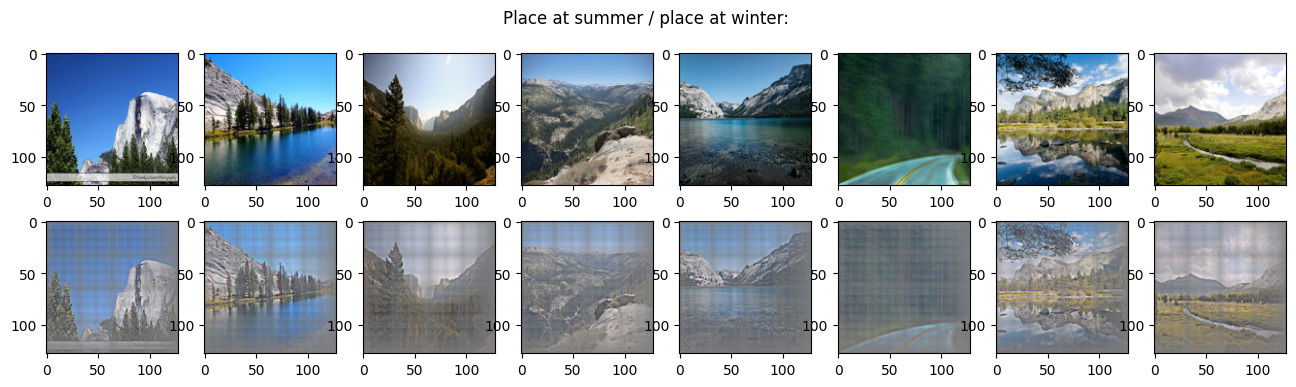

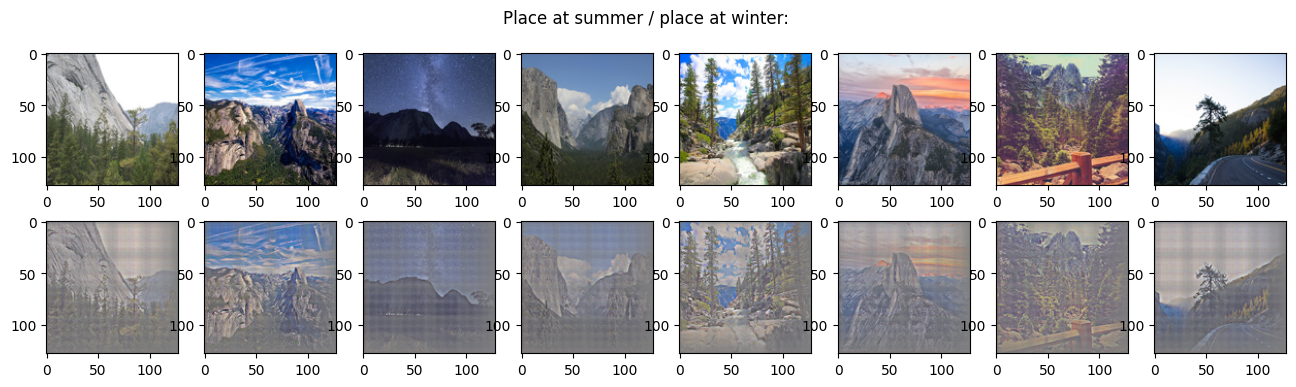

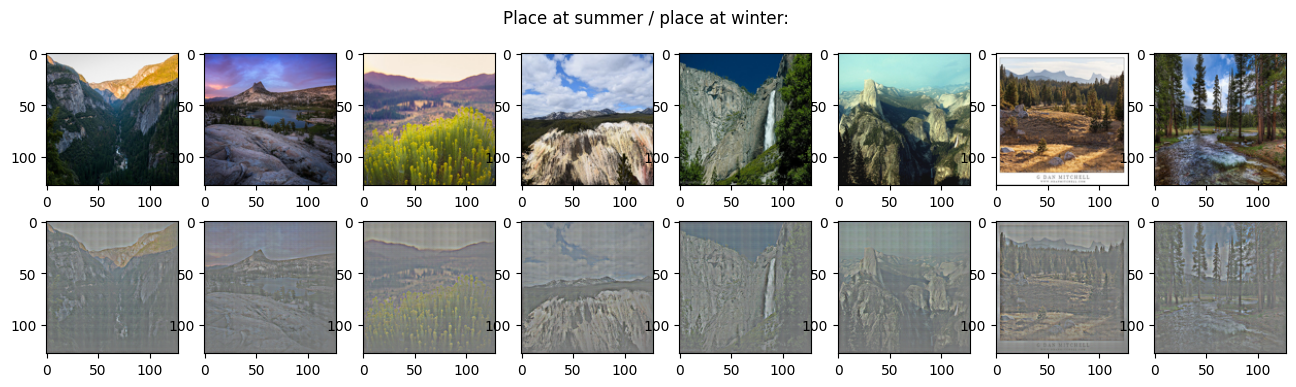

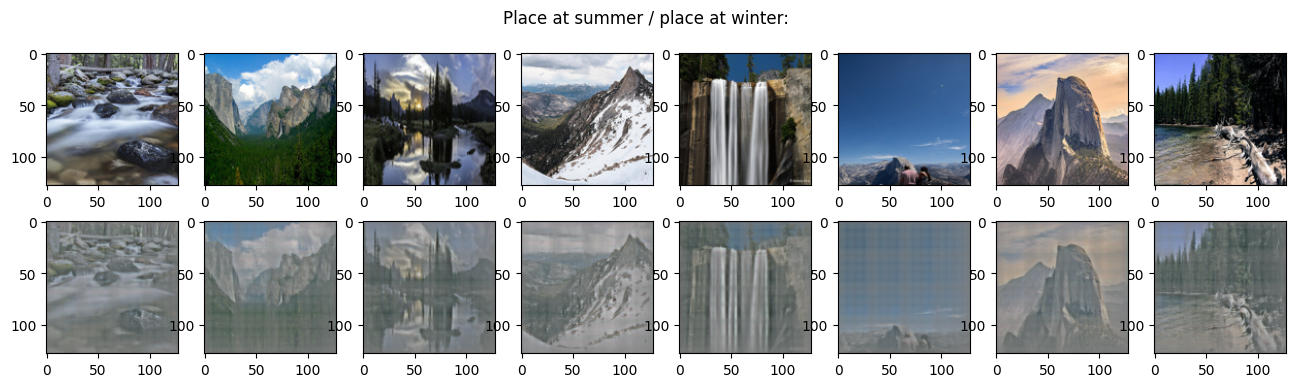

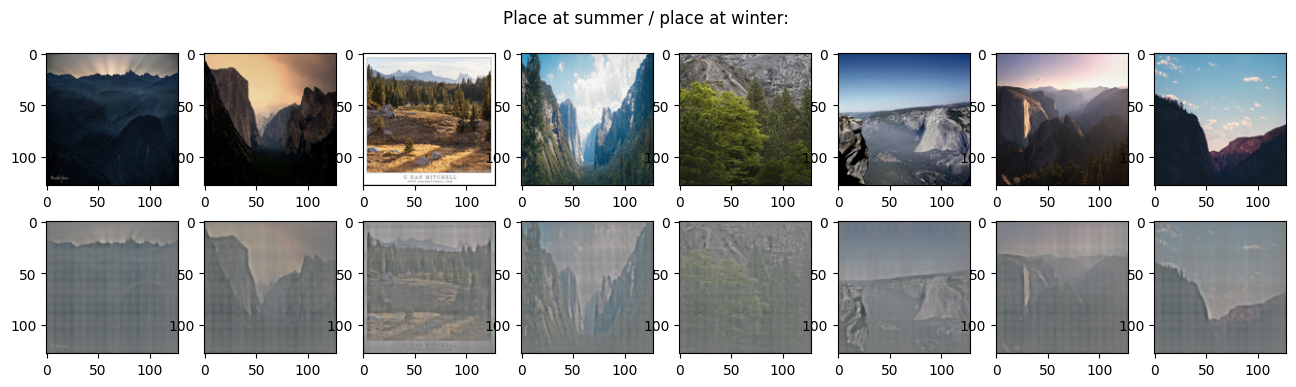

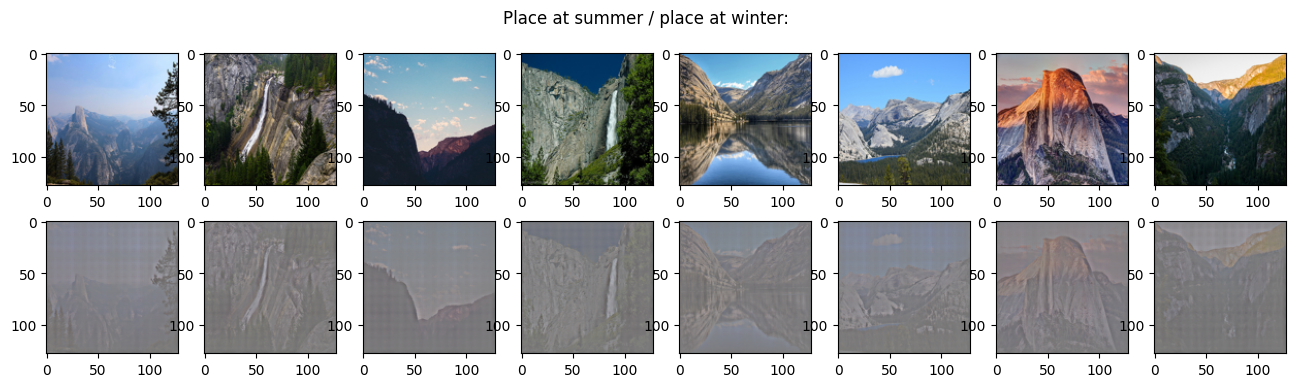

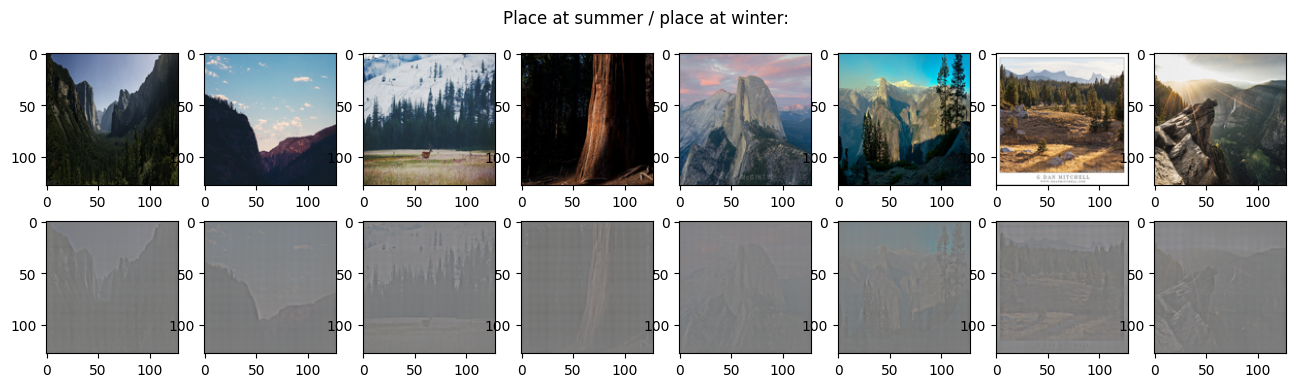

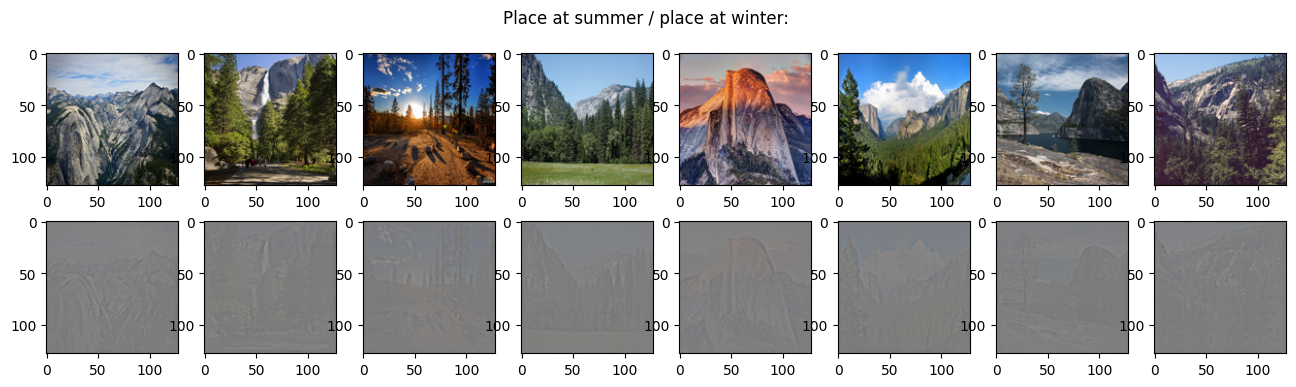

In [13]:
# Main training loop
epochs = 30
for epoch in range(epochs):
    d_iter = iter(dataloader)

    for i in tqdm(range(len(dataloader)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        imgs = next(d_iter)[0]
        X = dataloader.dataset.take(imgs, A=True)
        Y = dataloader.dataset.take(imgs, A=False)
        #print(X.shape, Y.shape)
        # Training step
        losses = trainer.step(X.to(trainer.loss_c.theta_device()), Y.to(trainer.loss_c.omega_device()))

        loss_R = f"{losses['loss_R']:.4f}" if losses.get('loss_R') is not None else '?'
        print(f"\nEpoch {epoch}: " +
            f"W Dist={losses['loss_corr']:.4f}, " +
            f"Cycle={losses['loss_cycle']:.4f}, " +
            f"Reg={loss_R}, " +
            f"Total={losses['loss_total']:.4f}")

    Val_iter = iter(dataVal)
    X_test = dataVal.dataset.take(next(Val_iter)[0], A=True).to(trainer.loss_c.theta_device())
    X_test.requires_grad_(True)
    Y_generated = trainer.generate(X_test).detach().cpu()
    
    cols = 8
    
    # Visualize
    fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
    fig.suptitle('Place at summer / place at winter:')
    
    for i in range(cols):
        X_img = np.asarray(dataVal.dataset.to_image(X_test.detach().cpu())[i], dtype=np.uint8)
        _ = axes[0][i].imshow(X_img)
    
        Y_img = np.asarray(dataVal.dataset.to_image(Y_generated.cpu())[i], dtype=np.uint8)
        _ = axes[1][i].imshow(Y_img)
    
    #plt.tight_layout()
    fig.show()

/tmp/ipykernel_324839/3788776810.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


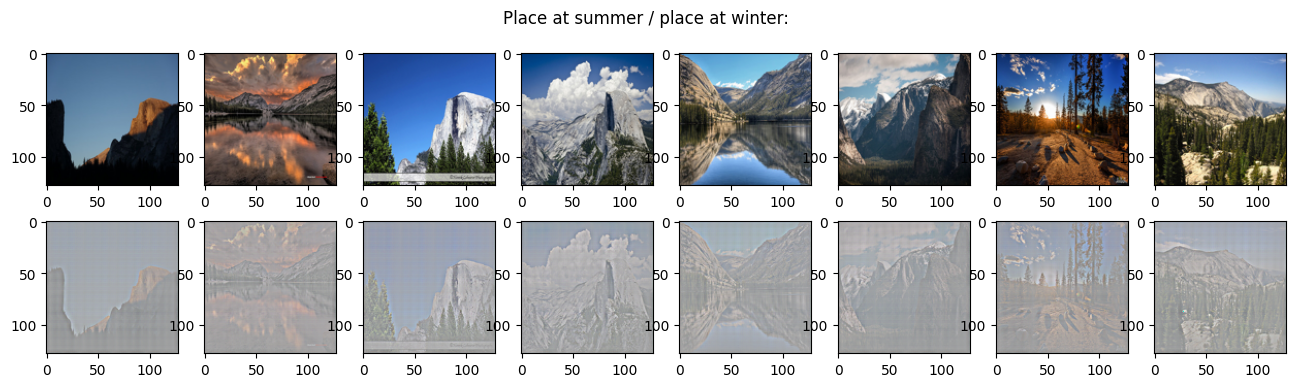

In [23]:
Val_iter = iter(dataVal)
X_test = dataVal.dataset.take(next(Val_iter)[0], A=True).to(trainer.loss_c.theta_device())
X_test.requires_grad_(True)
Y_generated = trainer.generate(X_test).detach().cpu()

cols = 8

# Visualize
fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
fig.suptitle('Place at summer / place at winter:')

for i in range(cols):
    X_img = np.asarray(dataVal.dataset.to_image(X_test.detach().cpu())[i], dtype=np.uint8)
    _ = axes[0][i].imshow(X_img)

    Y_img = np.asarray(dataVal.dataset.to_image(Y_generated.cpu())[i], dtype=np.uint8)
    _ = axes[1][i].imshow(Y_img)

#plt.tight_layout()
fig.show()